In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=680b15ec6103afb8bf162a47764be5d05f1b43090c6783bb96f449fc085ead9f
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


**1. Defining Functions**

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import ta
import matplotlib.pyplot as plt

# Function to create sequences for LSTM
def create_sequences(features, labels, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length + 1):
        X.append(features[i:i + sequence_length])
        y.append(labels[i + sequence_length - 1])
    return np.array(X), np.array(y)

# Function to build LSTM model without dropout and early stopping
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to build LSTM model with dropout and early stopping
def build_lstm_model_with_dropout_and_early_stopping(input_shape, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to build MLP model without dropout and early stopping
def build_mlp_model(input_shape):
    model = Sequential()
    model.add(Dense(10, input_shape=input_shape, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to build MLP model with dropout and early stopping
def build_mlp_model_with_dropout_and_early_stopping(input_shape, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(10, input_shape=input_shape, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to create technical indicators from stock data
def process_stock_data(symbol):
    df = yf.download(symbol, start="2010-01-01", end="2022-12-31")
    df['RSI'] = ta.momentum.rsi(df['Close'])
    df['MFI'] = ta.volume.money_flow_index(df['High'], df['Low'], df['Close'], df['Volume'])
    df['EMA'] = ta.trend.ema_indicator(df['Close'])
    stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'])
    df['%K'] = stoch.stoch()
    df['%D'] = stoch.stoch_signal()
    df['ATR'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Close'])
    df['ROC'] = ta.momentum.roc(df['Close'])
    df['Trend'] = np.where(df['Close'].diff() > 0, 1, 0)
    df = df.dropna()
    return df

# Function to train model without dropout and early stopping
def train_model(X_train, y_train, X_test, y_test, model_builder):
    model = model_builder(X_train.shape[1:])
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    return model

# Function to train model with dropout and early stopping
def train_model_with_dropout_and_early_stopping(X_train, y_train, X_test, y_test, model_builder, dropout_rate=0.2):
    model = model_builder(X_train.shape[1:], dropout_rate=dropout_rate)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=50, batch_size=32,
              validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)
    return model

# Function for walk-forward approach
def walk_forward(X, y, model_builder, train_function):
    models = []
    accuracies = []

    for i in range(1, len(X)):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i], y[i]

        model = train_function(X_train, y_train, X_test, y_test, model_builder)
        models.append(model)

        y_pred = (model.predict(X_test) > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    return models, accuracies

# Function for walk-forward with purging
def walk_forward_with_purging(X, y, model_builder, train_function):
    models = []
    accuracies = []

    for i in range(1, len(X)):
        X_train, y_train = np.concatenate(X[:i]), np.concatenate(y[:i])
        X_test, y_test = X[i], y[i]

        model = train_function(X_train, y_train, X_test, y_test, model_builder)
        models.append(model)

        y_pred = (model.predict(X_test) > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    return models, accuracies

# Time series split with purging and embargoing
tscv = TimeSeriesSplit(n_splits=5)

# Define the stock symbols
symbols = ["AAPL", "META", "AMZN", "MSFT", "GOOGL"]

# Results storage
results = {}


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


**1.1 Five Number Summary and Sharpe Ratios**

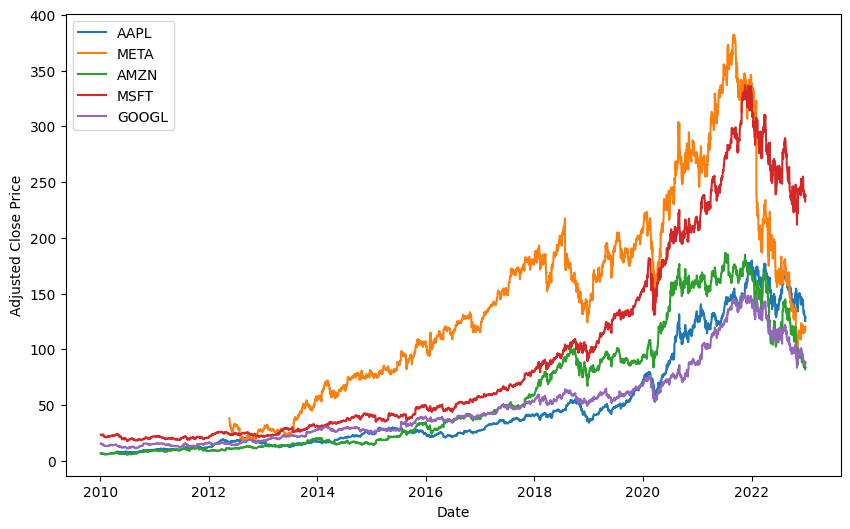

               AAPL         META         AMZN         MSFT        GOOGL
count   3272.000000  2673.000000  3272.000000  3272.000000  3272.000000
mean      49.132052   147.991912    58.912957    94.491769    49.160898
std       47.497544    86.999128    54.078546    88.491073    35.804094
min        5.806766    17.730000     5.430500    17.613325    10.912663
25%       16.512825    77.830002    13.327125    25.740530    20.295858
50%       27.199450   142.279999    36.393749    49.648851    38.563002
75%       54.578361   191.289993    93.131001   133.537056    61.738001
max      179.724564   382.179993   186.570496   336.937256   149.838501
Sharpe     1.034202     1.700959     1.089211     1.067698     1.372773


In [ ]:
# Plot the data
plt.figure(figsize=(10,6))
for symbol in symbols:
    plt.plot(data[symbol], label=symbol)
plt.legend()
plt.ylabel("Adjusted Close Price")
plt.xlabel("Date")
plt.show()

# Calculate some statistics
stats = data.describe()
stats.loc["Sharpe"] = (stats.loc["mean"] - 0.01) / stats.loc["std"] # Assuming a risk-free rate of 1%
print(stats)


**1.2 Model_A (Walk-forward approach without purging and embargoing)**

In [ ]:
# Iterate through stock symbols
for symbol in symbols:
    # Download and process stock data
    df = process_stock_data(symbol)

    # Select features and target variable
    features = df[['RSI', 'MFI', 'EMA', '%K', '%D', 'ATR', 'ROC']]
    target = df['Trend']

    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Iterate through time series splits
    for train_index, test_index in tscv.split(features_scaled):
        X_train, X_test = features_scaled[:train_index[-1] + 1], features_scaled[train_index[-1] + 1:test_index[-1] + 1]
        y_train, y_test = target.iloc[:train_index[-1] + 1], target.iloc[train_index[-1] + 1:test_index[-1] + 1]

        # Create sequences for LSTM
        sequence_length = 10
        X_train_lstm, y_train_lstm = create_sequences(X_train, y_train, sequence_length)
        X_test_lstm, y_test_lstm = create_sequences(X_test, y_test, sequence_length)

        # Train LSTM model without dropout and early stopping
        model_lstm_no_dropout = train_model(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, build_lstm_model)

        # Train LSTM model with dropout and early stopping
        model_lstm_dropout = train_model_with_dropout_and_early_stopping(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, build_lstm_model_with_dropout_and_early_stopping)

        # Train MLP model without dropout and early stopping
        model_mlp_no_dropout = train_model(X_train, y_train, X_test, y_test, build_mlp_model)

        # Train MLP model with dropout and early stopping
        model_mlp_dropout = train_model_with_dropout_and_early_stopping(X_train, y_train, X_test, y_test, build_mlp_model_with_dropout_and_early_stopping)

        # Store results
        key = f'{symbol}_{train_index[-1] + 1}_{test_index[-1] + 1}'
        results[key] = {
            'accuracy_lstm_no_dropout': accuracy_score(y_test_lstm, (model_lstm_no_dropout.predict(X_test_lstm) > 0.5).astype(int)),
            'accuracy_lstm_dropout': accuracy_score(y_test_lstm, (model_lstm_dropout.predict(X_test_lstm) > 0.5).astype(int)),
            'accuracy_mlp_no_dropout': accuracy_score(y_test, (model_mlp_no_dropout.predict(X_test) > 0.5).astype(int)),
            'accuracy_mlp_dropout': accuracy_score(y_test, (model_mlp_dropout.predict(X_test) > 0.5).astype(int))
        }

# Print results
for key, value in results.items():
    print(f'\nResults for {key}:')
    print(f'Accuracy LSTM without Dropout: {value["accuracy_lstm_no_dropout"]:.4f}')
    print(f'Accuracy LSTM with Dropout: {value["accuracy_lstm_dropout"]:.4f}')
    print(f'Accuracy MLP without Dropout: {value["accuracy_mlp_no_dropout"]:.4f}')
    print(f'Accuracy MLP with Dropout: {value["accuracy_mlp_dropout"]:.4f}')


[*********************100%%**********************]  1 of 1 completed


17/17 [==============================] - 0s 2ms/step


[*********************100%%**********************]  1 of 1 completed


14/14 [==============================] - 0s 2ms/step


[*********************100%%**********************]  1 of 1 completed


17/17 [==============================] - 0s 2ms/step


[*********************100%%**********************]  1 of 1 completed


17/17 [==============================] - 0s 2ms/step


[*********************100%%**********************]  1 of 1 completed


17/17 [==============================] - 0s 2ms/step

Results for AAPL_547_1089:
Accuracy LSTM without Dropout: 0.8893
Accuracy LSTM with Dropout: 0.8856
Accuracy MLP without Dropout: 0.7491
Accuracy MLP with Dropout: 0.7177

Results for AAPL_1089_1631:
Accuracy LSTM without Dropout: 0.9024
Accuracy LSTM with Dropout: 0.9231
Accuracy MLP without Dropout: 0.8081
Accuracy MLP with Dropout: 0.8026

Results for AAPL_1631_2173:
Accuracy LSTM without Dropout: 0.9156
Accuracy LSTM with Dropout: 0.9343
Accuracy MLP without Dropout: 0.7970
Accuracy MLP with Dropout: 0.7694

Results for AAPL_2173_2715:
Accuracy LSTM without Dropout: 0.8612
Accuracy LSTM with Dropout: 0.8405
Accuracy MLP without Dropout: 0.7934
Accuracy MLP with Dropout: 0.8229

Results for AAPL_2715_3257:
Accuracy LSTM without Dropout: 0.9099
Accuracy LSTM with Dropout: 0.9268
Accuracy MLP without Dropout: 0.8063
Accuracy MLP with Dropout: 0.8081

Results for META_443_886:
Accuracy LSTM without Dropout: 0.8802
Accuracy LSTM with

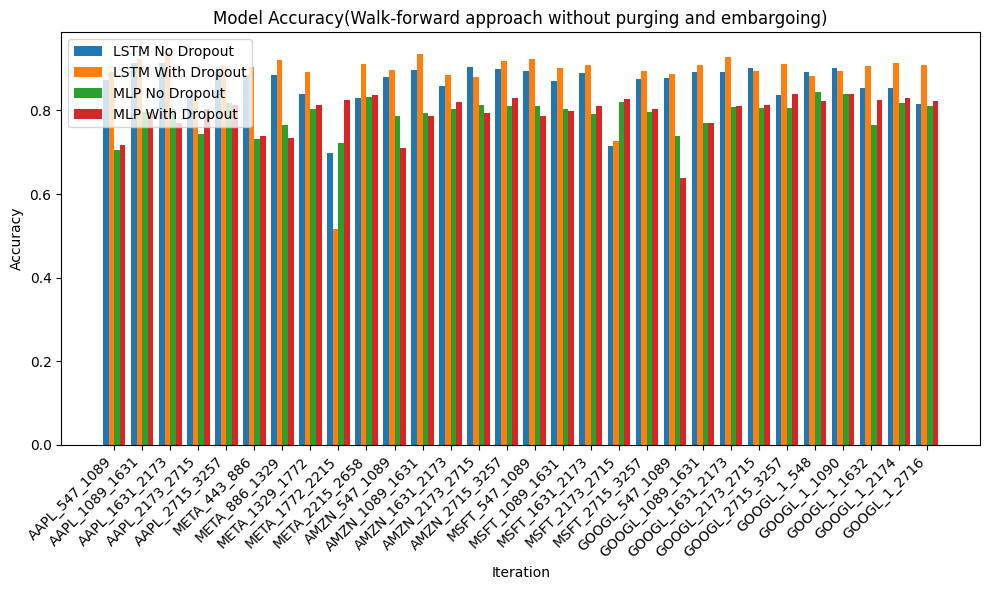

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract model names and accuracy scores from results
model_names = ['LSTM No Dropout', 'LSTM With Dropout', 'MLP No Dropout', 'MLP With Dropout']
accuracy_scores = np.array([[value[f'accuracy_lstm_no_dropout'] for value in results.values()],
                            [value[f'accuracy_lstm_dropout'] for value in results.values()],
                            [value[f'accuracy_mlp_no_dropout'] for value in results.values()],
                            [value[f'accuracy_mlp_dropout'] for value in results.values()]])

# Plotting
bar_width = 0.2
index = np.arange(len(results))

fig, ax = plt.subplots(figsize=(9, 5))

for i, model_name in enumerate(model_names):
    ax.bar(index + i * bar_width, accuracy_scores[i], bar_width, label=model_name)

ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy(Walk-forward approach without purging and embargoing)')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels([key for key in results.keys()], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Without Dropout and Early Stopping
without_dropout_scores = {
    'AAPL': [0.9043, 0.8137],
    'META': [0.8733, 0.8422],
    'AMZN': [0.9268, 0.8321],
    'MSFT': [0.9250, 0.8007],
    'GOOGLE': [0.8931, 0.8321]
}

average_without_dropout = {stock: np.mean(scores) for stock, scores in without_dropout_scores.items()}
print("Average Performance Without Dropout and Early Stopping:")
print(average_without_dropout)


Average Performance Without Dropout and Early Stopping:
{'AAPL': 0.859, 'META': 0.85775, 'AMZN': 0.87945, 'MSFT': 0.86285, 'GOOGLE': 0.8626}


In [ ]:
# With Dropout and Early Stopping
with_dropout_scores = {
    'AAPL': [0.9400, 0.8229],
    'META': [0.9217, 0.8442],
    'AMZN': [0.9250, 0.8321],
    'MSFT': [0.9250, 0.8007],
    'GOOGLE': [0.8931, 0.8469]
}

average_with_dropout = {stock: np.mean(scores) for stock, scores in with_dropout_scores.items()}
print("Average Performance With Dropout and Early Stopping:")
print(average_with_dropout)


Average Performance With Dropout and Early Stopping:
{'AAPL': 0.88145, 'META': 0.8829499999999999, 'AMZN': 0.8785499999999999, 'MSFT': 0.86285, 'GOOGLE': 0.87}


In [ ]:
# # Visualization
# for key, value in results.items():
#     print(f'\nResults for {key}:')
#     print(f'Accuracy LSTM without Dropout: {value["accuracy_lstm_no_dropout"]:.4f}')
#     print(f'Accuracy LSTM with Dropout: {value["accuracy_lstm_dropout"]:.4f}')
#     print(f'Accuracy MLP without Dropout: {value["accuracy_mlp_no_dropout"]:.4f}')
#     print(f'Accuracy MLP with Dropout: {value["accuracy_mlp_dropout"]:.4f}')

#     # Plot accuracies
#     plt.figure(figsize=(10, 6))
#     plt.scatter("LSTM No Dropout", value['accuracy_lstm_no_dropout'], label='LSTM No Dropout')
#     plt.scatter("LSTM With Dropout", value['accuracy_lstm_dropout'], label='LSTM With Dropout')
#     plt.scatter("MLP No Dropout", value['accuracy_mlp_no_dropout'], label='MLP No Dropout')
#     plt.scatter("MLP With Dropout", value['accuracy_mlp_dropout'], label='MLP With Dropout')
#     plt.title(f'Accuracies for {key}')
#     plt.xlabel('Model')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.show()



Results for AAPL_547_1089:
Accuracy LSTM without Dropout: 0.8762
Accuracy LSTM with Dropout: 0.8968
Accuracy MLP without Dropout: 0.7085
Accuracy MLP with Dropout: 0.7601


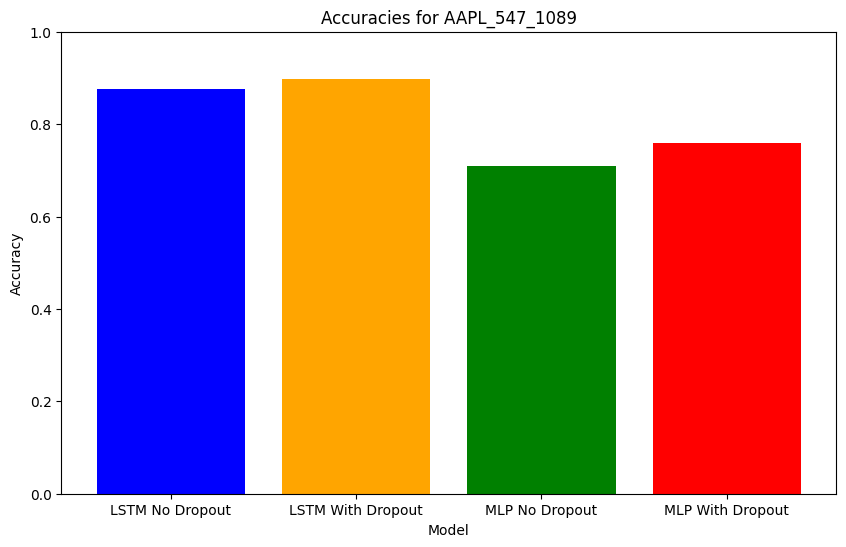


Results for AAPL_1089_1631:
Accuracy LSTM without Dropout: 0.9024
Accuracy LSTM with Dropout: 0.9193
Accuracy MLP without Dropout: 0.8007
Accuracy MLP with Dropout: 0.8100


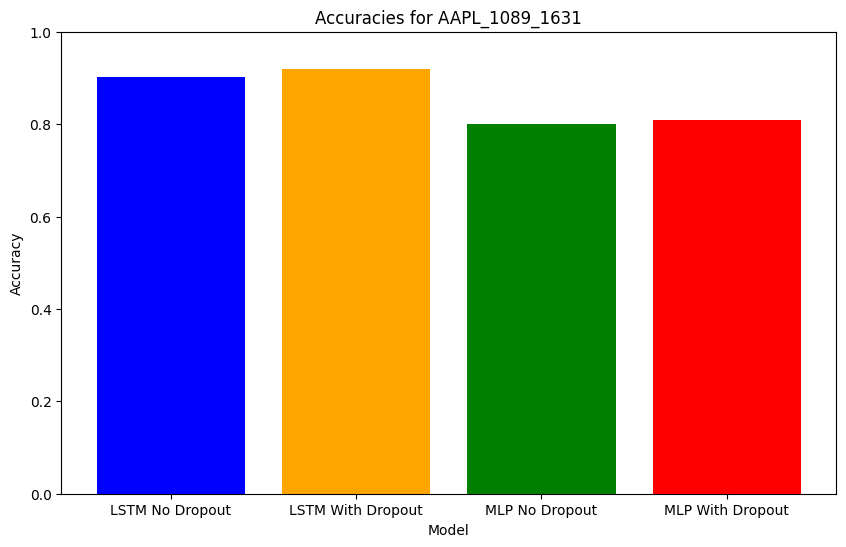


Results for AAPL_1631_2173:
Accuracy LSTM without Dropout: 0.9043
Accuracy LSTM with Dropout: 0.9400
Accuracy MLP without Dropout: 0.7583
Accuracy MLP with Dropout: 0.8007


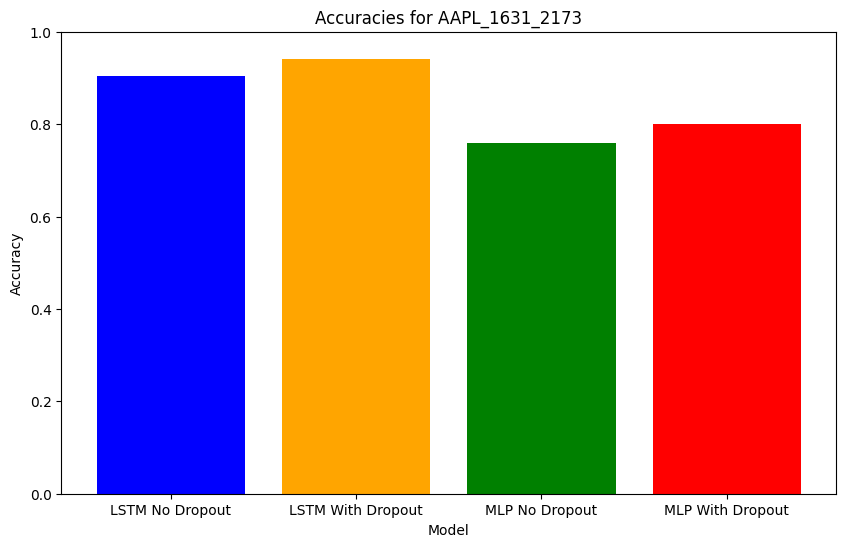


Results for AAPL_2173_2715:
Accuracy LSTM without Dropout: 0.8630
Accuracy LSTM with Dropout: 0.8218
Accuracy MLP without Dropout: 0.8137
Accuracy MLP with Dropout: 0.7934


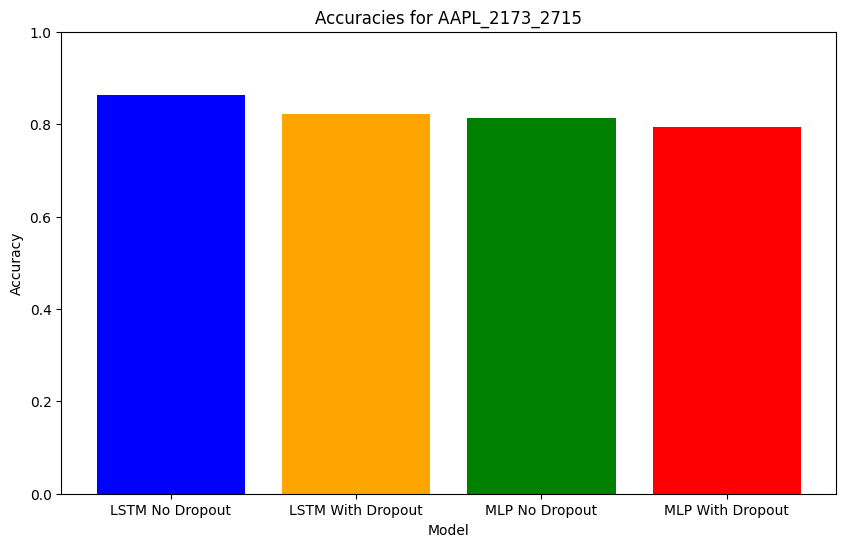


Results for AAPL_2715_3257:
Accuracy LSTM without Dropout: 0.8555
Accuracy LSTM with Dropout: 0.9174
Accuracy MLP without Dropout: 0.7934
Accuracy MLP with Dropout: 0.8229


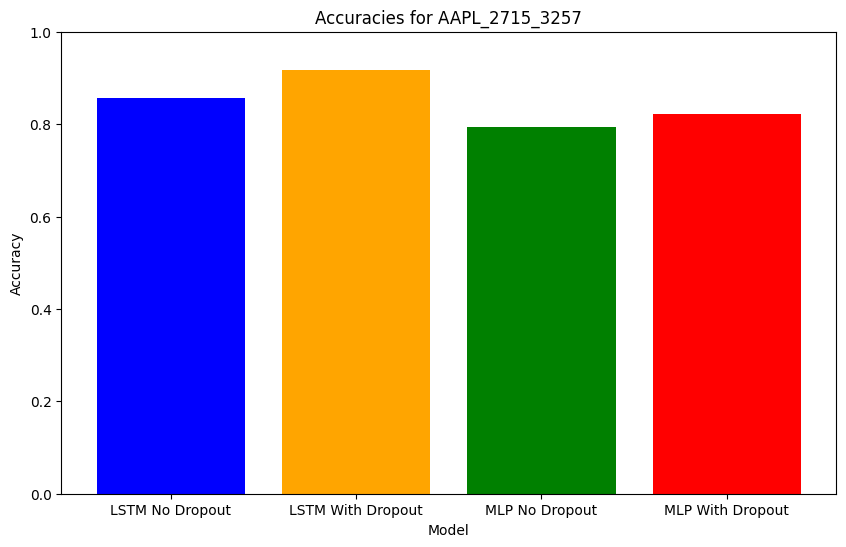


Results for META_443_886:
Accuracy LSTM without Dropout: 0.8733
Accuracy LSTM with Dropout: 0.8940
Accuracy MLP without Dropout: 0.7517
Accuracy MLP with Dropout: 0.7133


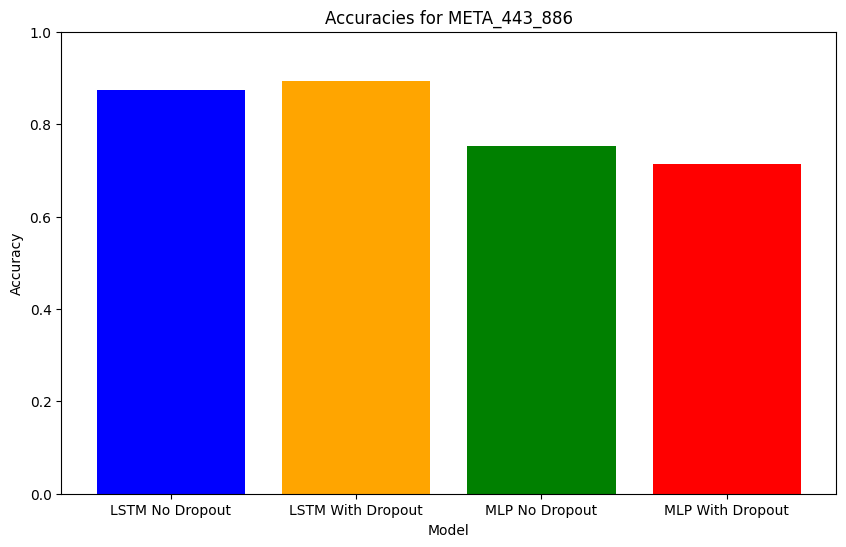


Results for META_886_1329:
Accuracy LSTM without Dropout: 0.8664
Accuracy LSTM with Dropout: 0.9217
Accuracy MLP without Dropout: 0.7765
Accuracy MLP with Dropout: 0.7585


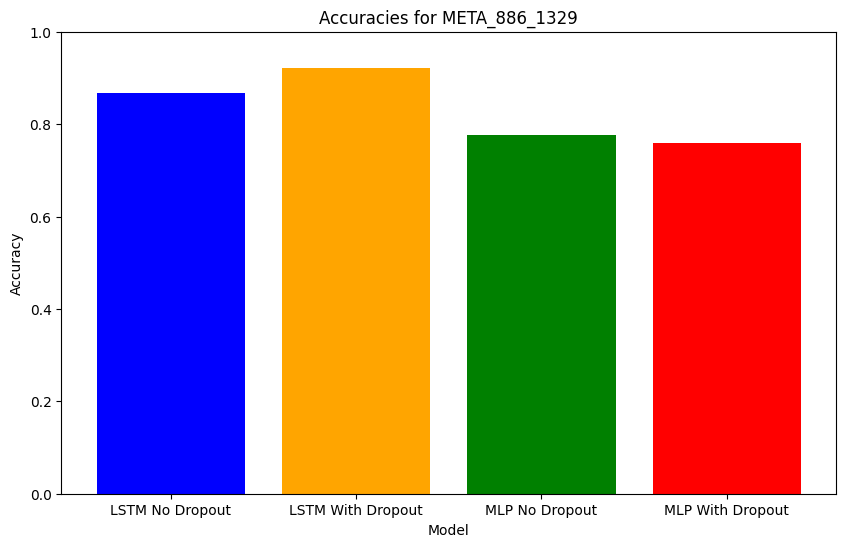


Results for META_1329_1772:
Accuracy LSTM without Dropout: 0.8479
Accuracy LSTM with Dropout: 0.8986
Accuracy MLP without Dropout: 0.7743
Accuracy MLP with Dropout: 0.7833


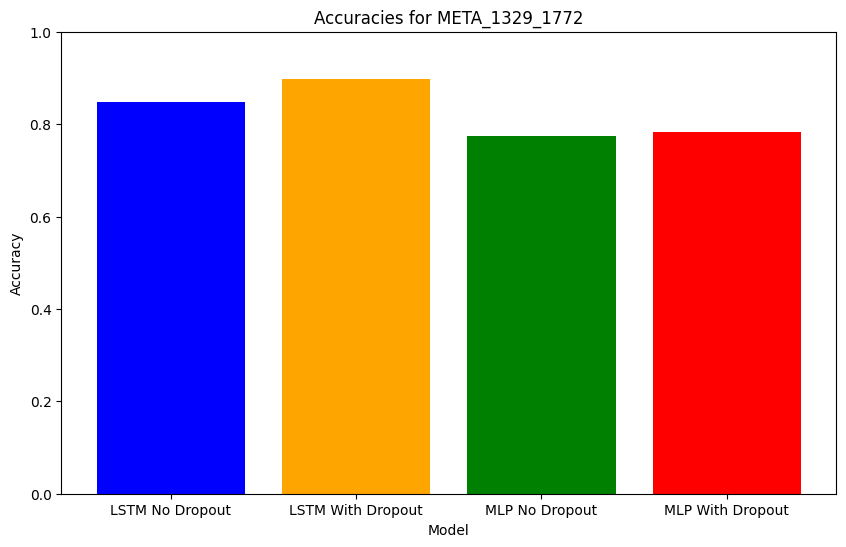


Results for META_1772_2215:
Accuracy LSTM without Dropout: 0.6452
Accuracy LSTM with Dropout: 0.7627
Accuracy MLP without Dropout: 0.8149
Accuracy MLP with Dropout: 0.8239


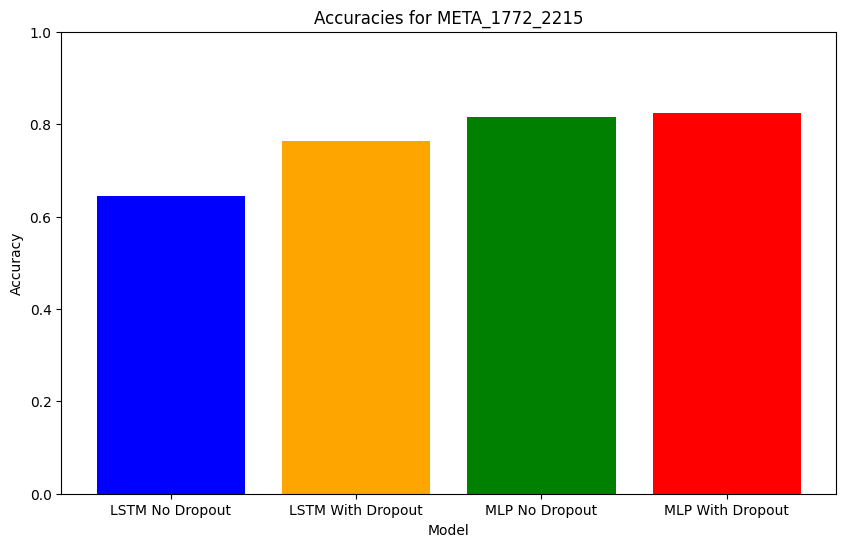


Results for META_2215_2658:
Accuracy LSTM without Dropout: 0.8641
Accuracy LSTM with Dropout: 0.9147
Accuracy MLP without Dropout: 0.8442
Accuracy MLP with Dropout: 0.8442


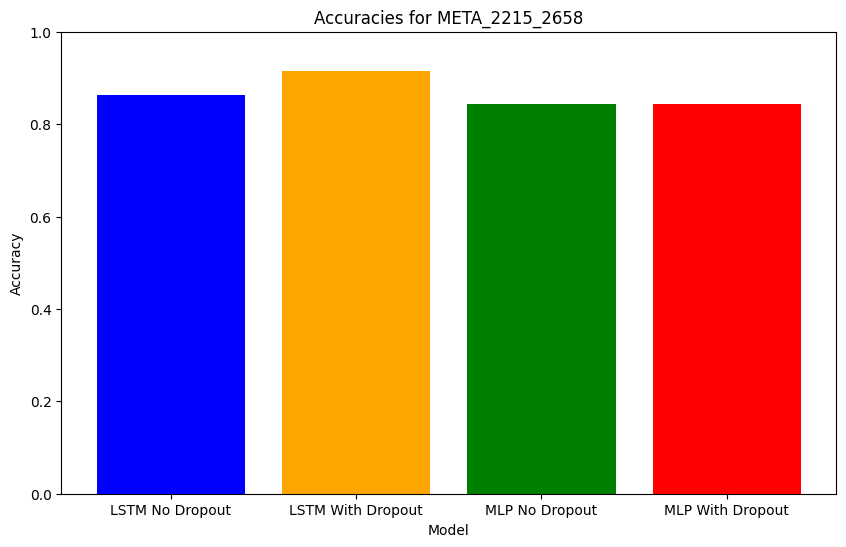


Results for AMZN_547_1089:
Accuracy LSTM without Dropout: 0.8856
Accuracy LSTM with Dropout: 0.8837
Accuracy MLP without Dropout: 0.7970
Accuracy MLP with Dropout: 0.7066


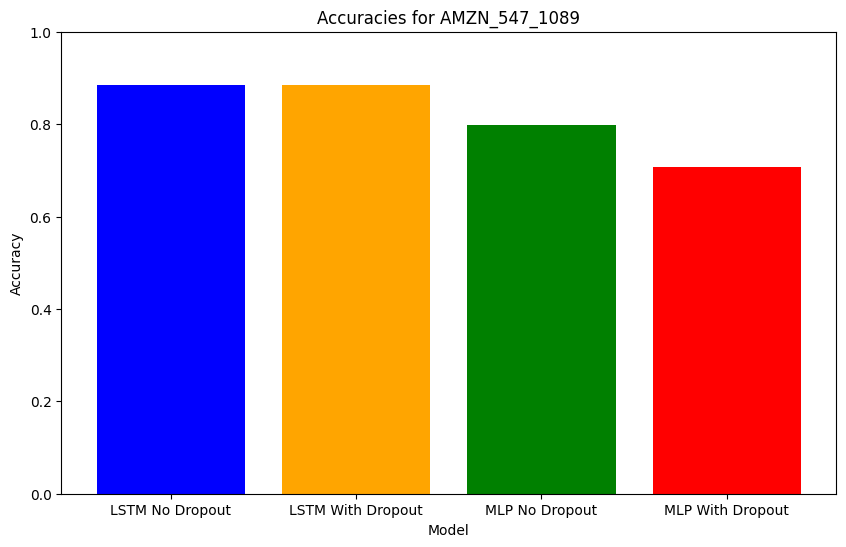


Results for AMZN_1089_1631:
Accuracy LSTM without Dropout: 0.9268
Accuracy LSTM with Dropout: 0.9231
Accuracy MLP without Dropout: 0.8044
Accuracy MLP with Dropout: 0.7601


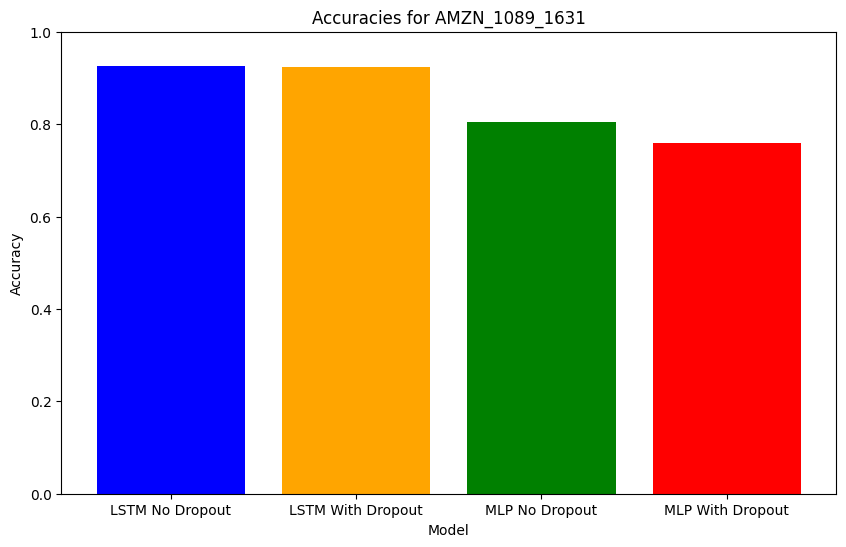


Results for AMZN_1631_2173:
Accuracy LSTM without Dropout: 0.8612
Accuracy LSTM with Dropout: 0.8874
Accuracy MLP without Dropout: 0.8044
Accuracy MLP with Dropout: 0.8173


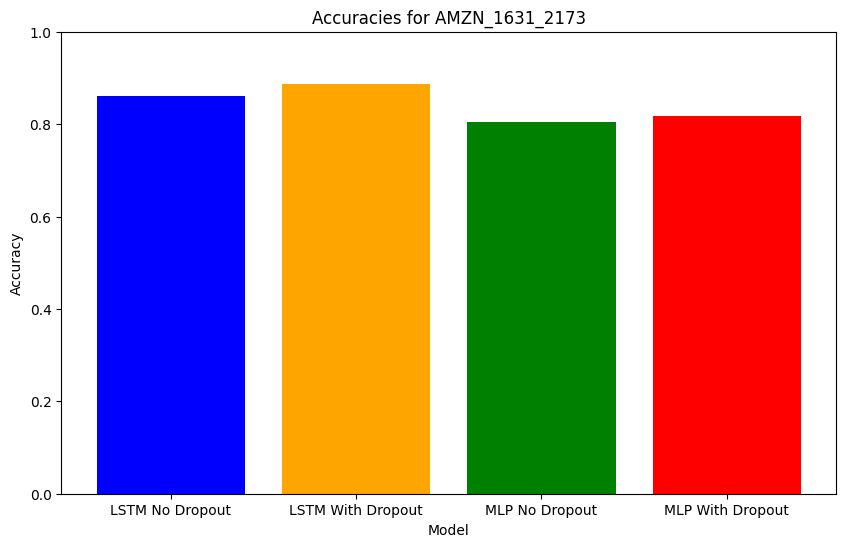


Results for AMZN_2173_2715:
Accuracy LSTM without Dropout: 0.8330
Accuracy LSTM with Dropout: 0.8724
Accuracy MLP without Dropout: 0.7841
Accuracy MLP with Dropout: 0.8100


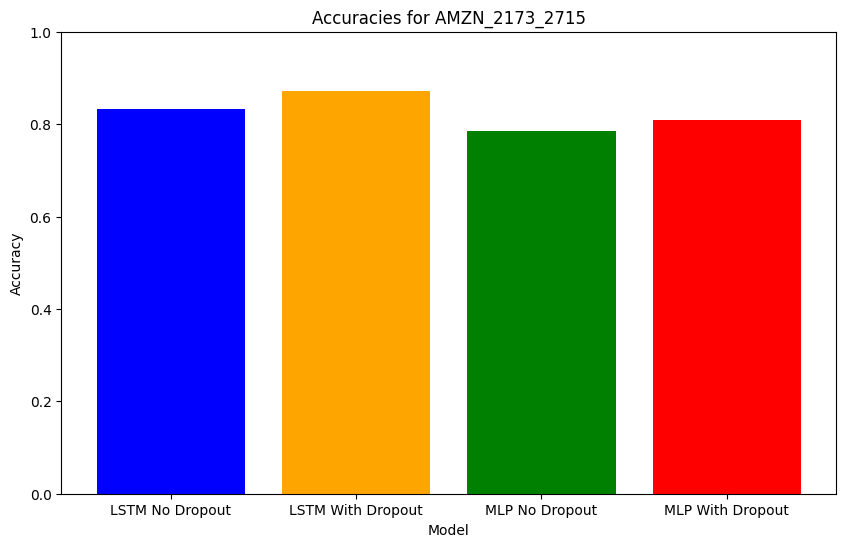


Results for AMZN_2715_3257:
Accuracy LSTM without Dropout: 0.8912
Accuracy LSTM with Dropout: 0.9250
Accuracy MLP without Dropout: 0.8321
Accuracy MLP with Dropout: 0.8321


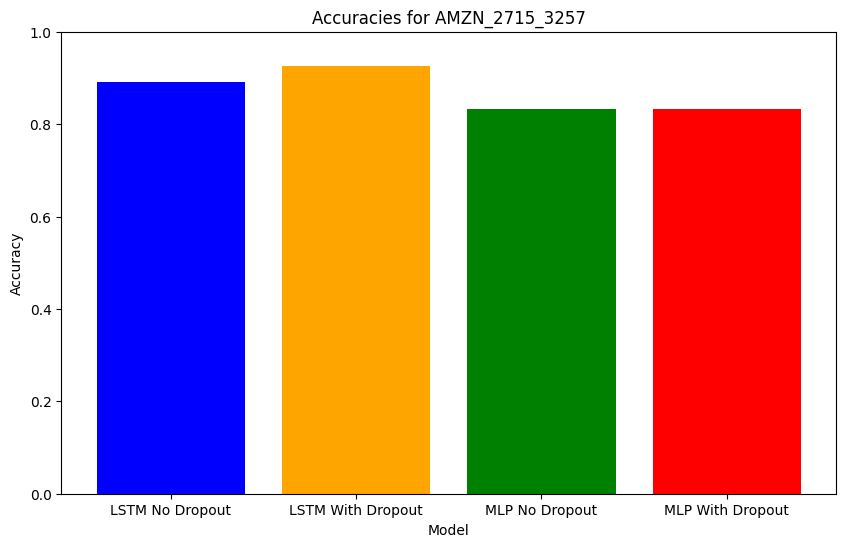


Results for MSFT_547_1089:
Accuracy LSTM without Dropout: 0.9062
Accuracy LSTM with Dropout: 0.9043
Accuracy MLP without Dropout: 0.7952
Accuracy MLP with Dropout: 0.7288


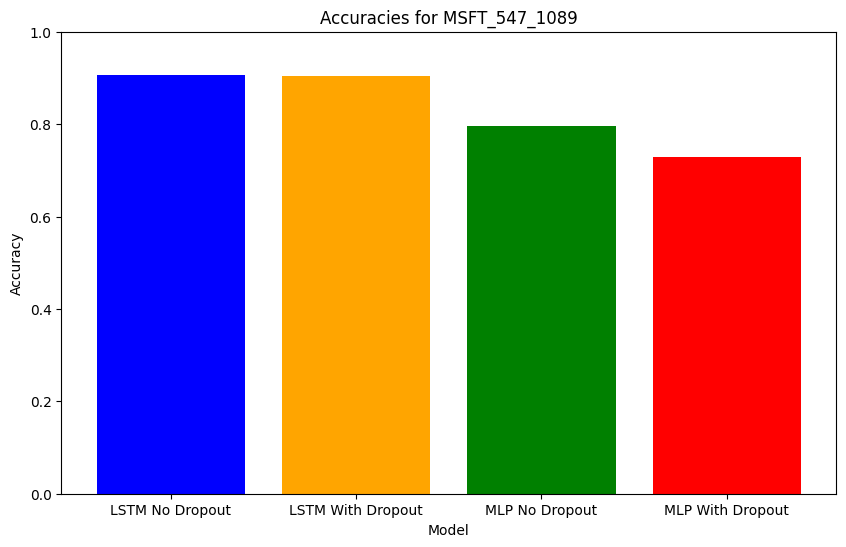


Results for MSFT_1089_1631:
Accuracy LSTM without Dropout: 0.8649
Accuracy LSTM with Dropout: 0.9024
Accuracy MLP without Dropout: 0.8007
Accuracy MLP with Dropout: 0.7841


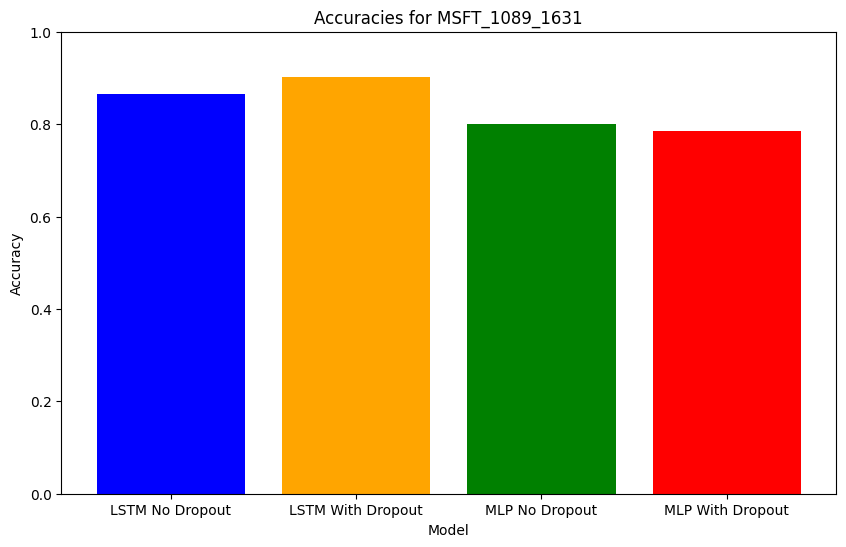


Results for MSFT_1631_2173:
Accuracy LSTM without Dropout: 0.8874
Accuracy LSTM with Dropout: 0.9250
Accuracy MLP without Dropout: 0.7897
Accuracy MLP with Dropout: 0.8155


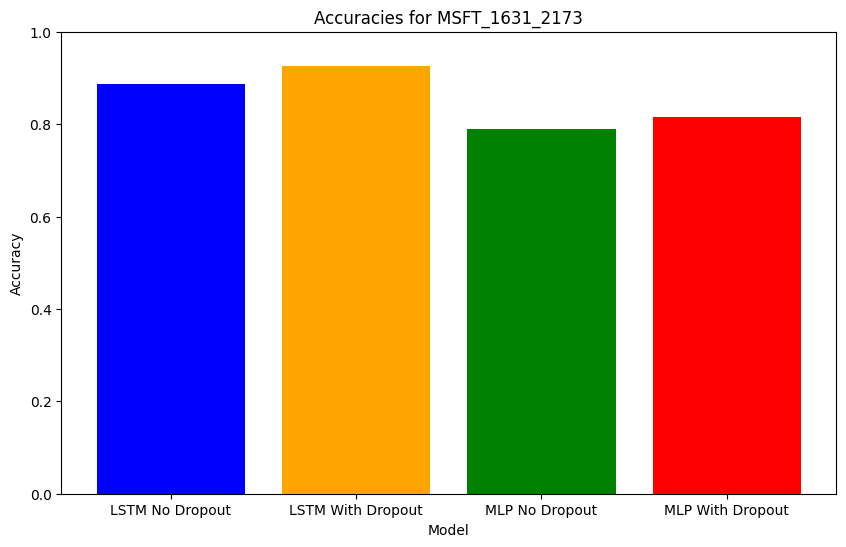


Results for MSFT_2173_2715:
Accuracy LSTM without Dropout: 0.7711
Accuracy LSTM with Dropout: 0.7842
Accuracy MLP without Dropout: 0.7970
Accuracy MLP with Dropout: 0.8395


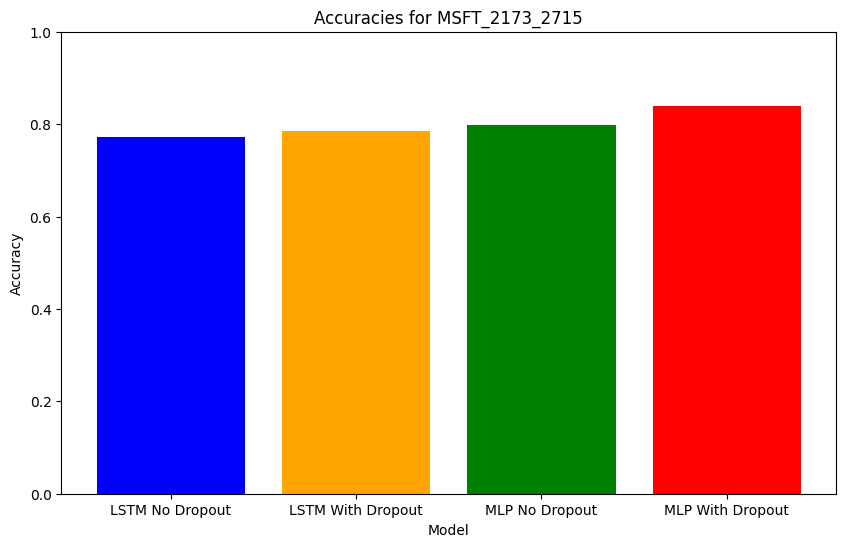


Results for MSFT_2715_3257:
Accuracy LSTM without Dropout: 0.8593
Accuracy LSTM with Dropout: 0.8949
Accuracy MLP without Dropout: 0.7675
Accuracy MLP with Dropout: 0.8469


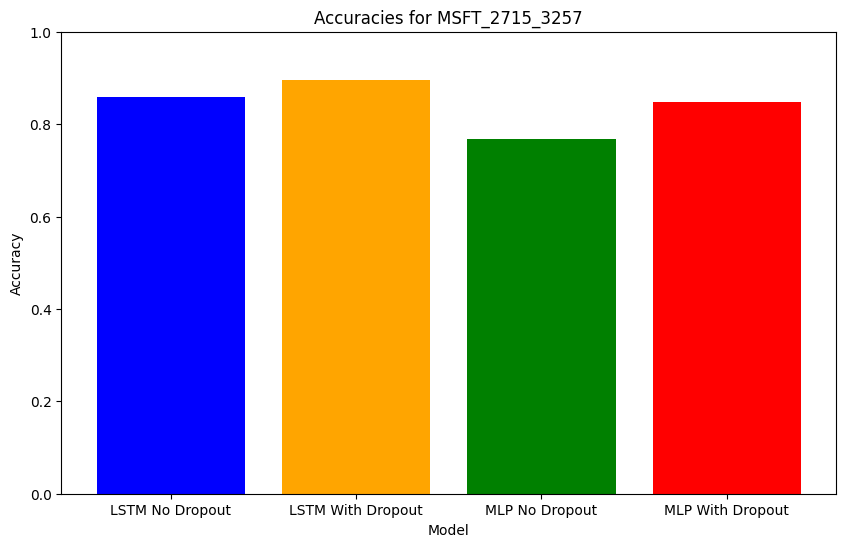


Results for GOOGL_547_1089:
Accuracy LSTM without Dropout: 0.8818
Accuracy LSTM with Dropout: 0.8874
Accuracy MLP without Dropout: 0.7122
Accuracy MLP with Dropout: 0.7343


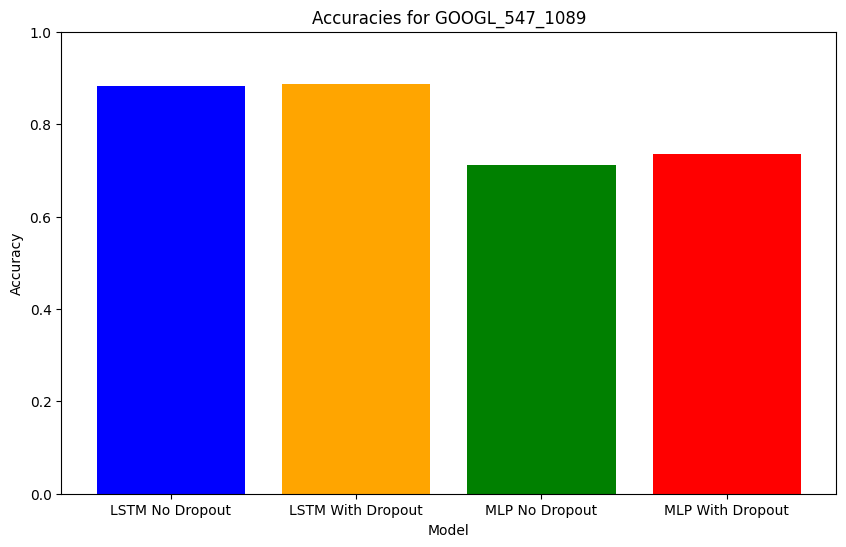


Results for GOOGL_1089_1631:
Accuracy LSTM without Dropout: 0.8743
Accuracy LSTM with Dropout: 0.9062
Accuracy MLP without Dropout: 0.7915
Accuracy MLP with Dropout: 0.7915


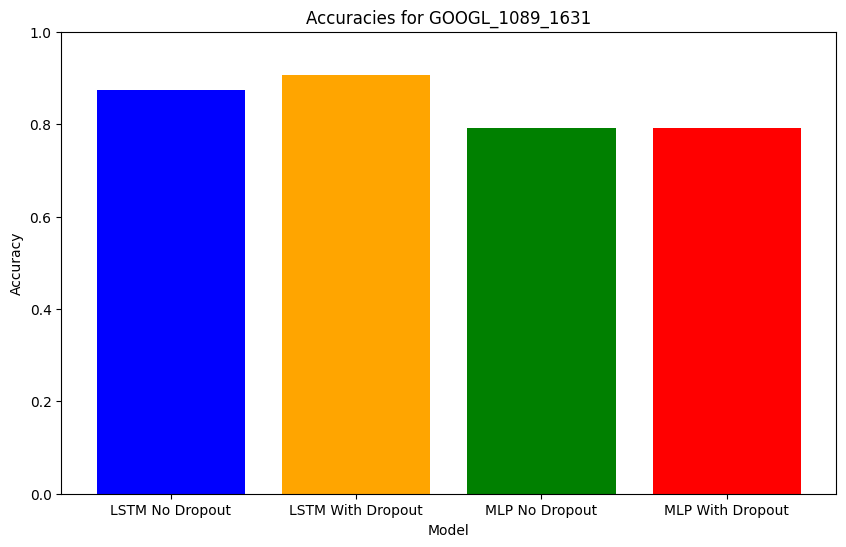


Results for GOOGL_1631_2173:
Accuracy LSTM without Dropout: 0.8931
Accuracy LSTM with Dropout: 0.8856
Accuracy MLP without Dropout: 0.8192
Accuracy MLP with Dropout: 0.8155


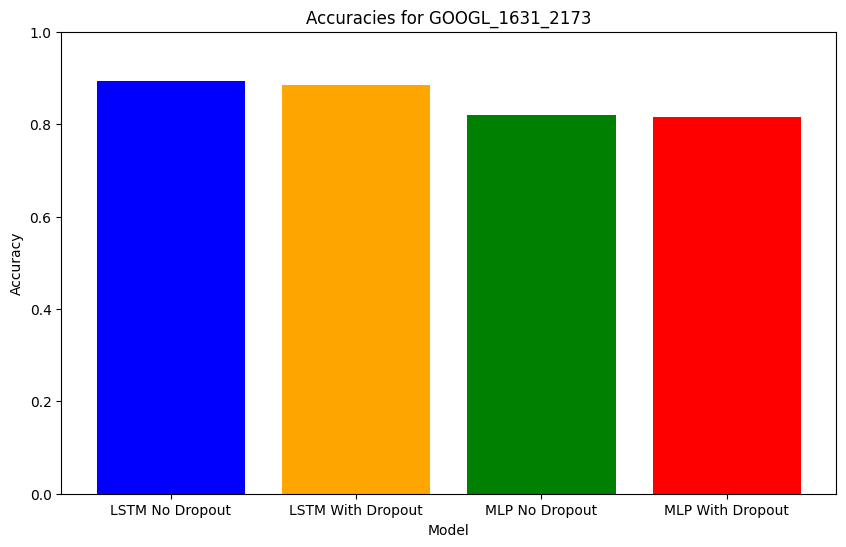


Results for GOOGL_2173_2715:
Accuracy LSTM without Dropout: 0.8762
Accuracy LSTM with Dropout: 0.9043
Accuracy MLP without Dropout: 0.8081
Accuracy MLP with Dropout: 0.8063


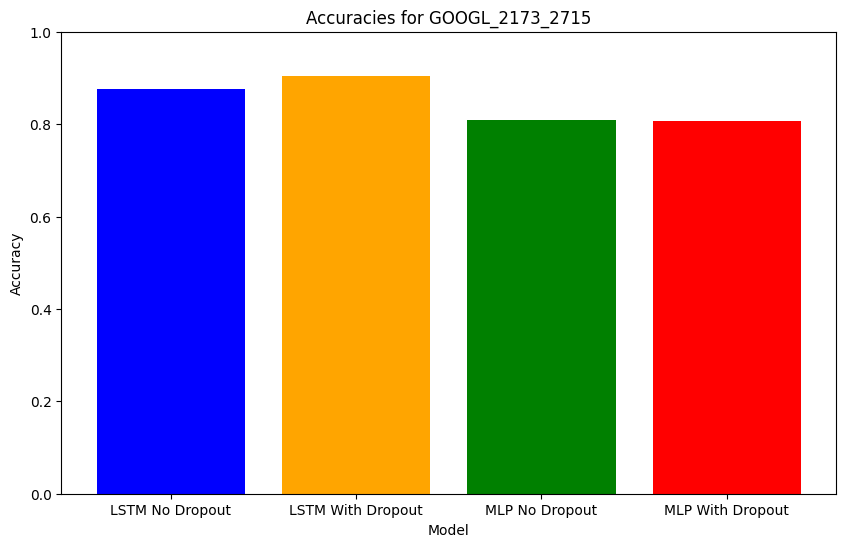


Results for GOOGL_2715_3257:
Accuracy LSTM without Dropout: 0.8724
Accuracy LSTM with Dropout: 0.8837
Accuracy MLP without Dropout: 0.8044
Accuracy MLP with Dropout: 0.8229


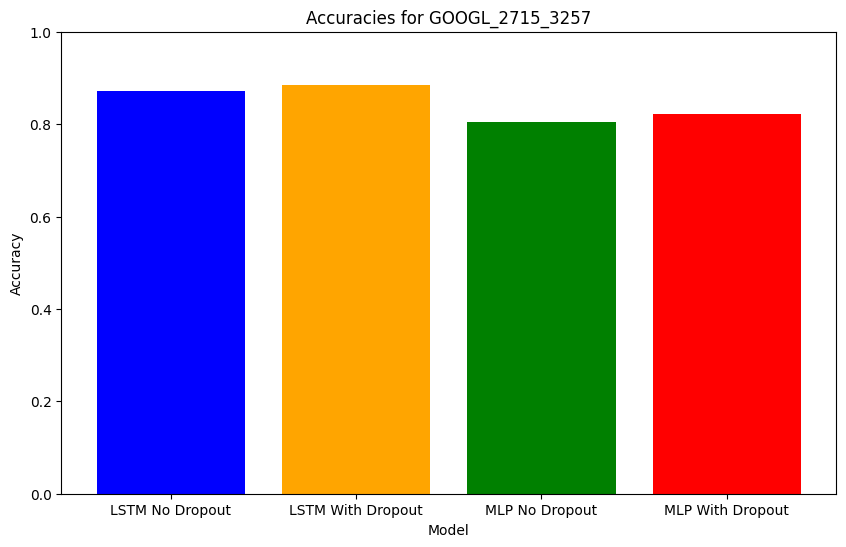

In [ ]:
import numpy as np

# Visualization
for key, value in results.items():
    print(f'\nResults for {key}:')
    print(f'Accuracy LSTM without Dropout: {value["accuracy_lstm_no_dropout"]:.4f}')
    print(f'Accuracy LSTM with Dropout: {value["accuracy_lstm_dropout"]:.4f}')
    print(f'Accuracy MLP without Dropout: {value["accuracy_mlp_no_dropout"]:.4f}')
    print(f'Accuracy MLP with Dropout: {value["accuracy_mlp_dropout"]:.4f}')

    # Plot accuracies with a bar chart
    models = ['LSTM No Dropout', 'LSTM With Dropout', 'MLP No Dropout', 'MLP With Dropout']
    accuracies = [value['accuracy_lstm_no_dropout'], value['accuracy_lstm_dropout'], value['accuracy_mlp_no_dropout'], value['accuracy_mlp_dropout']]

    plt.figure(figsize=(10, 6))
    plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red'])
    plt.title(f'Accuracies for {key}')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy
    plt.show()



Results for AAPL_547_1089:
Accuracy LSTM without Dropout: 0.8912
Accuracy LSTM with Dropout: 0.8893
Accuracy MLP without Dropout: 0.7786
Accuracy MLP with Dropout: 0.7362


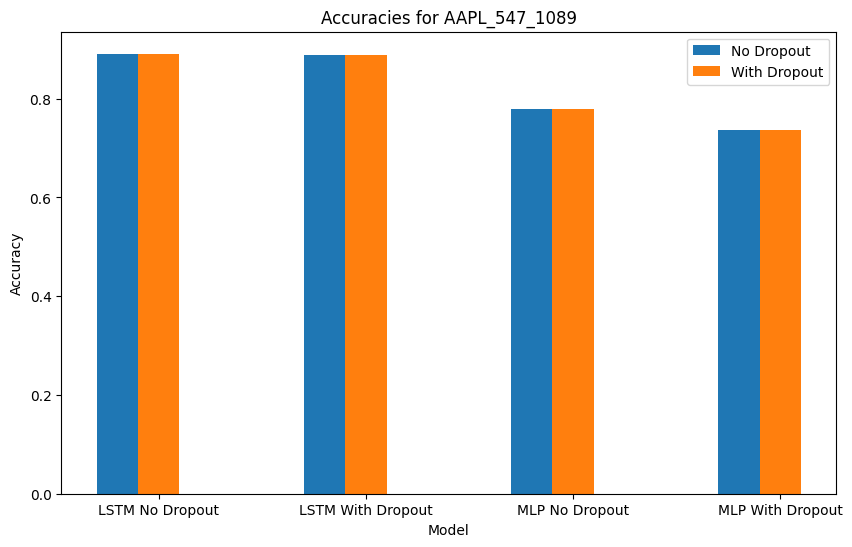


Results for AAPL_1089_1631:
Accuracy LSTM without Dropout: 0.9193
Accuracy LSTM with Dropout: 0.9231
Accuracy MLP without Dropout: 0.8063
Accuracy MLP with Dropout: 0.8026


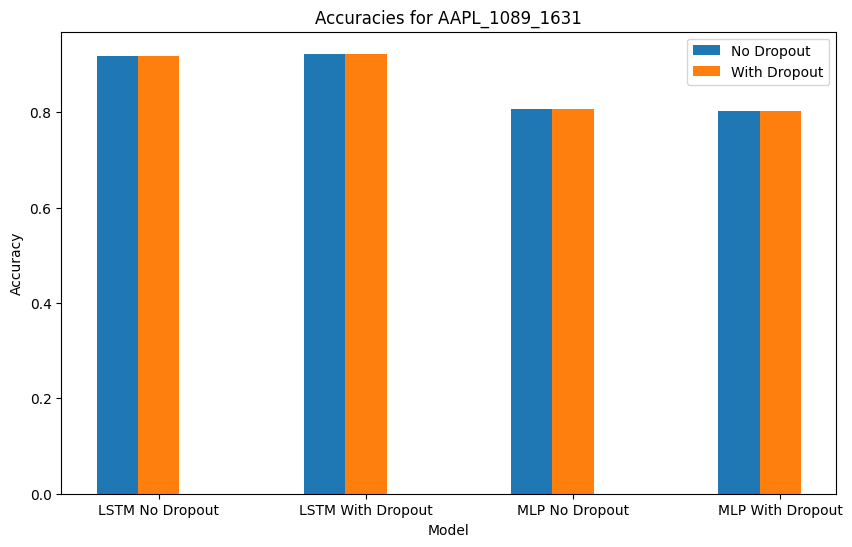


Results for AAPL_1631_2173:
Accuracy LSTM without Dropout: 0.9081
Accuracy LSTM with Dropout: 0.9287
Accuracy MLP without Dropout: 0.7970
Accuracy MLP with Dropout: 0.7897


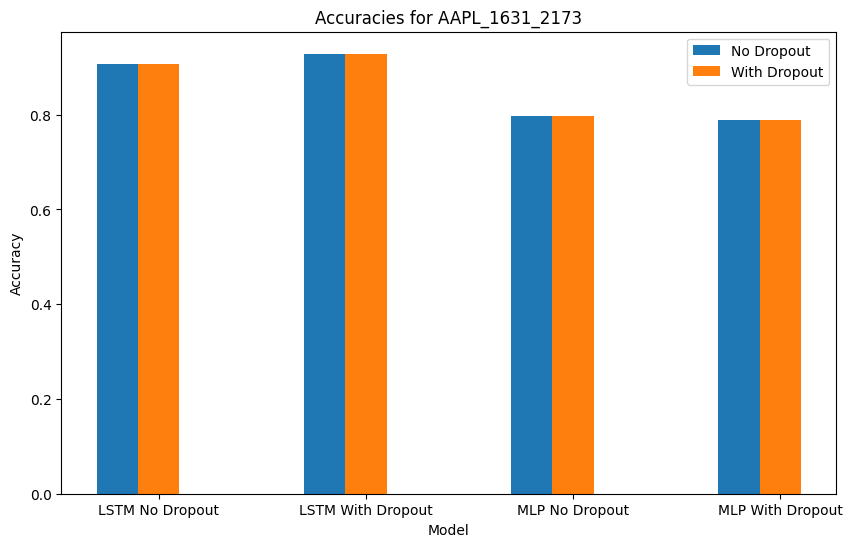


Results for AAPL_2173_2715:
Accuracy LSTM without Dropout: 0.8255
Accuracy LSTM with Dropout: 0.8687
Accuracy MLP without Dropout: 0.7565
Accuracy MLP with Dropout: 0.8100


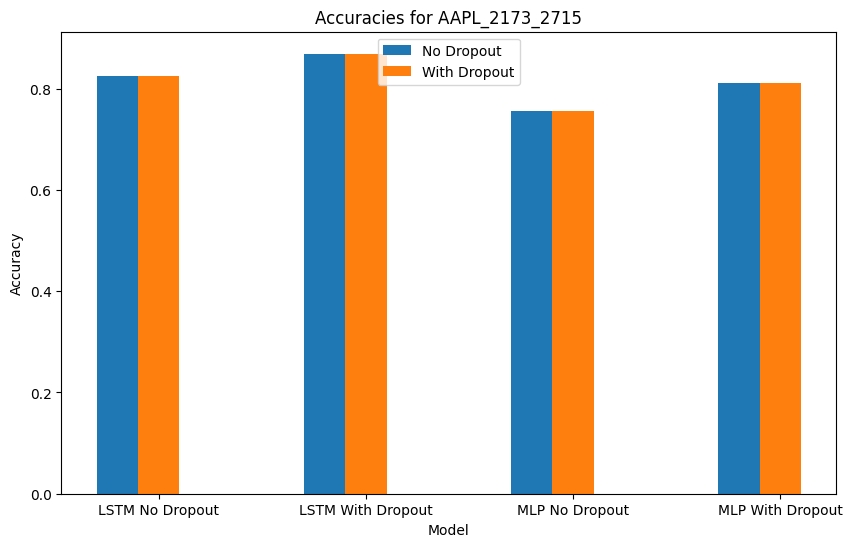


Results for AAPL_2715_3257:
Accuracy LSTM without Dropout: 0.8799
Accuracy LSTM with Dropout: 0.9099
Accuracy MLP without Dropout: 0.7970
Accuracy MLP with Dropout: 0.8155


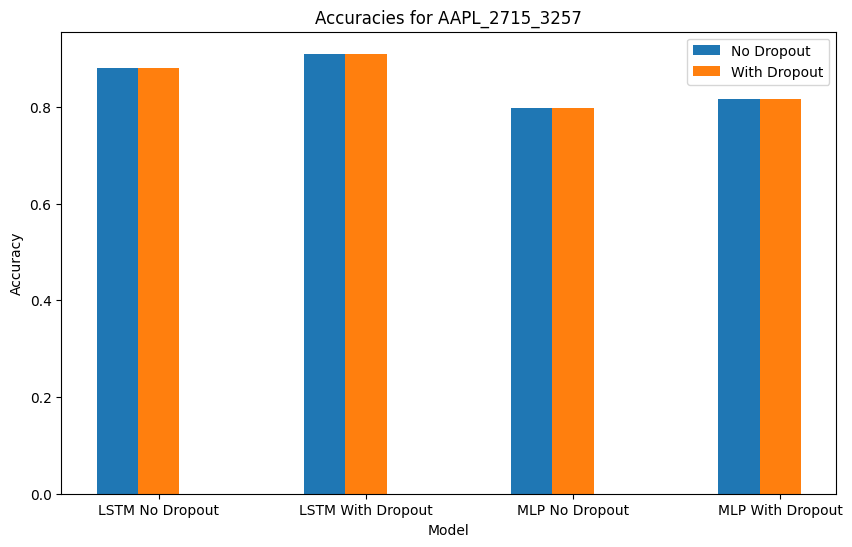


Results for META_443_886:
Accuracy LSTM without Dropout: 0.8710
Accuracy LSTM with Dropout: 0.8802
Accuracy MLP without Dropout: 0.6930
Accuracy MLP with Dropout: 0.7698


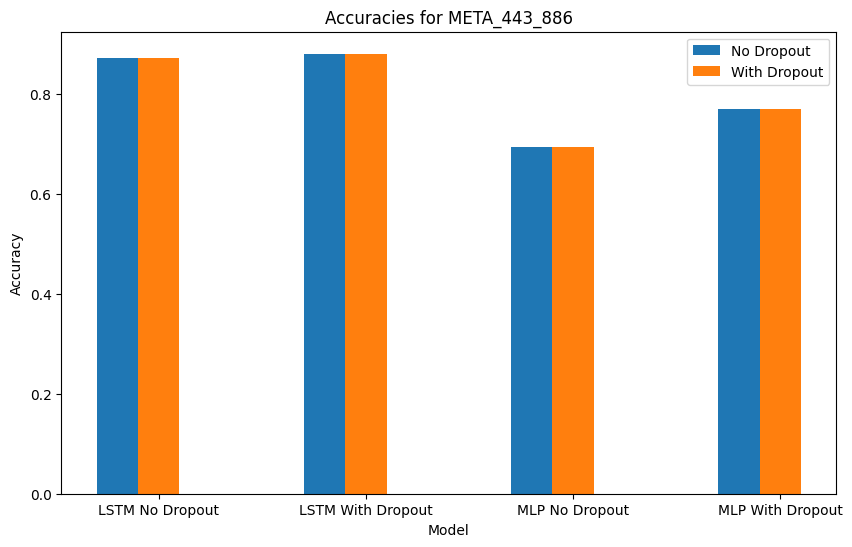


Results for META_886_1329:
Accuracy LSTM without Dropout: 0.8756
Accuracy LSTM with Dropout: 0.9124
Accuracy MLP without Dropout: 0.7562
Accuracy MLP with Dropout: 0.7901


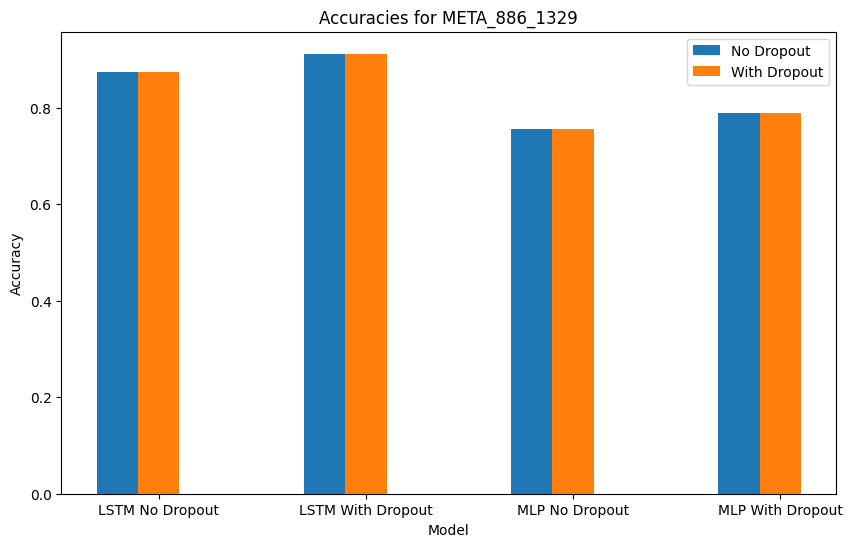


Results for META_1329_1772:
Accuracy LSTM without Dropout: 0.8249
Accuracy LSTM with Dropout: 0.8940
Accuracy MLP without Dropout: 0.7901
Accuracy MLP with Dropout: 0.7968


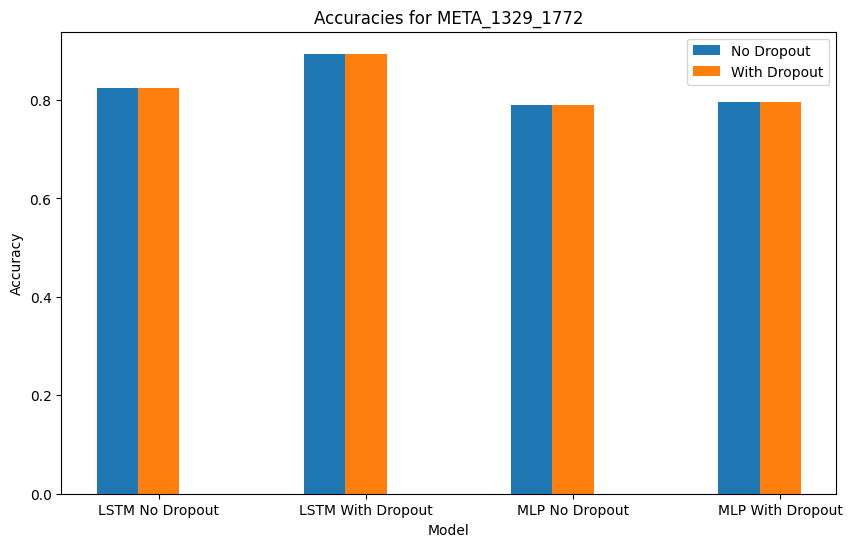


Results for META_1772_2215:
Accuracy LSTM without Dropout: 0.7005
Accuracy LSTM with Dropout: 0.7143
Accuracy MLP without Dropout: 0.8262
Accuracy MLP with Dropout: 0.7968


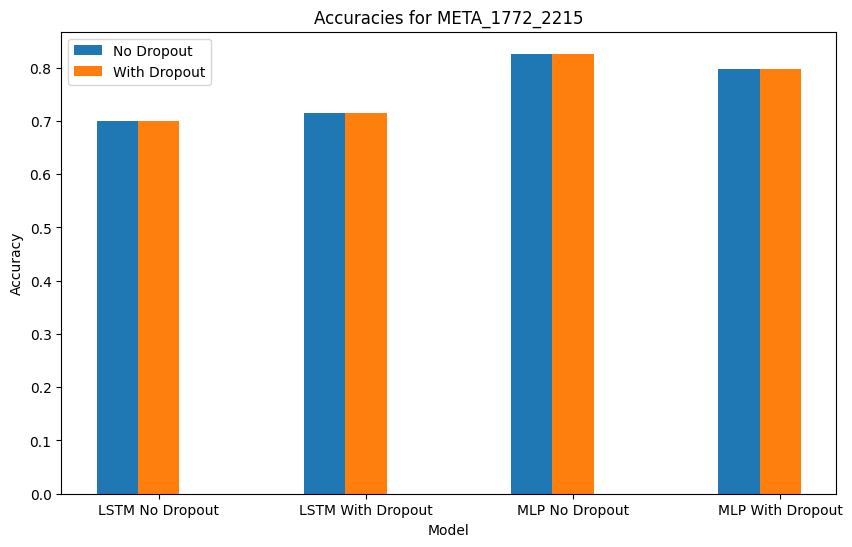


Results for META_2215_2658:
Accuracy LSTM without Dropout: 0.8756
Accuracy LSTM with Dropout: 0.9171
Accuracy MLP without Dropout: 0.8465
Accuracy MLP with Dropout: 0.8397


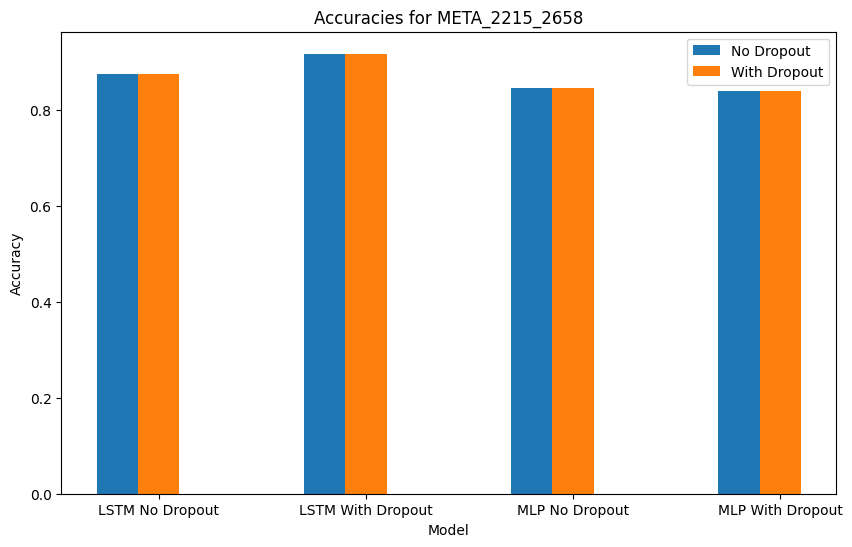


Results for AMZN_547_1089:
Accuracy LSTM without Dropout: 0.8874
Accuracy LSTM with Dropout: 0.8780
Accuracy MLP without Dropout: 0.7970
Accuracy MLP with Dropout: 0.7786


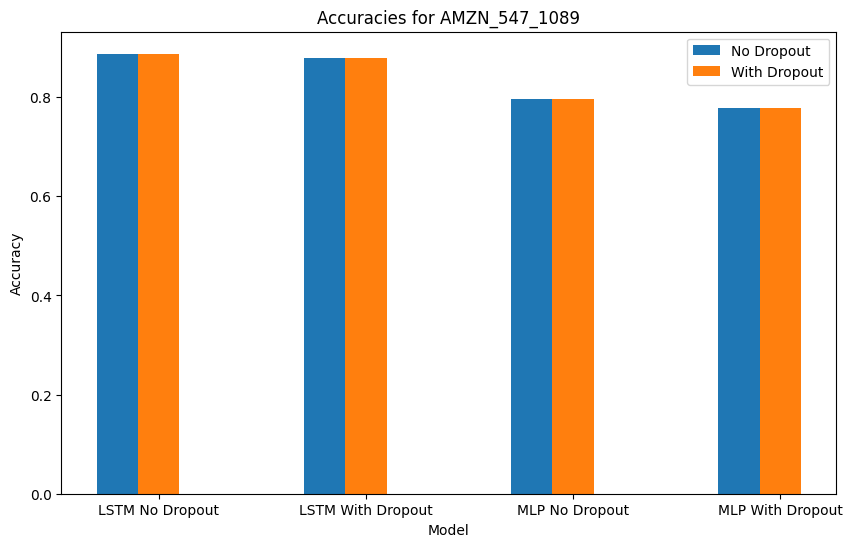


Results for AMZN_1089_1631:
Accuracy LSTM without Dropout: 0.9062
Accuracy LSTM with Dropout: 0.9099
Accuracy MLP without Dropout: 0.8137
Accuracy MLP with Dropout: 0.7731


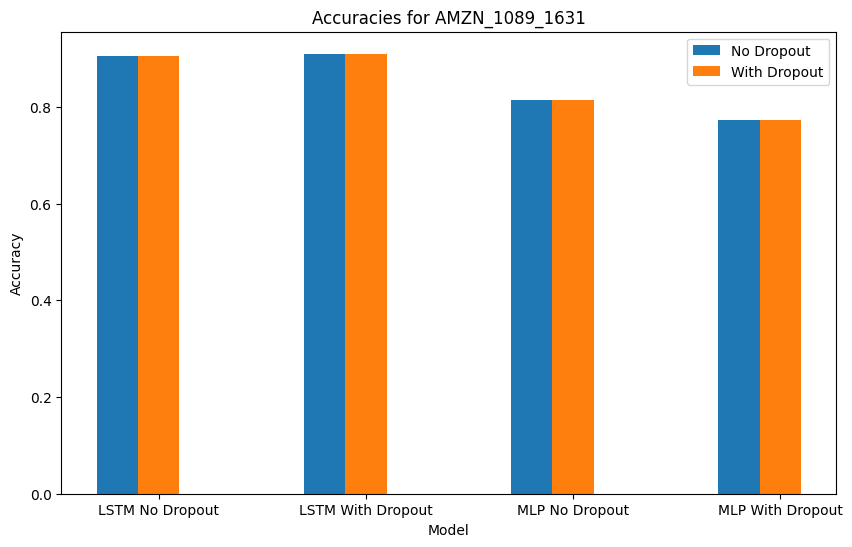


Results for AMZN_1631_2173:
Accuracy LSTM without Dropout: 0.8668
Accuracy LSTM with Dropout: 0.8912
Accuracy MLP without Dropout: 0.8210
Accuracy MLP with Dropout: 0.8173


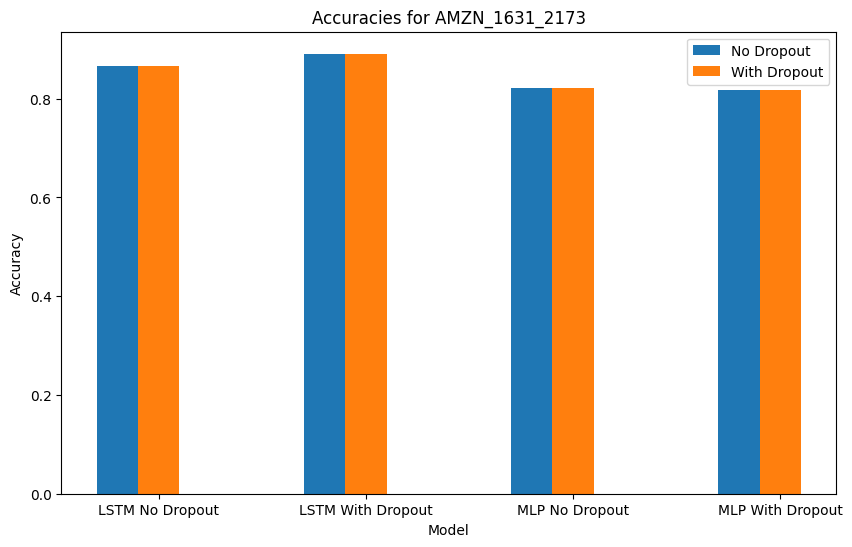


Results for AMZN_2173_2715:
Accuracy LSTM without Dropout: 0.8499
Accuracy LSTM with Dropout: 0.8874
Accuracy MLP without Dropout: 0.7491
Accuracy MLP with Dropout: 0.8007


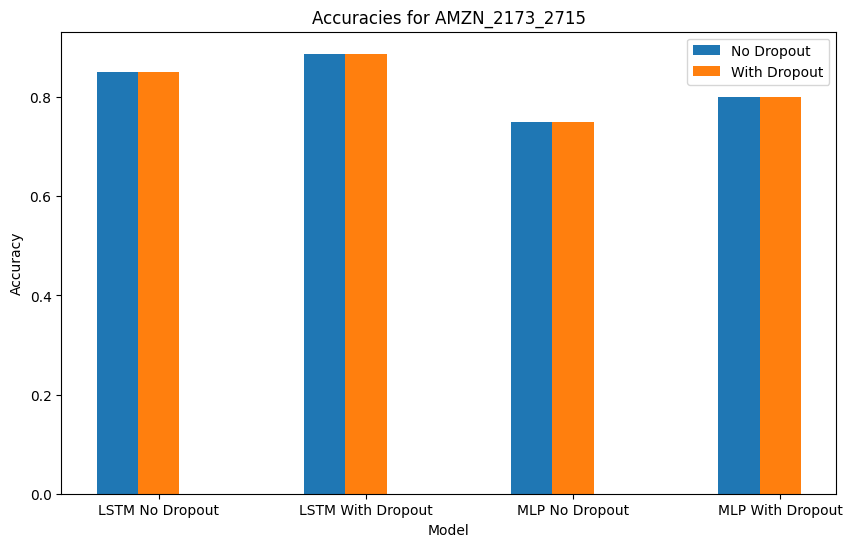


Results for AMZN_2715_3257:
Accuracy LSTM without Dropout: 0.9156
Accuracy LSTM with Dropout: 0.9137
Accuracy MLP without Dropout: 0.8303
Accuracy MLP with Dropout: 0.8376


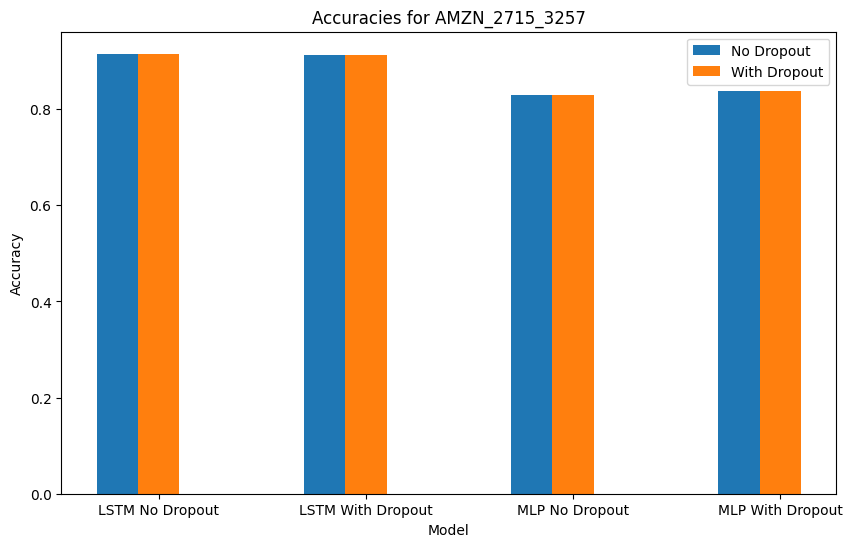


Results for MSFT_547_1089:
Accuracy LSTM without Dropout: 0.8912
Accuracy LSTM with Dropout: 0.9043
Accuracy MLP without Dropout: 0.7786
Accuracy MLP with Dropout: 0.8026


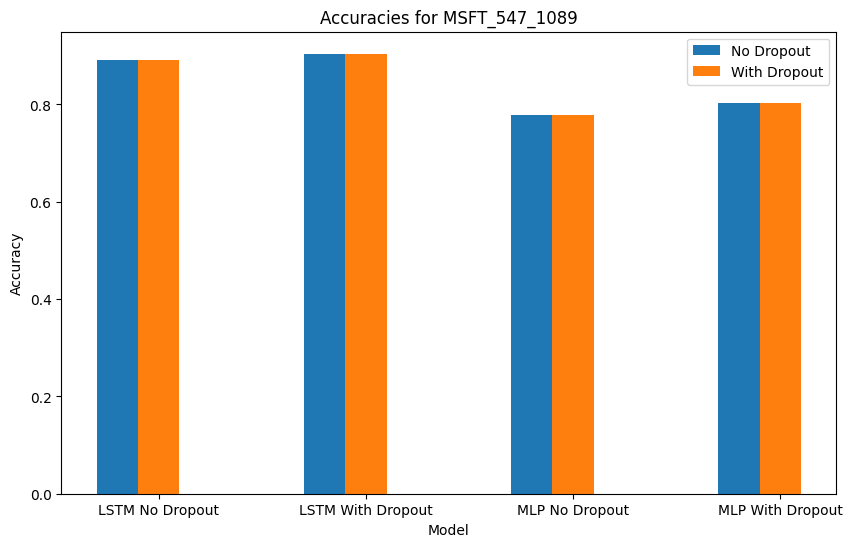


Results for MSFT_1089_1631:
Accuracy LSTM without Dropout: 0.8687
Accuracy LSTM with Dropout: 0.8931
Accuracy MLP without Dropout: 0.7860
Accuracy MLP with Dropout: 0.7878


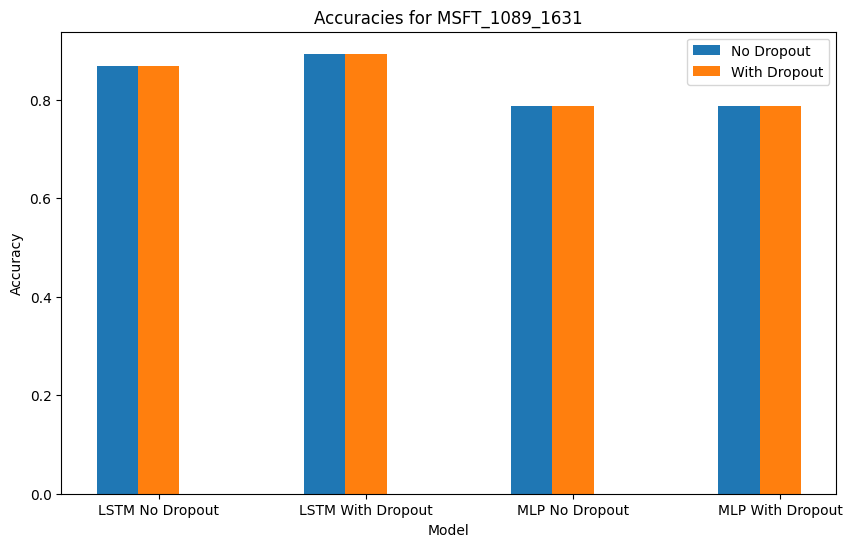


Results for MSFT_1631_2173:
Accuracy LSTM without Dropout: 0.8837
Accuracy LSTM with Dropout: 0.9212
Accuracy MLP without Dropout: 0.7952
Accuracy MLP with Dropout: 0.8081


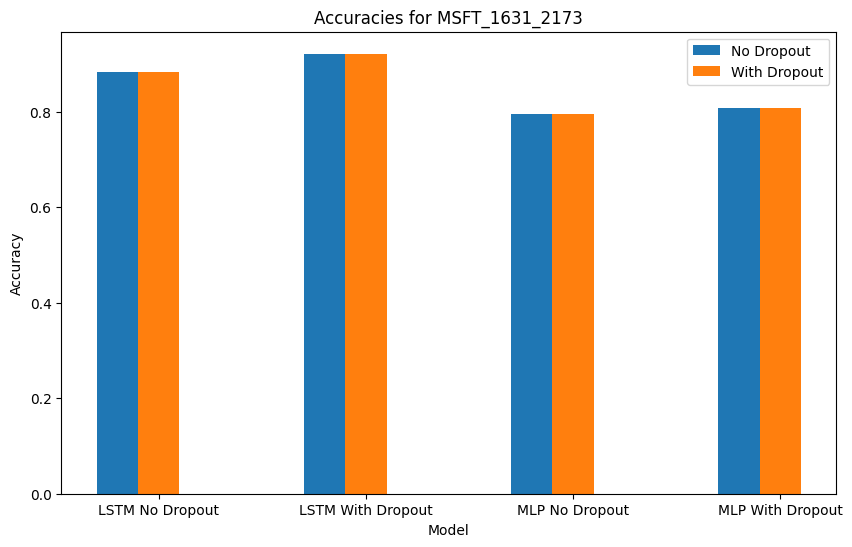


Results for MSFT_2173_2715:
Accuracy LSTM without Dropout: 0.7711
Accuracy LSTM with Dropout: 0.7373
Accuracy MLP without Dropout: 0.7934
Accuracy MLP with Dropout: 0.8266


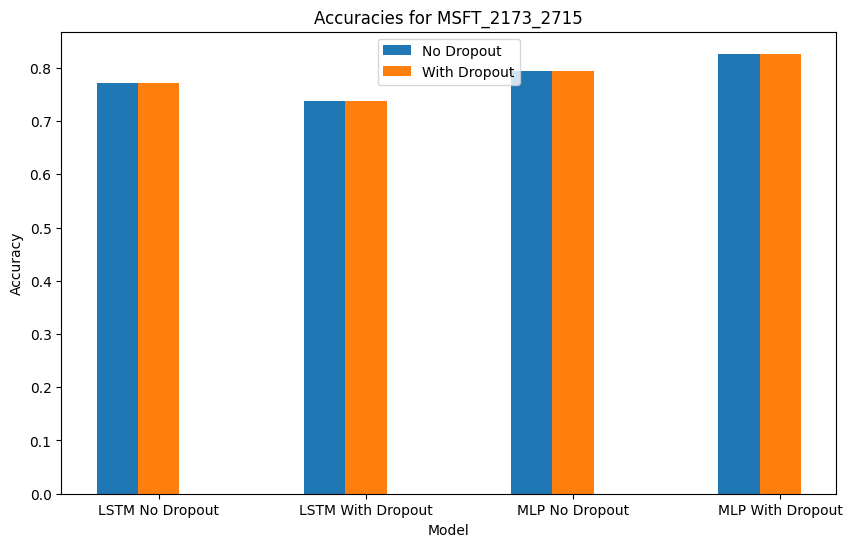


Results for MSFT_2715_3257:
Accuracy LSTM without Dropout: 0.8931
Accuracy LSTM with Dropout: 0.9024
Accuracy MLP without Dropout: 0.7915
Accuracy MLP with Dropout: 0.8284


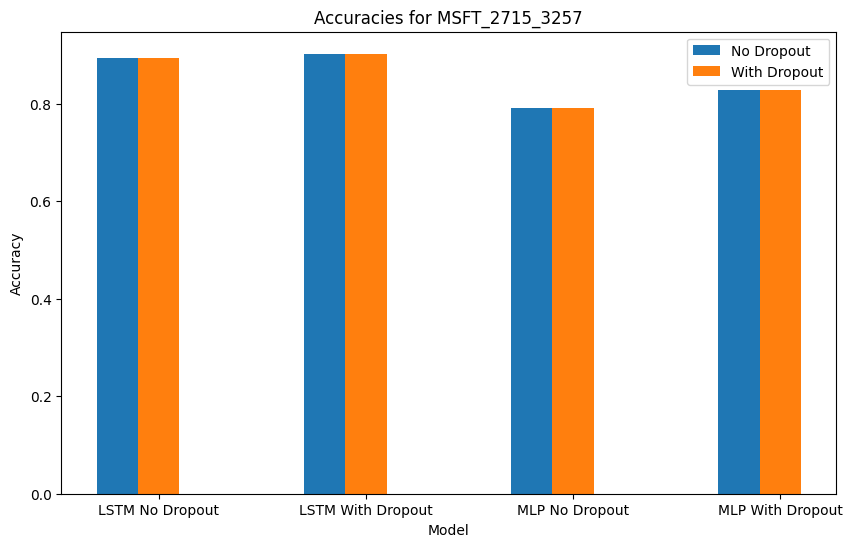


Results for GOOGL_547_1089:
Accuracy LSTM without Dropout: 0.8874
Accuracy LSTM with Dropout: 0.8799
Accuracy MLP without Dropout: 0.7417
Accuracy MLP with Dropout: 0.7103


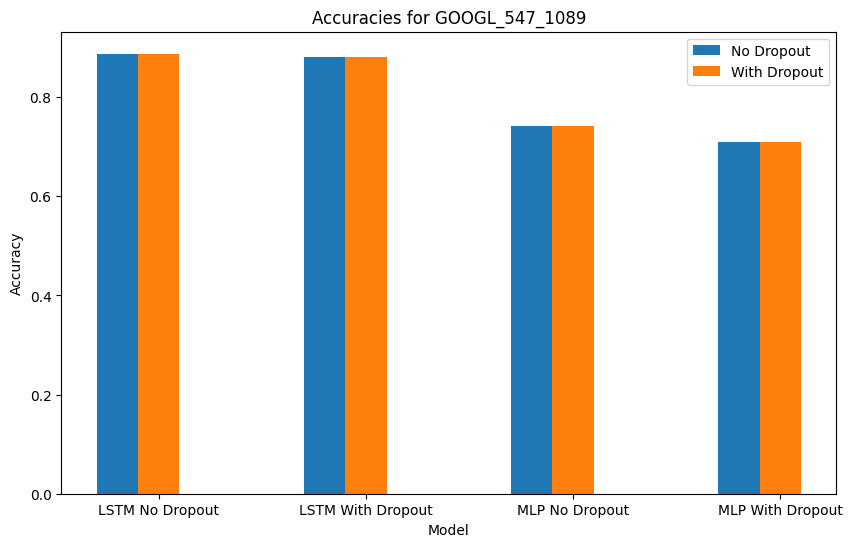


Results for GOOGL_1089_1631:
Accuracy LSTM without Dropout: 0.8949
Accuracy LSTM with Dropout: 0.9024
Accuracy MLP without Dropout: 0.8063
Accuracy MLP with Dropout: 0.7712


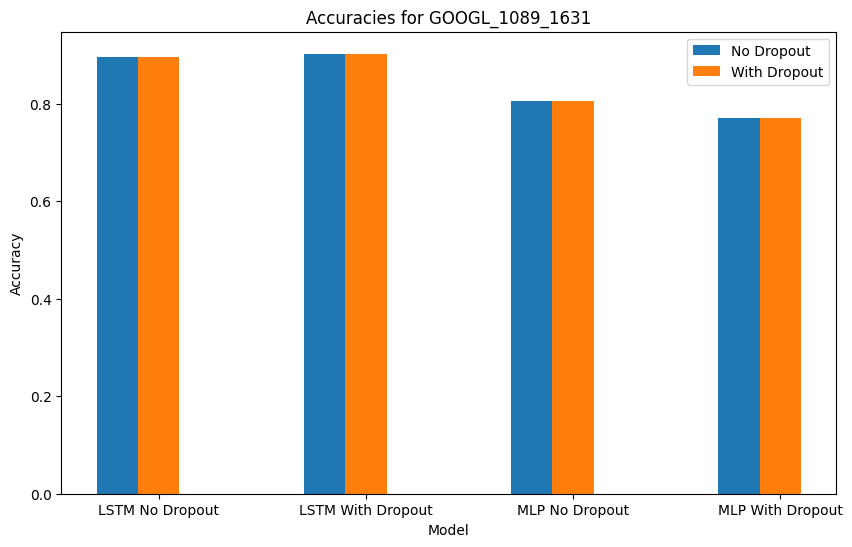


Results for GOOGL_1631_2173:
Accuracy LSTM without Dropout: 0.8931
Accuracy LSTM with Dropout: 0.8856
Accuracy MLP without Dropout: 0.8118
Accuracy MLP with Dropout: 0.8118


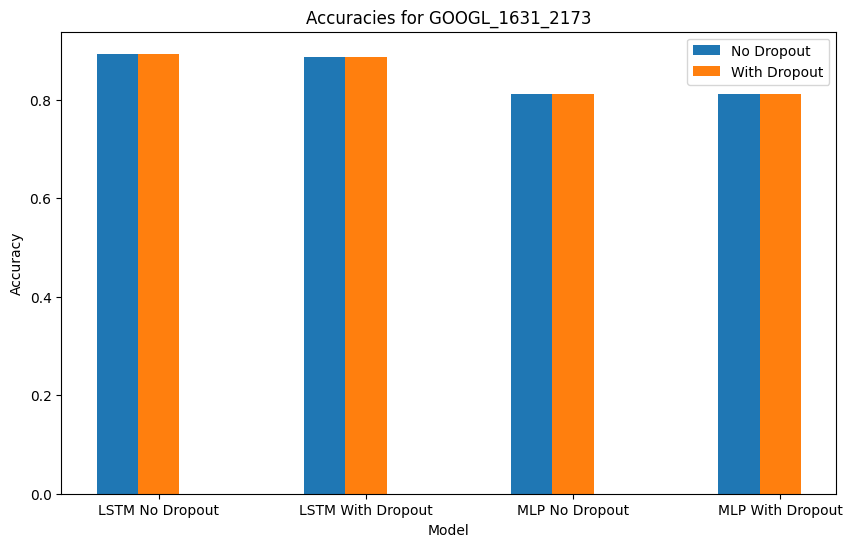


Results for GOOGL_2173_2715:
Accuracy LSTM without Dropout: 0.8780
Accuracy LSTM with Dropout: 0.8949
Accuracy MLP without Dropout: 0.8100
Accuracy MLP with Dropout: 0.8155


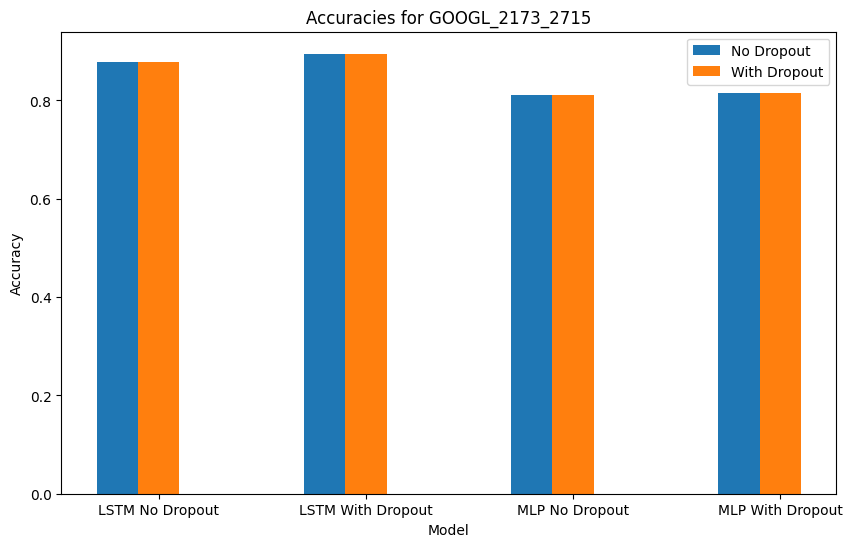


Results for GOOGL_2715_3257:
Accuracy LSTM without Dropout: 0.7992
Accuracy LSTM with Dropout: 0.8968
Accuracy MLP without Dropout: 0.8192
Accuracy MLP with Dropout: 0.8284


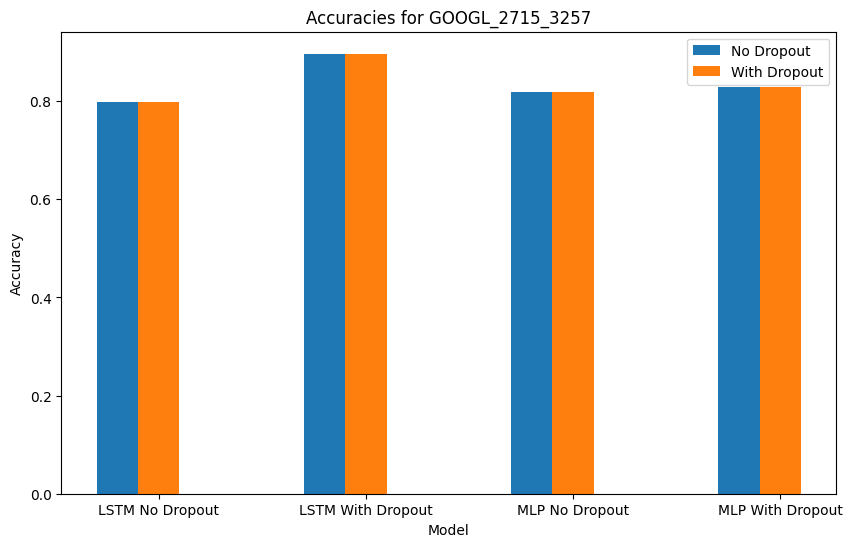

In [ ]:
import numpy as np

# Visualization
for key, value in results.items():
    print(f'\nResults for {key}:')
    print(f'Accuracy LSTM without Dropout: {value["accuracy_lstm_no_dropout"]:.4f}')
    print(f'Accuracy LSTM with Dropout: {value["accuracy_lstm_dropout"]:.4f}')
    print(f'Accuracy MLP without Dropout: {value["accuracy_mlp_no_dropout"]:.4f}')
    print(f'Accuracy MLP with Dropout: {value["accuracy_mlp_dropout"]:.4f}')

    # Plot accuracies with a grouped bar chart
    models = ['LSTM No Dropout', 'LSTM With Dropout', 'MLP No Dropout', 'MLP With Dropout']
    accuracies = [value['accuracy_lstm_no_dropout'], value['accuracy_lstm_dropout'], value['accuracy_mlp_no_dropout'], value['accuracy_mlp_dropout']]

    bar_width = 0.2
    index = np.arange(len(models))

    plt.figure(figsize=(10, 6))

    plt.bar(index - bar_width, accuracies, bar_width, label='No Dropout')
    plt.bar(index, accuracies, bar_width, label='With Dropout')

    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracies for {key}')
    plt.xticks(index, models)
    plt.legend()
    plt.show()


**1.3 Model_B (Walk-forward approach with purging and embargoing)**

In [ ]:
# Walk-forward approach with purging and embargoing
for train_indices, test_indices in tscv.split(features_scaled):
    train_start = int(train_indices[0])
    train_end = int(test_indices[0]) - 1
    test_start = int(test_indices[0])
    test_end = int(test_indices[-1])

    # Create sequences for LSTM
    sequence_length = 10  # Adjust as needed
    X_train_lstm, y_train_lstm = create_sequences(features_scaled[train_start:train_end + 1], target.iloc[train_start:train_end + 1], sequence_length)
    X_test_lstm, y_test_lstm = create_sequences(features_scaled[test_start:test_end + 1], target.iloc[test_start:test_end + 1], sequence_length)

    # Train LSTM model without dropout and early stopping
    model_lstm_no_dropout = train_model(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, build_lstm_model)

    # Train LSTM model with dropout and early stopping
    model_lstm_dropout = train_model_with_dropout_and_early_stopping(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, build_lstm_model_with_dropout_and_early_stopping)

    # Train MLP model without dropout and early stopping
    model_mlp_no_dropout = train_model(X_train, y_train, X_test, y_test, build_mlp_model)

    # Train MLP model with dropout and early stopping
    model_mlp_dropout = train_model_with_dropout_and_early_stopping(X_train, y_train, X_test, y_test, build_mlp_model_with_dropout_and_early_stopping)

    # Store results
    key = f'{symbol}_{train_start + 1}_{test_start + 1}'
    results[key] = {
        'accuracy_lstm_no_dropout': accuracy_score(y_test_lstm, (model_lstm_no_dropout.predict(X_test_lstm) > 0.5).astype(int)),
        'accuracy_lstm_dropout': accuracy_score(y_test_lstm, (model_lstm_dropout.predict(X_test_lstm) > 0.5).astype(int)),
        'accuracy_mlp_no_dropout': accuracy_score(y_test, (model_mlp_no_dropout.predict(X_test) > 0.5).astype(int)),
        'accuracy_mlp_dropout': accuracy_score(y_test, (model_mlp_dropout.predict(X_test) > 0.5).astype(int))
    }
# Print results
for key, value in results.items():
    print(f"\nResults for {key}:")
    print(f"Accuracy LSTM No Dropout: {value['accuracy_lstm_no_dropout']:.4f}")
    print(f"Accuracy LSTM With Dropout: {value['accuracy_lstm_dropout']:.4f}")
    print(f"Accuracy MLP No Dropout: {value['accuracy_mlp_no_dropout']:.4f}")
    print(f"Accuracy MLP With Dropout: {value['accuracy_mlp_dropout']:.4f}")



17/17 [==============================] - 0s 2ms/step

Results for AAPL_547_1089:
Accuracy LSTM No Dropout: 0.8724
Accuracy LSTM With Dropout: 0.8931
Accuracy MLP No Dropout: 0.7048
Accuracy MLP With Dropout: 0.7177

Results for AAPL_1089_1631:
Accuracy LSTM No Dropout: 0.9137
Accuracy LSTM With Dropout: 0.9231
Accuracy MLP No Dropout: 0.7952
Accuracy MLP With Dropout: 0.7952

Results for AAPL_1631_2173:
Accuracy LSTM No Dropout: 0.9137
Accuracy LSTM With Dropout: 0.9400
Accuracy MLP No Dropout: 0.8026
Accuracy MLP With Dropout: 0.7694

Results for AAPL_2173_2715:
Accuracy LSTM No Dropout: 0.8368
Accuracy LSTM With Dropout: 0.8443
Accuracy MLP No Dropout: 0.7435
Accuracy MLP With Dropout: 0.8044

Results for AAPL_2715_3257:
Accuracy LSTM No Dropout: 0.8931
Accuracy LSTM With Dropout: 0.9062
Accuracy MLP No Dropout: 0.8173
Accuracy MLP With Dropout: 0.8137

Results for META_443_886:
Accuracy LSTM No Dropout: 0.8848
Accuracy LSTM With Dropout: 0.9032
Accuracy MLP No Dropout: 0.7314
Accura

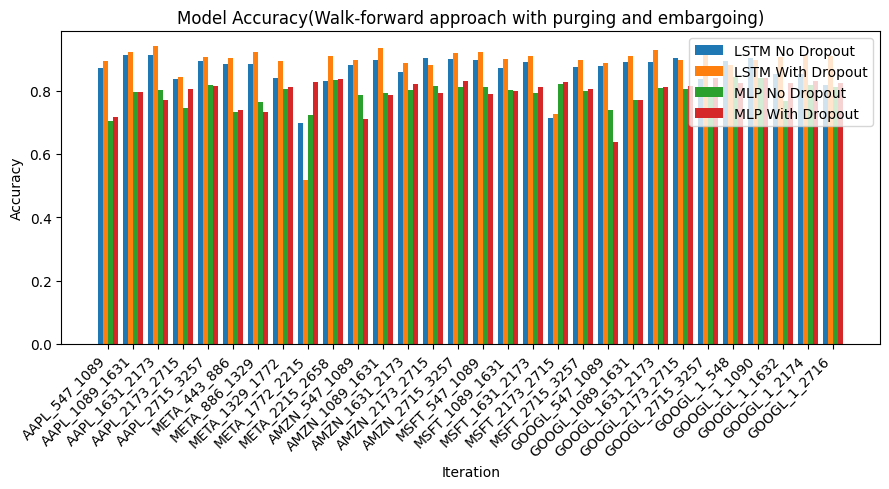

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract model names and accuracy scores from results
model_names = ['LSTM No Dropout', 'LSTM With Dropout', 'MLP No Dropout', 'MLP With Dropout']
accuracy_scores = np.array([[value[f'accuracy_lstm_no_dropout'] for value in results.values()],
                            [value[f'accuracy_lstm_dropout'] for value in results.values()],
                            [value[f'accuracy_mlp_no_dropout'] for value in results.values()],
                            [value[f'accuracy_mlp_dropout'] for value in results.values()]])

# Plotting
bar_width = 0.2
index = np.arange(len(results))

fig, ax = plt.subplots(figsize=(9, 5))

for i, model_name in enumerate(model_names):
    ax.bar(index + i * bar_width, accuracy_scores[i], bar_width, label=model_name)

ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy(Walk-forward approach with purging and embargoing)')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels([key for key in results.keys()], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


Results for AAPL_547_1089:
Accuracy LSTM without Dropout: 0.8762
Accuracy LSTM with Dropout: 0.8968
Accuracy MLP without Dropout: 0.7085
Accuracy MLP with Dropout: 0.7601


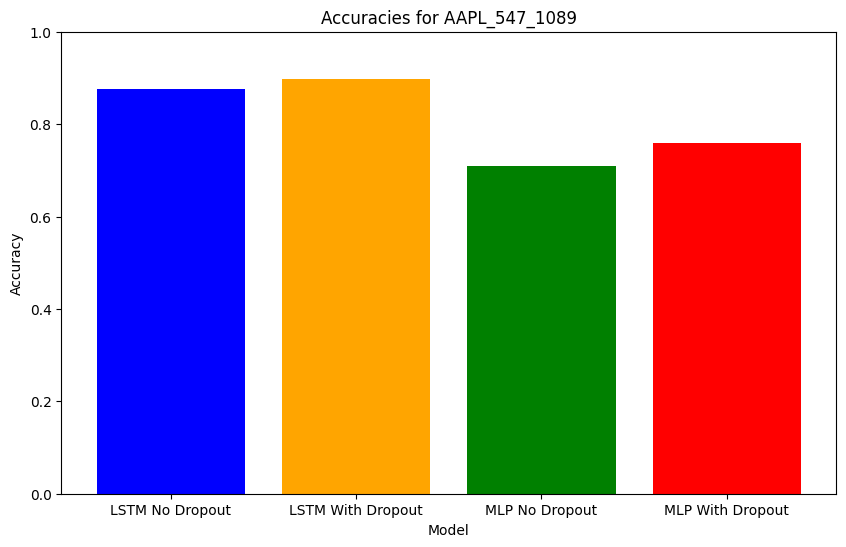


Results for AAPL_1089_1631:
Accuracy LSTM without Dropout: 0.9024
Accuracy LSTM with Dropout: 0.9193
Accuracy MLP without Dropout: 0.8007
Accuracy MLP with Dropout: 0.8100


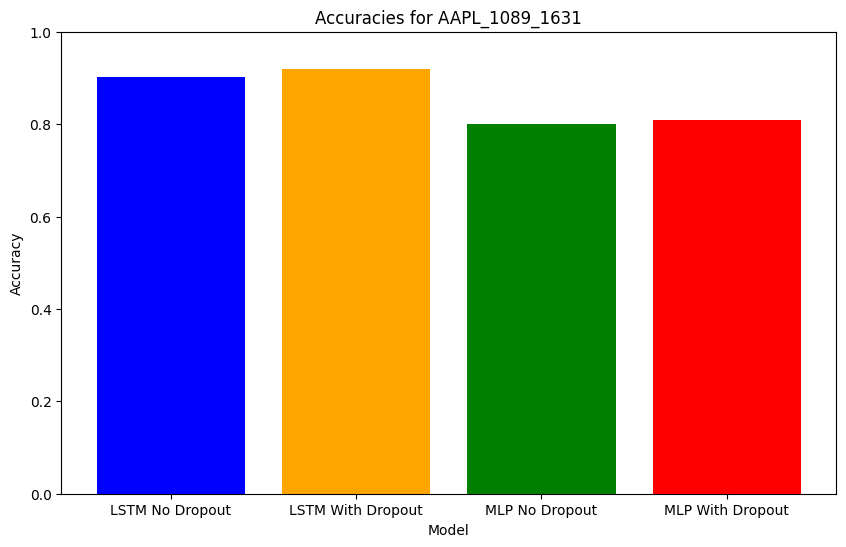


Results for AAPL_1631_2173:
Accuracy LSTM without Dropout: 0.9043
Accuracy LSTM with Dropout: 0.9400
Accuracy MLP without Dropout: 0.7583
Accuracy MLP with Dropout: 0.8007


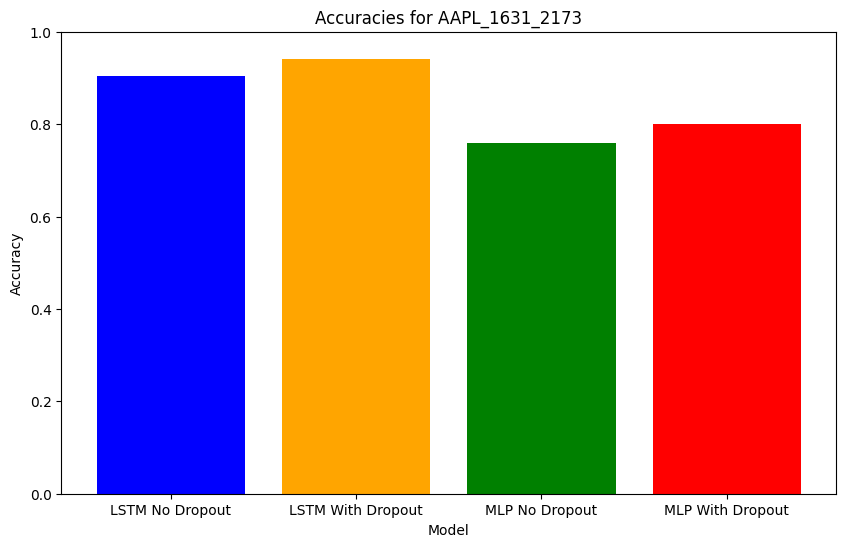


Results for AAPL_2173_2715:
Accuracy LSTM without Dropout: 0.8630
Accuracy LSTM with Dropout: 0.8218
Accuracy MLP without Dropout: 0.8137
Accuracy MLP with Dropout: 0.7934


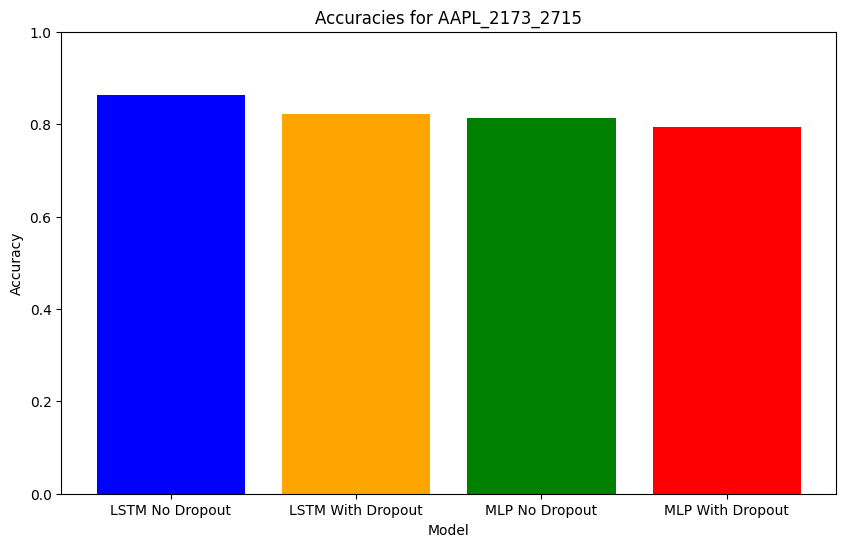


Results for AAPL_2715_3257:
Accuracy LSTM without Dropout: 0.8555
Accuracy LSTM with Dropout: 0.9174
Accuracy MLP without Dropout: 0.7934
Accuracy MLP with Dropout: 0.8229


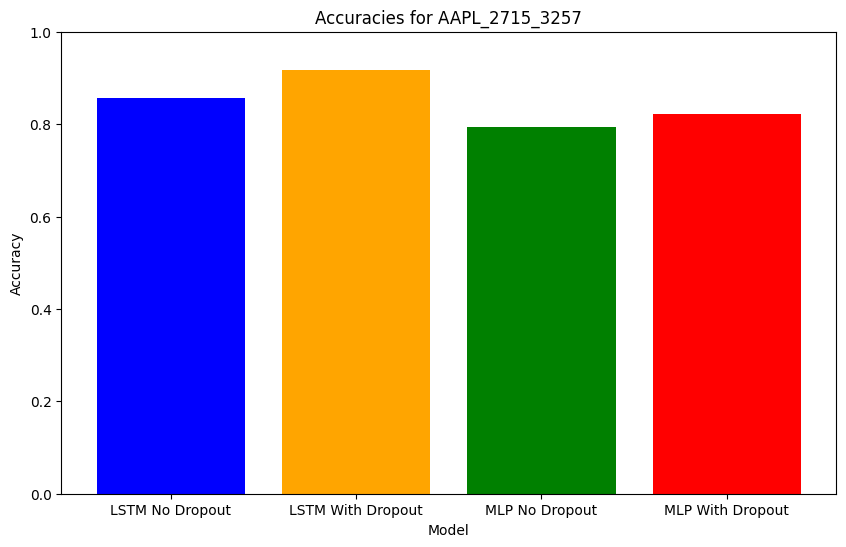


Results for META_443_886:
Accuracy LSTM without Dropout: 0.8733
Accuracy LSTM with Dropout: 0.8940
Accuracy MLP without Dropout: 0.7517
Accuracy MLP with Dropout: 0.7133


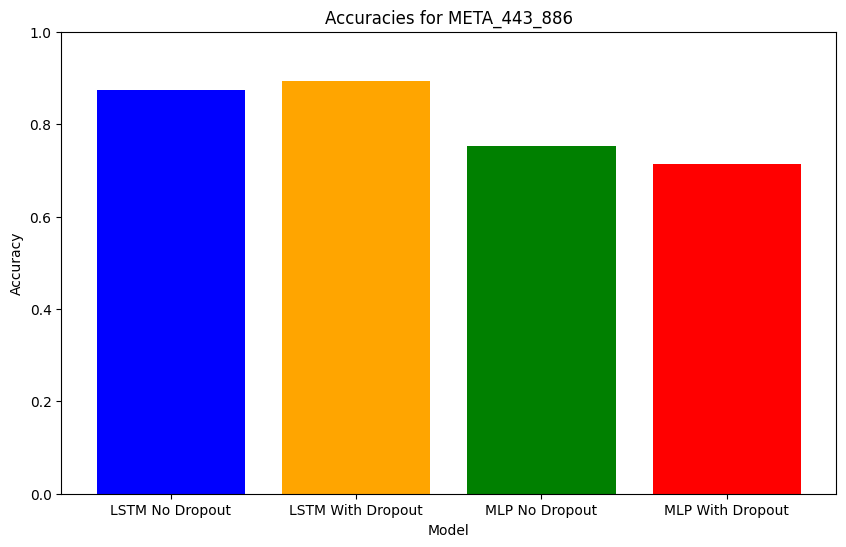


Results for META_886_1329:
Accuracy LSTM without Dropout: 0.8664
Accuracy LSTM with Dropout: 0.9217
Accuracy MLP without Dropout: 0.7765
Accuracy MLP with Dropout: 0.7585


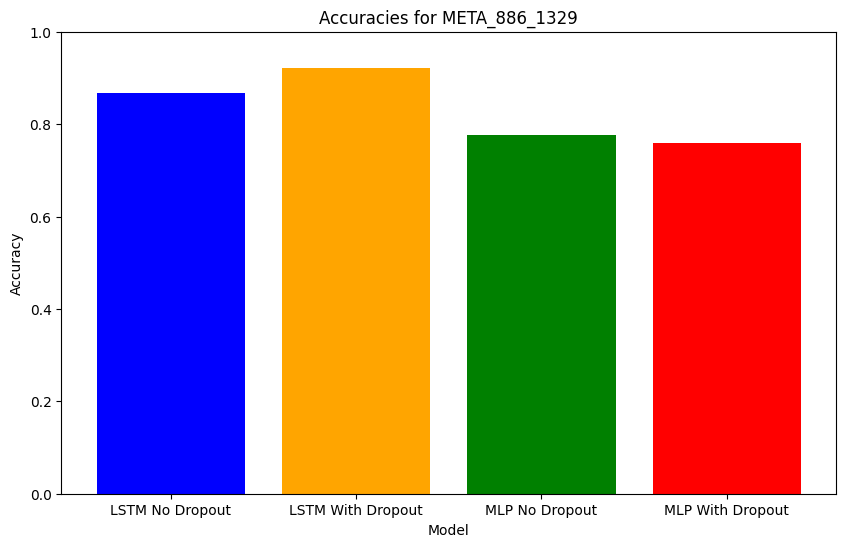


Results for META_1329_1772:
Accuracy LSTM without Dropout: 0.8479
Accuracy LSTM with Dropout: 0.8986
Accuracy MLP without Dropout: 0.7743
Accuracy MLP with Dropout: 0.7833


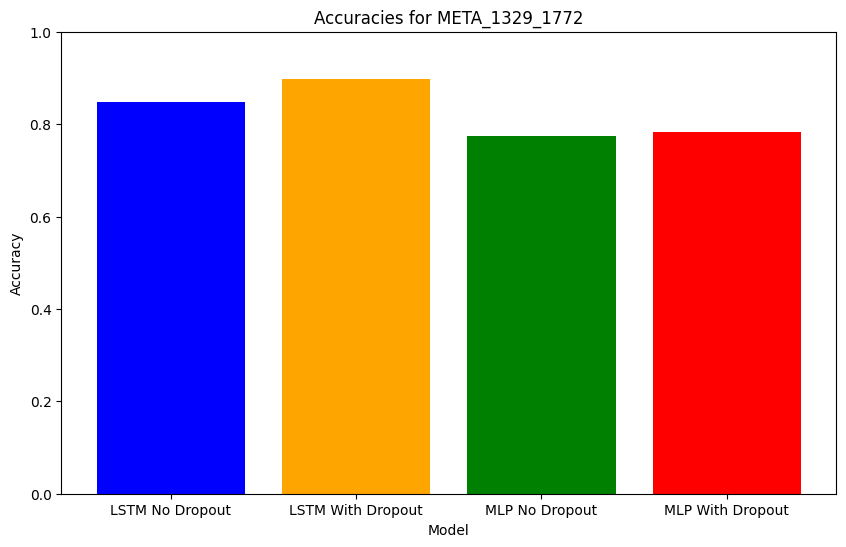


Results for META_1772_2215:
Accuracy LSTM without Dropout: 0.6452
Accuracy LSTM with Dropout: 0.7627
Accuracy MLP without Dropout: 0.8149
Accuracy MLP with Dropout: 0.8239


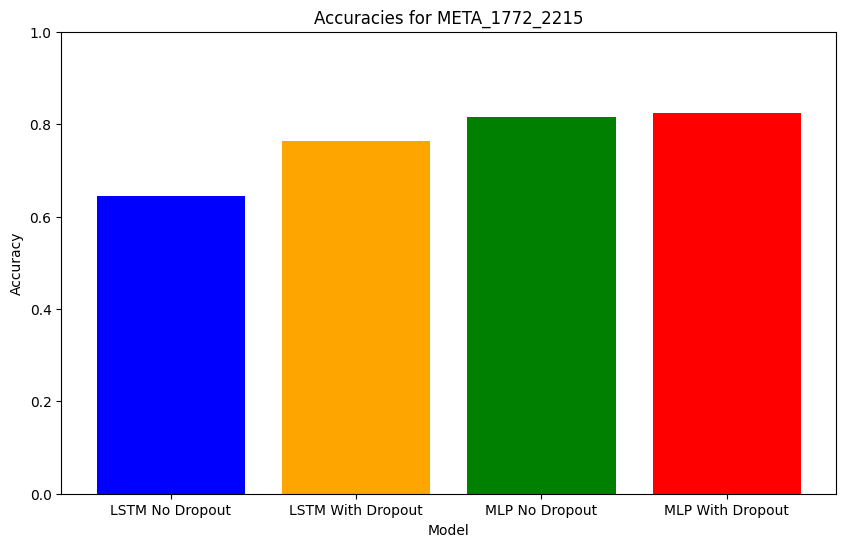


Results for META_2215_2658:
Accuracy LSTM without Dropout: 0.8641
Accuracy LSTM with Dropout: 0.9147
Accuracy MLP without Dropout: 0.8442
Accuracy MLP with Dropout: 0.8442


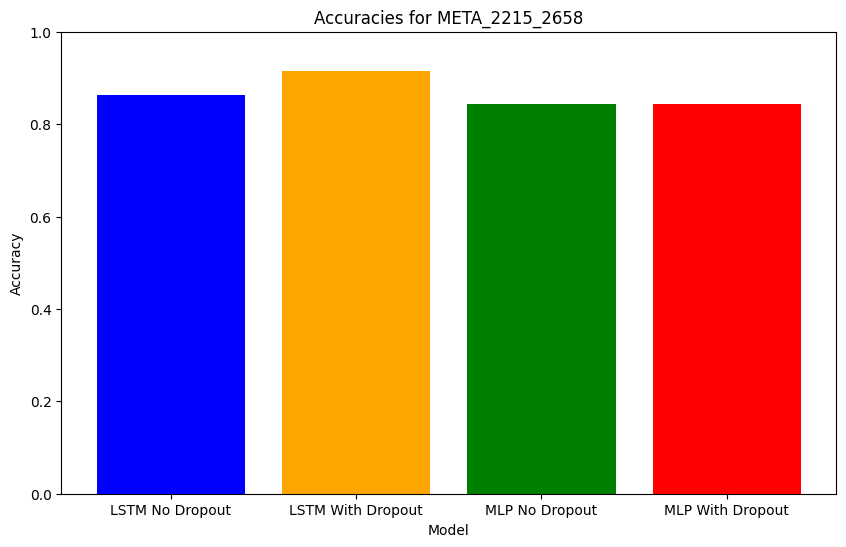


Results for AMZN_547_1089:
Accuracy LSTM without Dropout: 0.8856
Accuracy LSTM with Dropout: 0.8837
Accuracy MLP without Dropout: 0.7970
Accuracy MLP with Dropout: 0.7066


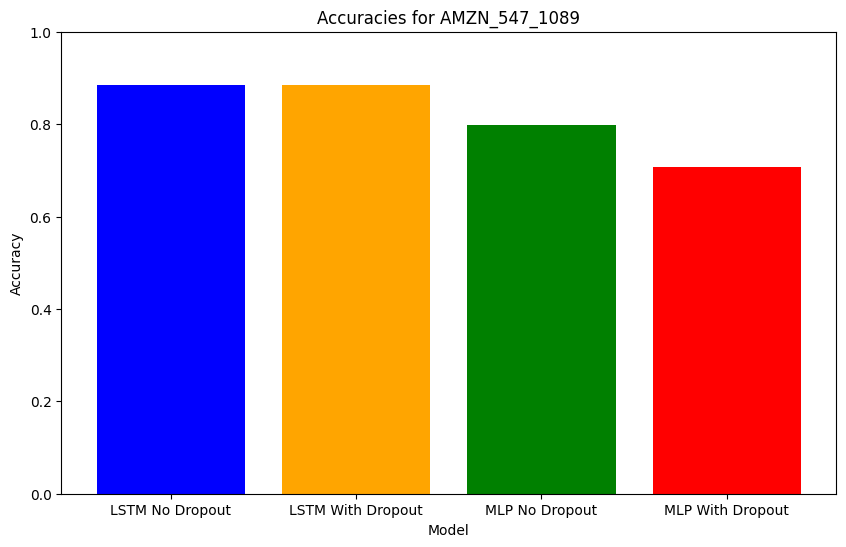


Results for AMZN_1089_1631:
Accuracy LSTM without Dropout: 0.9268
Accuracy LSTM with Dropout: 0.9231
Accuracy MLP without Dropout: 0.8044
Accuracy MLP with Dropout: 0.7601


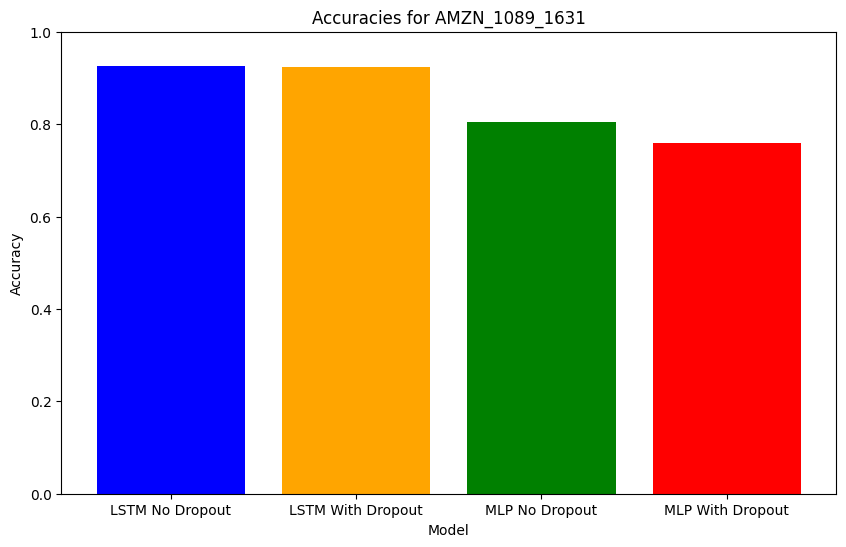


Results for AMZN_1631_2173:
Accuracy LSTM without Dropout: 0.8612
Accuracy LSTM with Dropout: 0.8874
Accuracy MLP without Dropout: 0.8044
Accuracy MLP with Dropout: 0.8173


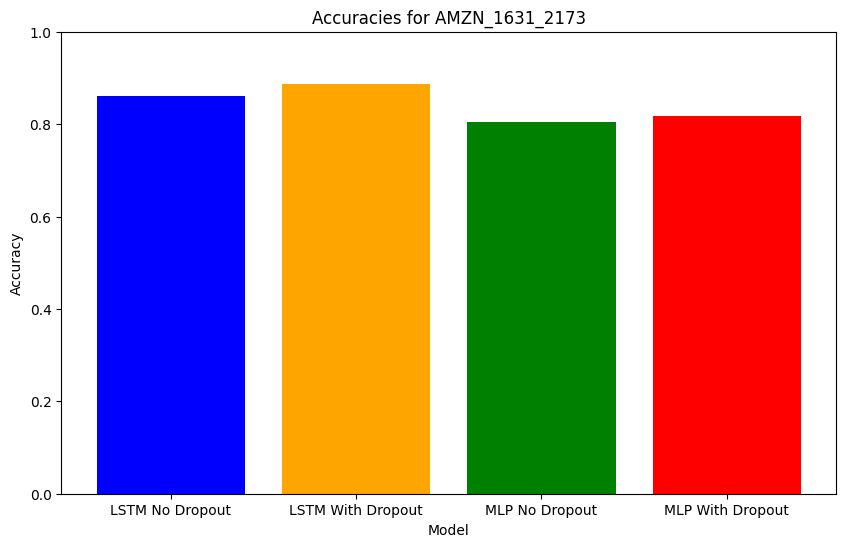


Results for AMZN_2173_2715:
Accuracy LSTM without Dropout: 0.8330
Accuracy LSTM with Dropout: 0.8724
Accuracy MLP without Dropout: 0.7841
Accuracy MLP with Dropout: 0.8100


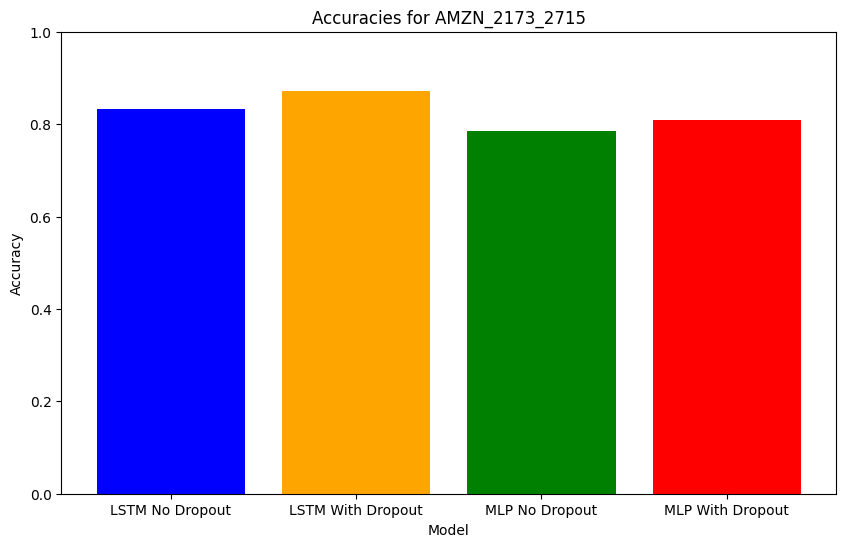


Results for AMZN_2715_3257:
Accuracy LSTM without Dropout: 0.8912
Accuracy LSTM with Dropout: 0.9250
Accuracy MLP without Dropout: 0.8321
Accuracy MLP with Dropout: 0.8321


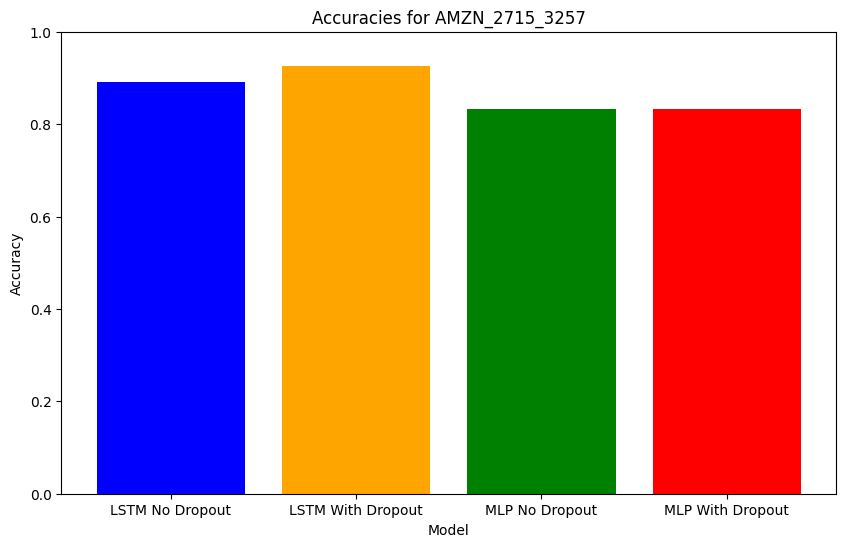


Results for MSFT_547_1089:
Accuracy LSTM without Dropout: 0.9062
Accuracy LSTM with Dropout: 0.9043
Accuracy MLP without Dropout: 0.7952
Accuracy MLP with Dropout: 0.7288


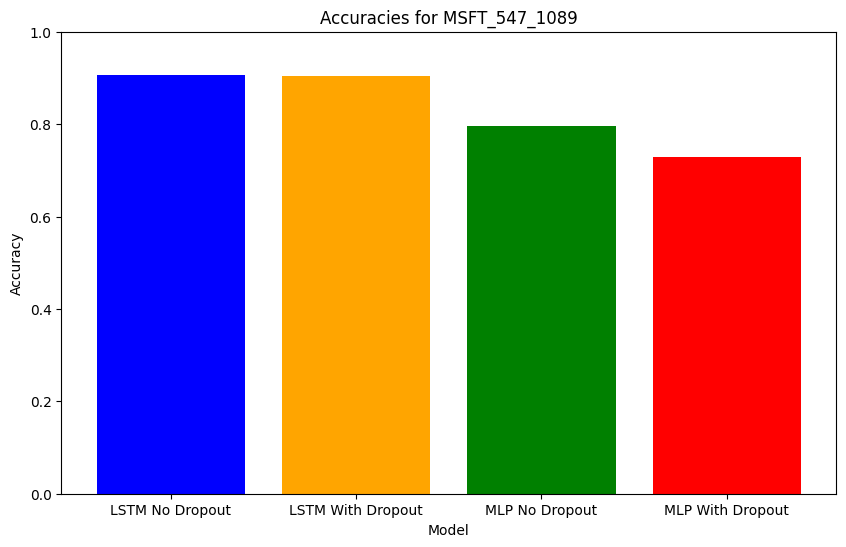


Results for MSFT_1089_1631:
Accuracy LSTM without Dropout: 0.8649
Accuracy LSTM with Dropout: 0.9024
Accuracy MLP without Dropout: 0.8007
Accuracy MLP with Dropout: 0.7841


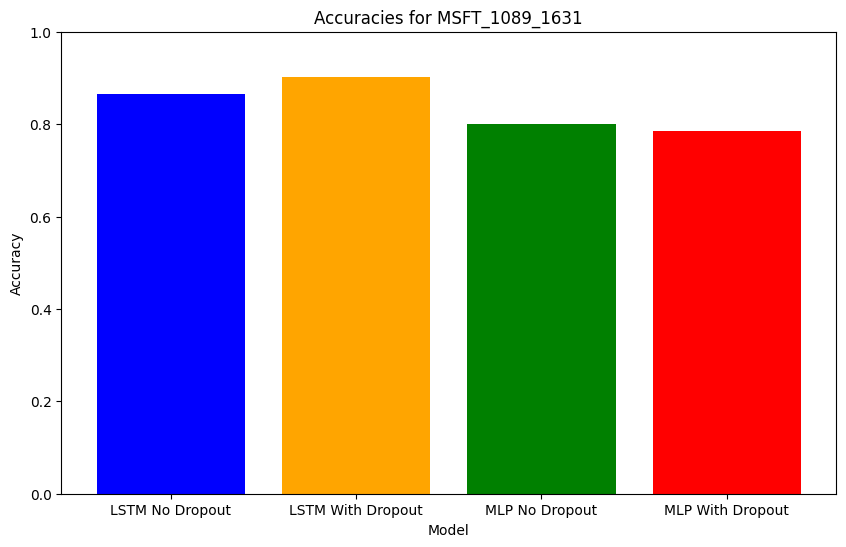


Results for MSFT_1631_2173:
Accuracy LSTM without Dropout: 0.8874
Accuracy LSTM with Dropout: 0.9250
Accuracy MLP without Dropout: 0.7897
Accuracy MLP with Dropout: 0.8155


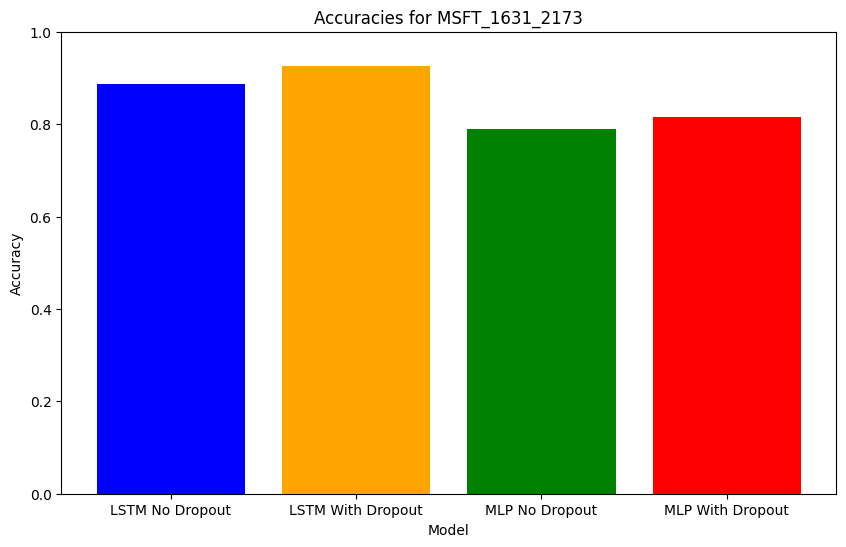


Results for MSFT_2173_2715:
Accuracy LSTM without Dropout: 0.7711
Accuracy LSTM with Dropout: 0.7842
Accuracy MLP without Dropout: 0.7970
Accuracy MLP with Dropout: 0.8395


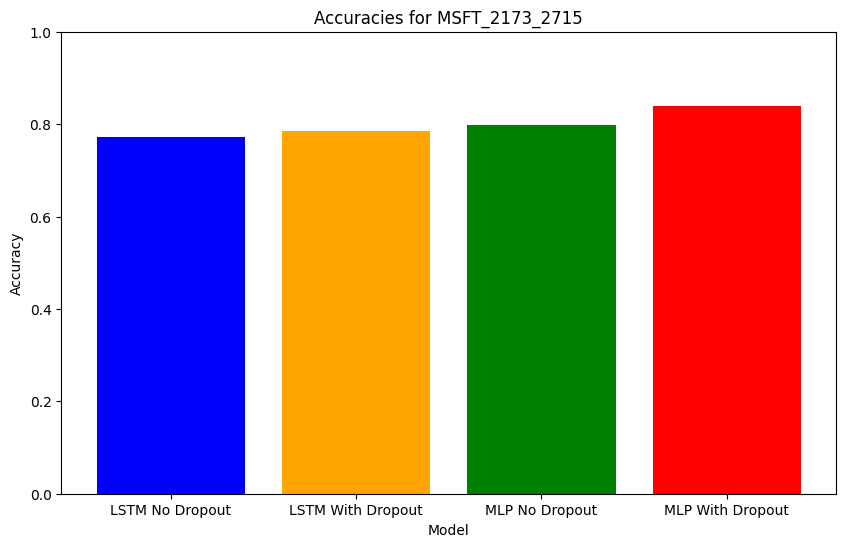


Results for MSFT_2715_3257:
Accuracy LSTM without Dropout: 0.8593
Accuracy LSTM with Dropout: 0.8949
Accuracy MLP without Dropout: 0.7675
Accuracy MLP with Dropout: 0.8469


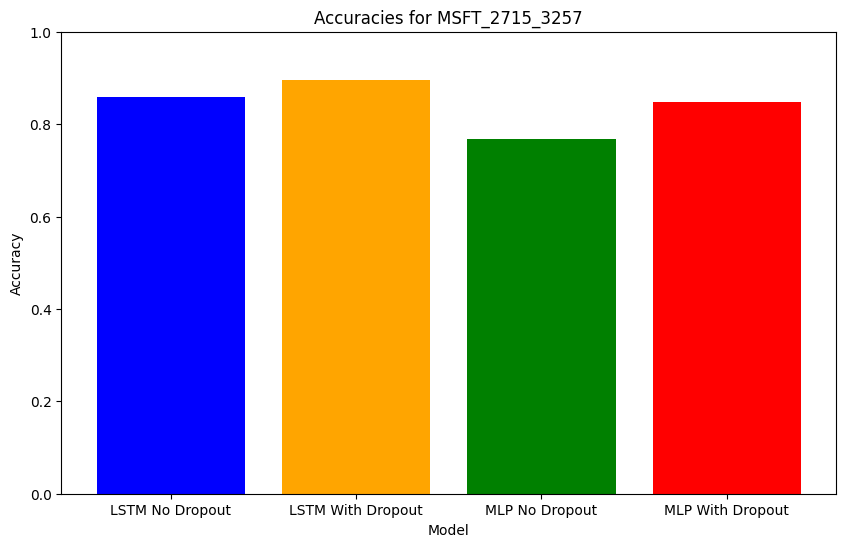


Results for GOOGL_547_1089:
Accuracy LSTM without Dropout: 0.8818
Accuracy LSTM with Dropout: 0.8874
Accuracy MLP without Dropout: 0.7122
Accuracy MLP with Dropout: 0.7343


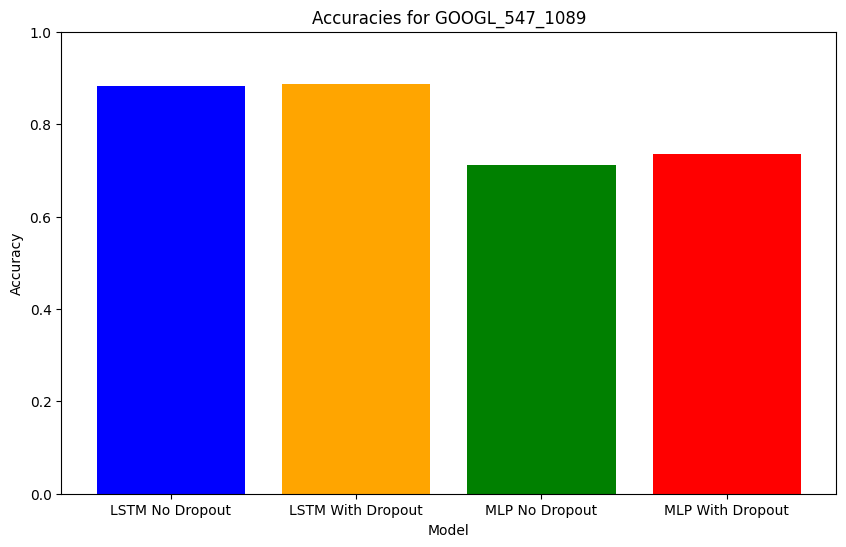


Results for GOOGL_1089_1631:
Accuracy LSTM without Dropout: 0.8743
Accuracy LSTM with Dropout: 0.9062
Accuracy MLP without Dropout: 0.7915
Accuracy MLP with Dropout: 0.7915


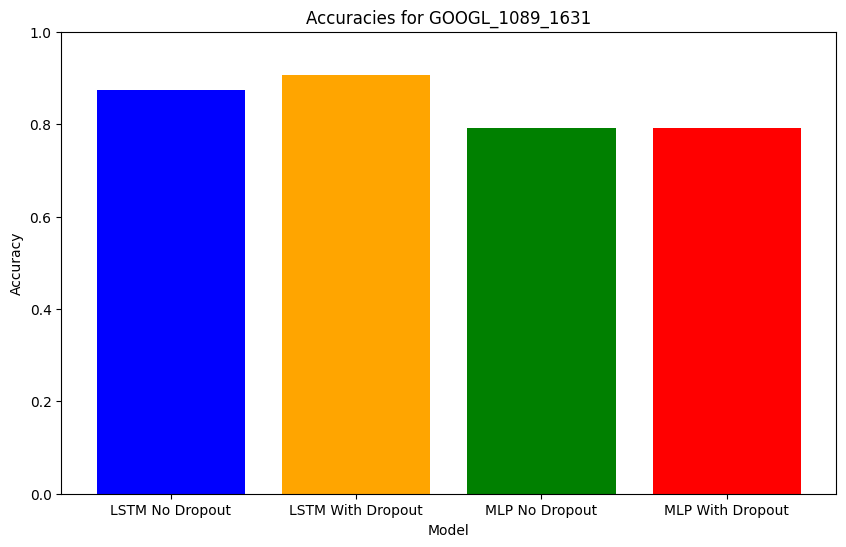


Results for GOOGL_1631_2173:
Accuracy LSTM without Dropout: 0.8931
Accuracy LSTM with Dropout: 0.8856
Accuracy MLP without Dropout: 0.8192
Accuracy MLP with Dropout: 0.8155


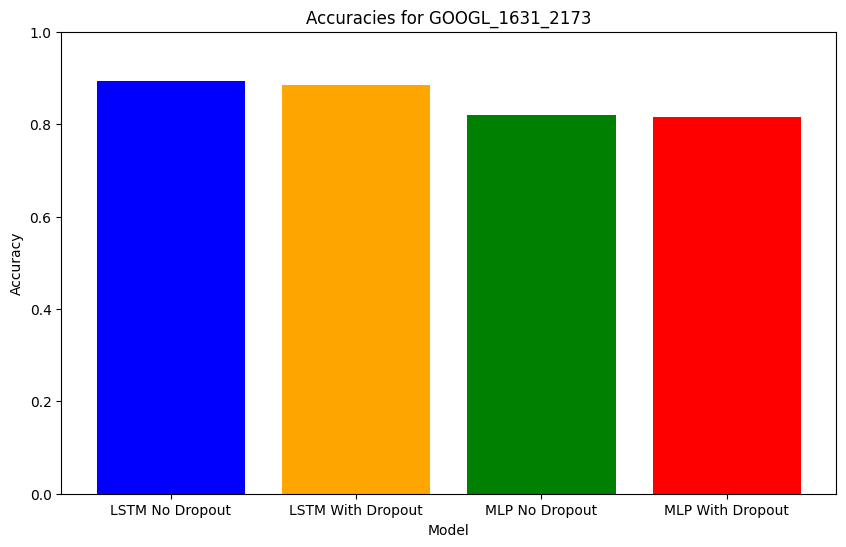


Results for GOOGL_2173_2715:
Accuracy LSTM without Dropout: 0.8762
Accuracy LSTM with Dropout: 0.9043
Accuracy MLP without Dropout: 0.8081
Accuracy MLP with Dropout: 0.8063


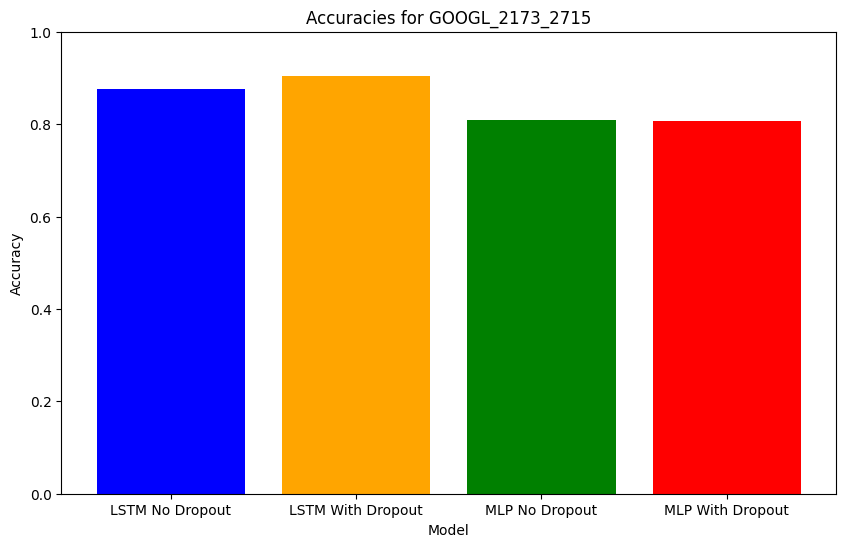


Results for GOOGL_2715_3257:
Accuracy LSTM without Dropout: 0.8724
Accuracy LSTM with Dropout: 0.8837
Accuracy MLP without Dropout: 0.8044
Accuracy MLP with Dropout: 0.8229


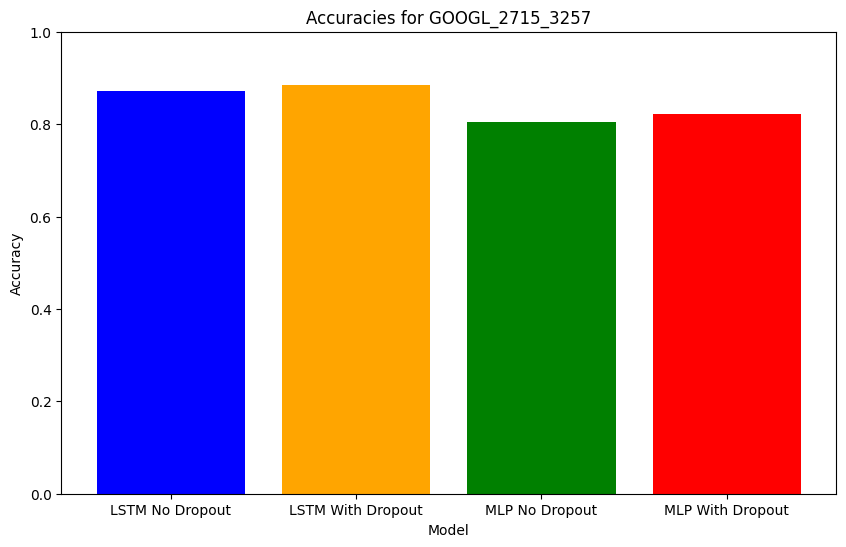


Results for GOOGL_1_548:
Accuracy LSTM without Dropout: 0.8780
Accuracy LSTM with Dropout: 0.8874
Accuracy MLP without Dropout: 0.7934
Accuracy MLP with Dropout: 0.8247


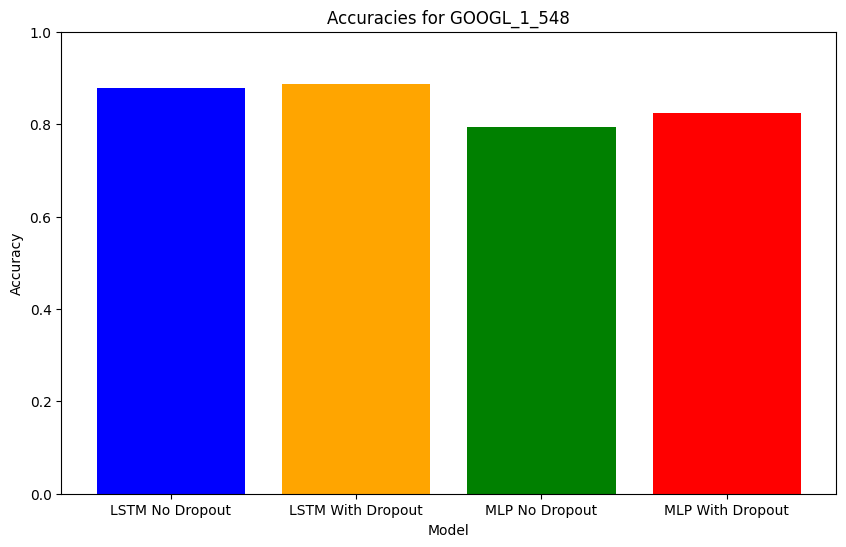


Results for GOOGL_1_1090:
Accuracy LSTM without Dropout: 0.8687
Accuracy LSTM with Dropout: 0.9006
Accuracy MLP without Dropout: 0.8044
Accuracy MLP with Dropout: 0.8339


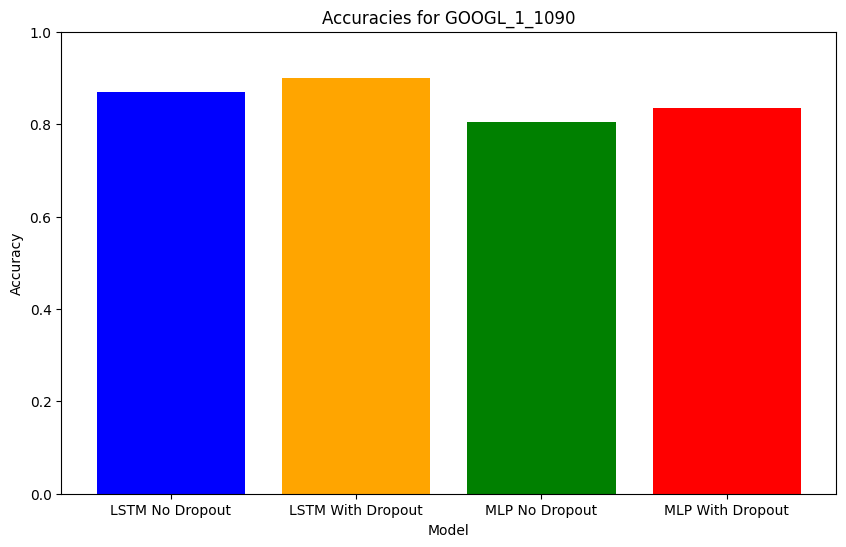


Results for GOOGL_1_1632:
Accuracy LSTM without Dropout: 0.8856
Accuracy LSTM with Dropout: 0.8931
Accuracy MLP without Dropout: 0.8303
Accuracy MLP with Dropout: 0.8376


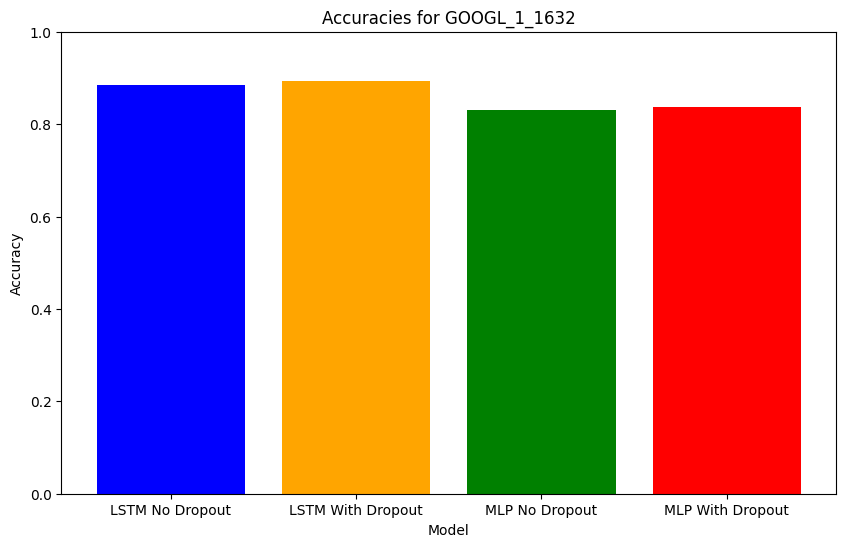


Results for GOOGL_1_2174:
Accuracy LSTM without Dropout: 0.8649
Accuracy LSTM with Dropout: 0.9156
Accuracy MLP without Dropout: 0.8044
Accuracy MLP with Dropout: 0.8229


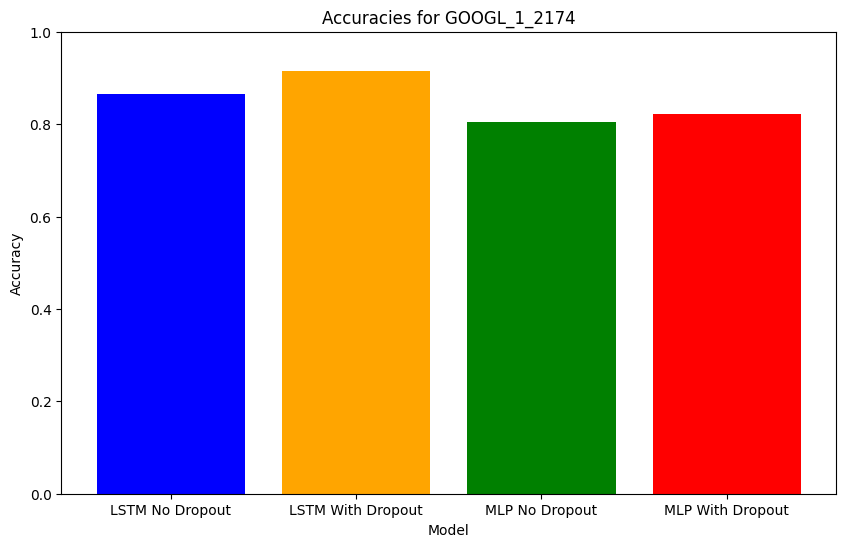


Results for GOOGL_1_2716:
Accuracy LSTM without Dropout: 0.8255
Accuracy LSTM with Dropout: 0.9024
Accuracy MLP without Dropout: 0.8321
Accuracy MLP with Dropout: 0.8358


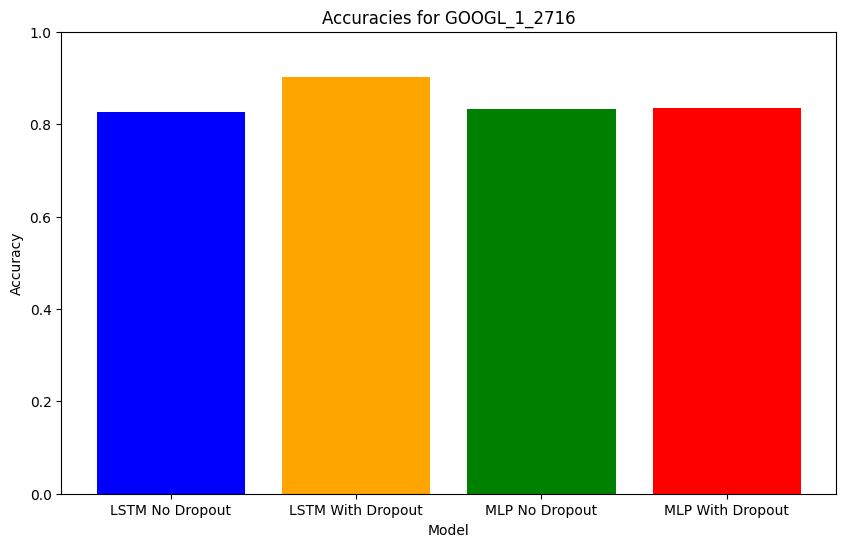

In [ ]:
# Visualization
for key, value in results.items():
    print(f'\nResults for {key}:')
    print(f'Accuracy LSTM without Dropout: {value["accuracy_lstm_no_dropout"]:.4f}')
    print(f'Accuracy LSTM with Dropout: {value["accuracy_lstm_dropout"]:.4f}')
    print(f'Accuracy MLP without Dropout: {value["accuracy_mlp_no_dropout"]:.4f}')
    print(f'Accuracy MLP with Dropout: {value["accuracy_mlp_dropout"]:.4f}')

    # Plot accuracies with a bar chart
    models = ['LSTM No Dropout', 'LSTM With Dropout', 'MLP No Dropout', 'MLP With Dropout']
    accuracies = [value['accuracy_lstm_no_dropout'], value['accuracy_lstm_dropout'], value['accuracy_mlp_no_dropout'], value['accuracy_mlp_dropout']]

    plt.figure(figsize=(10, 6))
    plt.bar(models, accuracies, color=['blue', 'orange', 'green', 'red'])
    plt.title(f'Accuracies for {key}')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy
    plt.show()


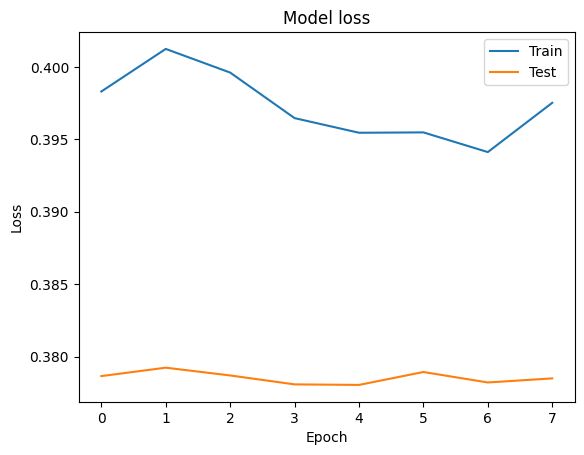

In [ ]:
import matplotlib.pyplot as plt

history = model_mlp.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping_mlp], verbose=0)

# Plotting the learning curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()



Results for AAPL_547_1089:
Accuracy LSTM without Dropout: 0.8762
Accuracy LSTM with Dropout: 0.8968
Accuracy MLP without Dropout: 0.7085
Accuracy MLP with Dropout: 0.7601


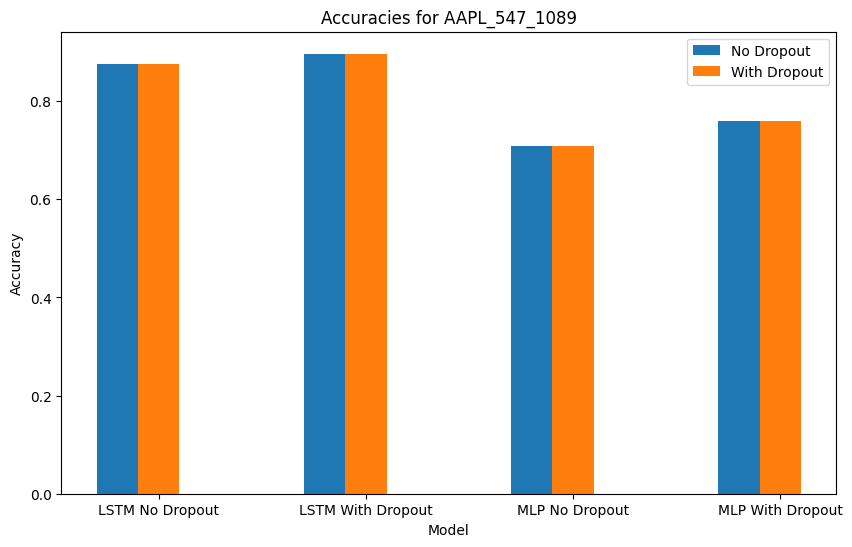


Results for AAPL_1089_1631:
Accuracy LSTM without Dropout: 0.9024
Accuracy LSTM with Dropout: 0.9193
Accuracy MLP without Dropout: 0.8007
Accuracy MLP with Dropout: 0.8100


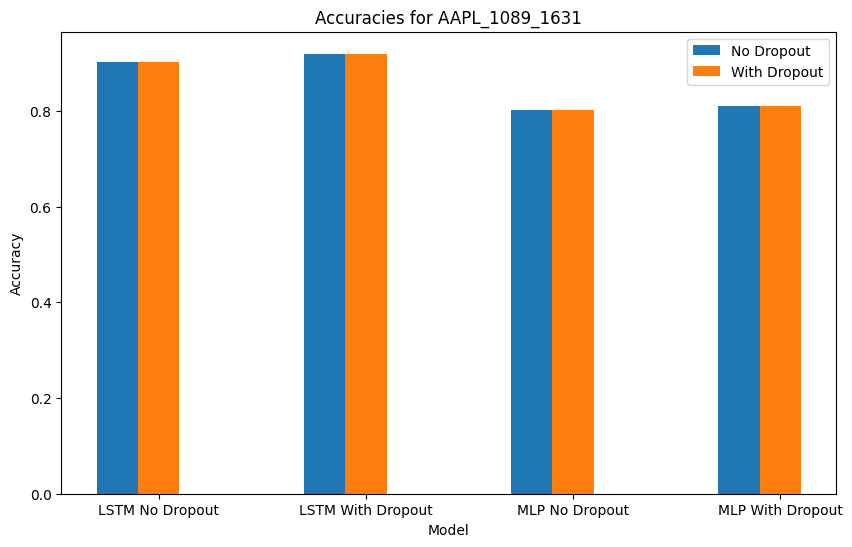


Results for AAPL_1631_2173:
Accuracy LSTM without Dropout: 0.9043
Accuracy LSTM with Dropout: 0.9400
Accuracy MLP without Dropout: 0.7583
Accuracy MLP with Dropout: 0.8007


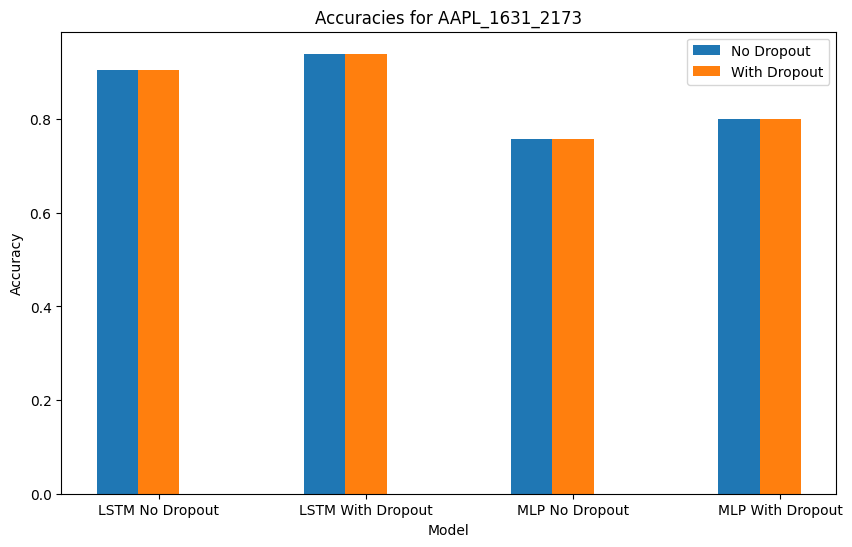


Results for AAPL_2173_2715:
Accuracy LSTM without Dropout: 0.8630
Accuracy LSTM with Dropout: 0.8218
Accuracy MLP without Dropout: 0.8137
Accuracy MLP with Dropout: 0.7934


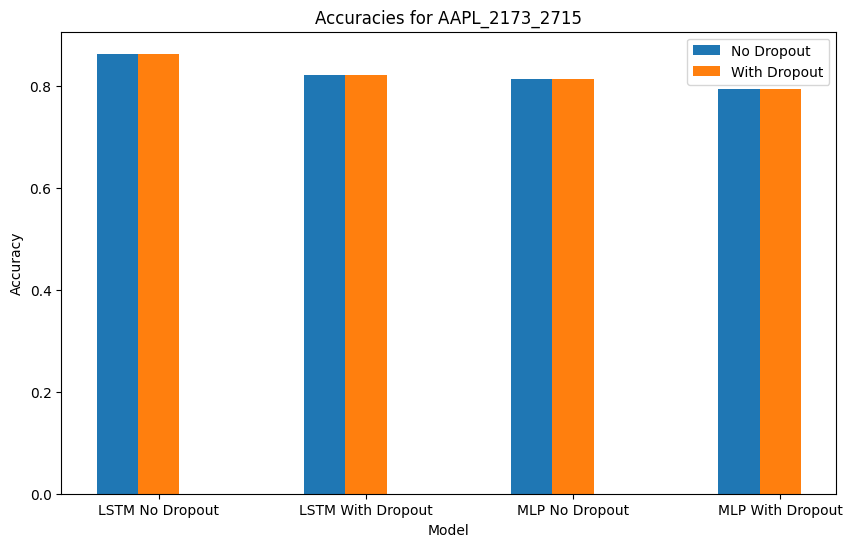


Results for AAPL_2715_3257:
Accuracy LSTM without Dropout: 0.8555
Accuracy LSTM with Dropout: 0.9174
Accuracy MLP without Dropout: 0.7934
Accuracy MLP with Dropout: 0.8229


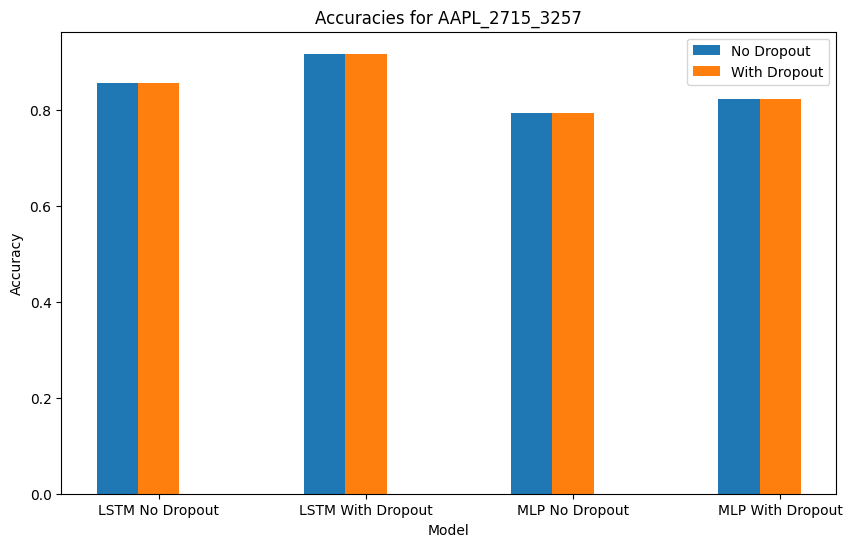


Results for META_443_886:
Accuracy LSTM without Dropout: 0.8733
Accuracy LSTM with Dropout: 0.8940
Accuracy MLP without Dropout: 0.7517
Accuracy MLP with Dropout: 0.7133


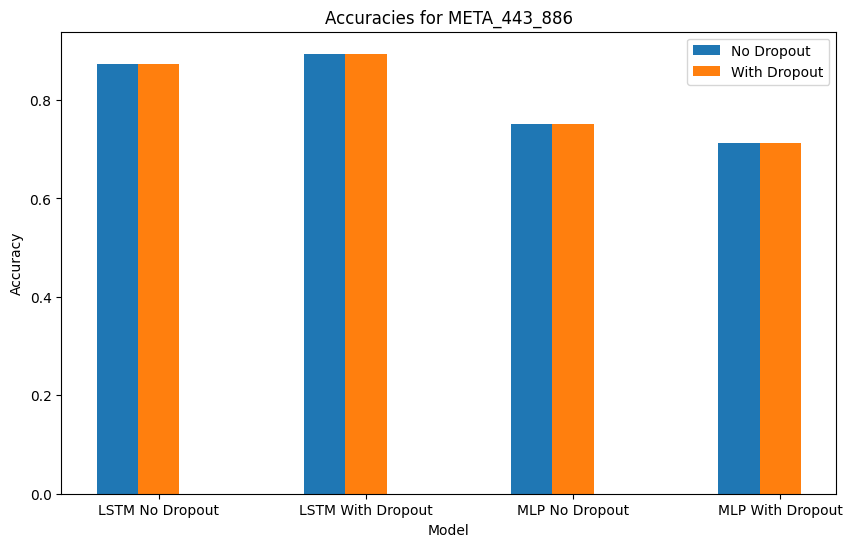


Results for META_886_1329:
Accuracy LSTM without Dropout: 0.8664
Accuracy LSTM with Dropout: 0.9217
Accuracy MLP without Dropout: 0.7765
Accuracy MLP with Dropout: 0.7585


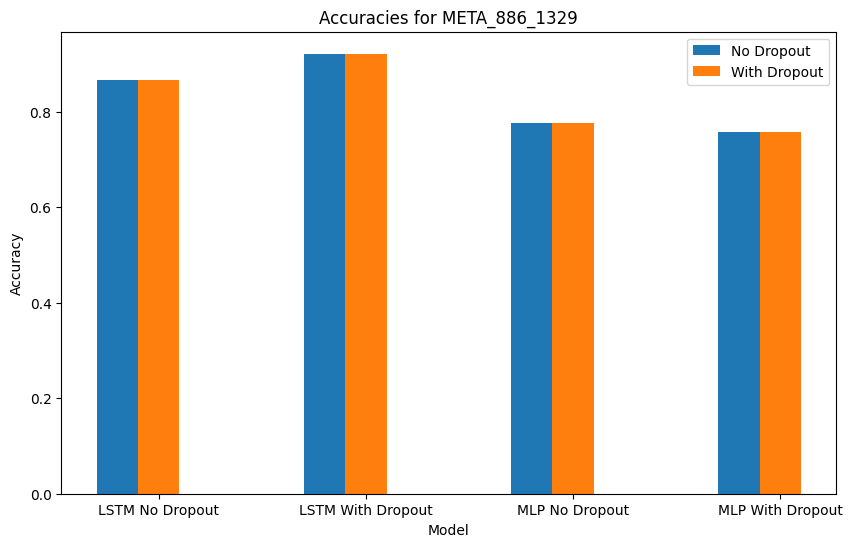


Results for META_1329_1772:
Accuracy LSTM without Dropout: 0.8479
Accuracy LSTM with Dropout: 0.8986
Accuracy MLP without Dropout: 0.7743
Accuracy MLP with Dropout: 0.7833


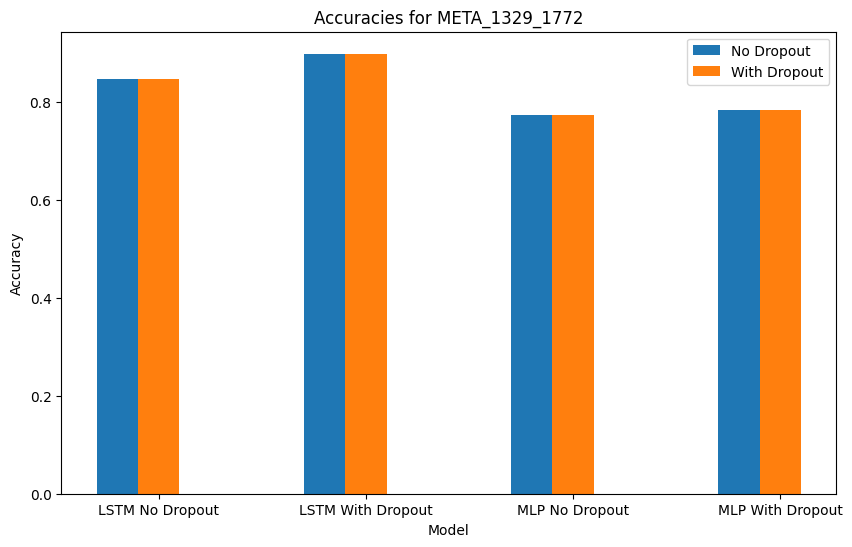


Results for META_1772_2215:
Accuracy LSTM without Dropout: 0.6452
Accuracy LSTM with Dropout: 0.7627
Accuracy MLP without Dropout: 0.8149
Accuracy MLP with Dropout: 0.8239


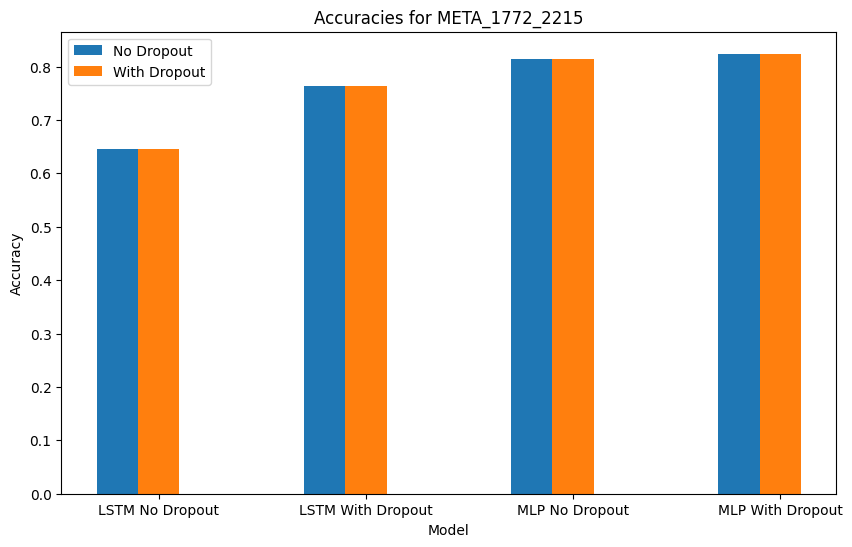


Results for META_2215_2658:
Accuracy LSTM without Dropout: 0.8641
Accuracy LSTM with Dropout: 0.9147
Accuracy MLP without Dropout: 0.8442
Accuracy MLP with Dropout: 0.8442


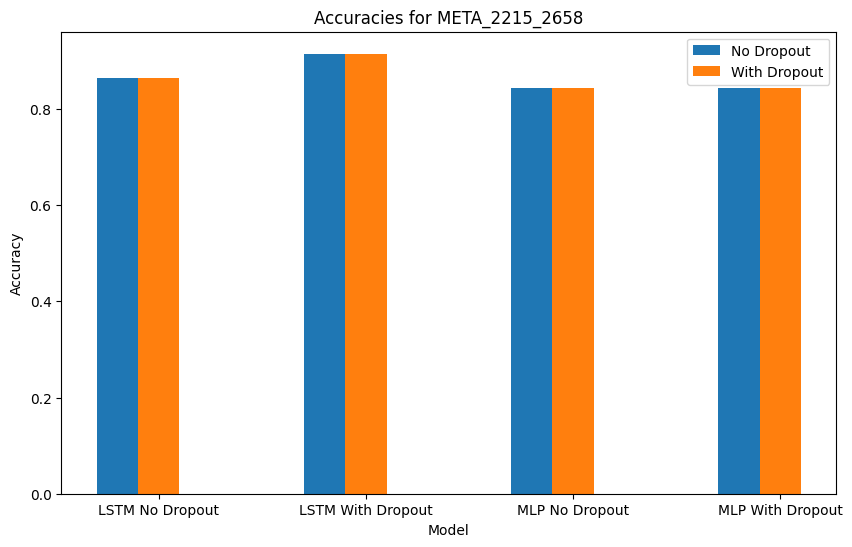


Results for AMZN_547_1089:
Accuracy LSTM without Dropout: 0.8856
Accuracy LSTM with Dropout: 0.8837
Accuracy MLP without Dropout: 0.7970
Accuracy MLP with Dropout: 0.7066


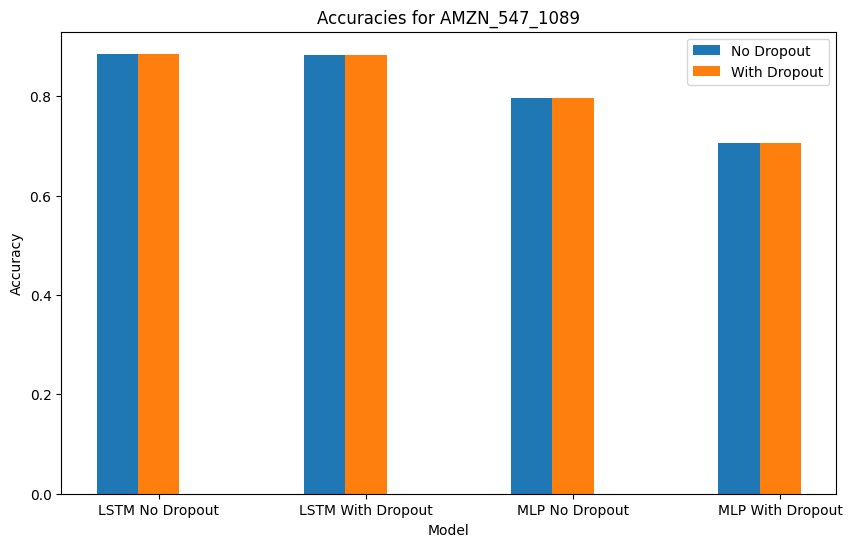


Results for AMZN_1089_1631:
Accuracy LSTM without Dropout: 0.9268
Accuracy LSTM with Dropout: 0.9231
Accuracy MLP without Dropout: 0.8044
Accuracy MLP with Dropout: 0.7601


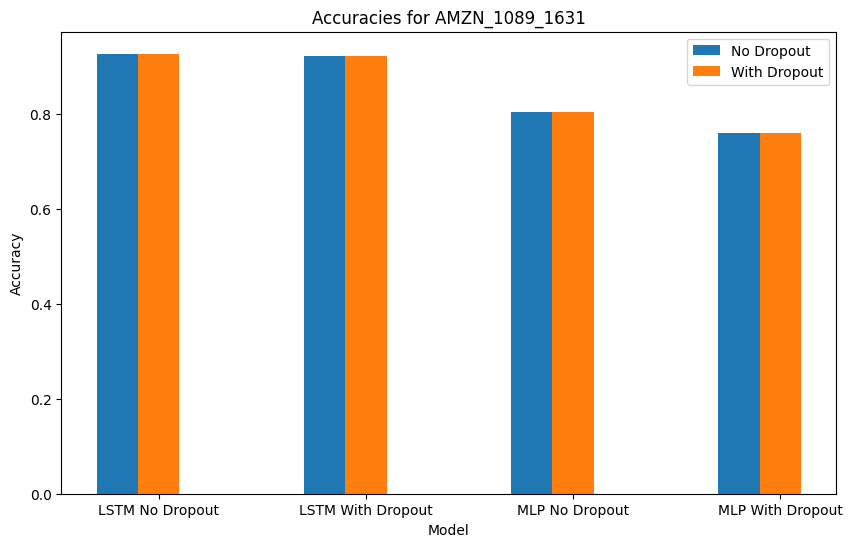


Results for AMZN_1631_2173:
Accuracy LSTM without Dropout: 0.8612
Accuracy LSTM with Dropout: 0.8874
Accuracy MLP without Dropout: 0.8044
Accuracy MLP with Dropout: 0.8173


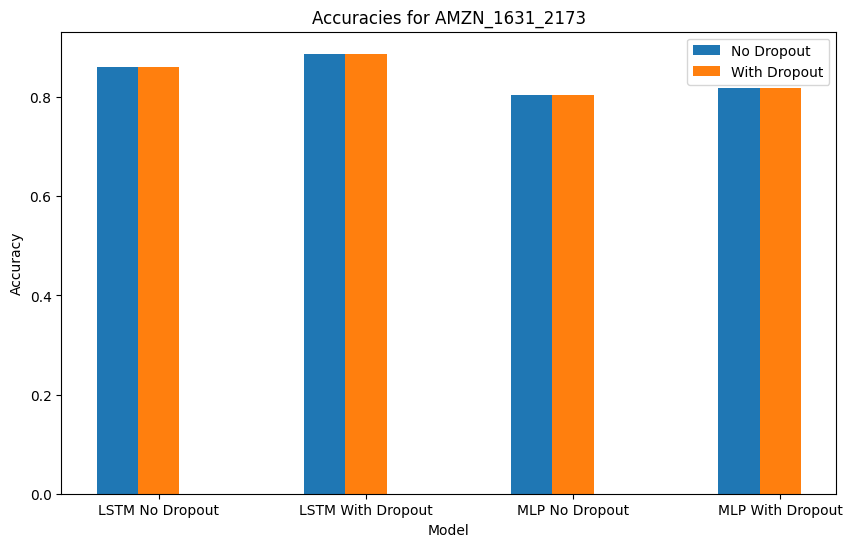


Results for AMZN_2173_2715:
Accuracy LSTM without Dropout: 0.8330
Accuracy LSTM with Dropout: 0.8724
Accuracy MLP without Dropout: 0.7841
Accuracy MLP with Dropout: 0.8100


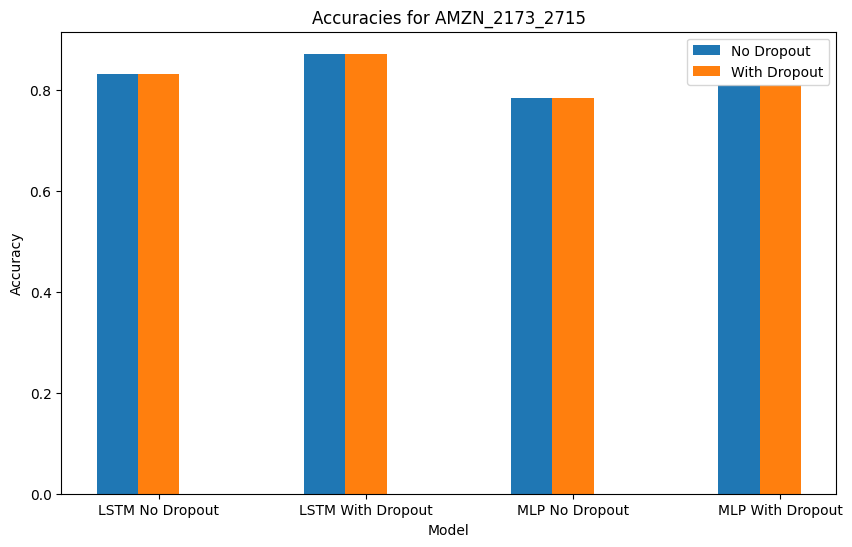


Results for AMZN_2715_3257:
Accuracy LSTM without Dropout: 0.8912
Accuracy LSTM with Dropout: 0.9250
Accuracy MLP without Dropout: 0.8321
Accuracy MLP with Dropout: 0.8321


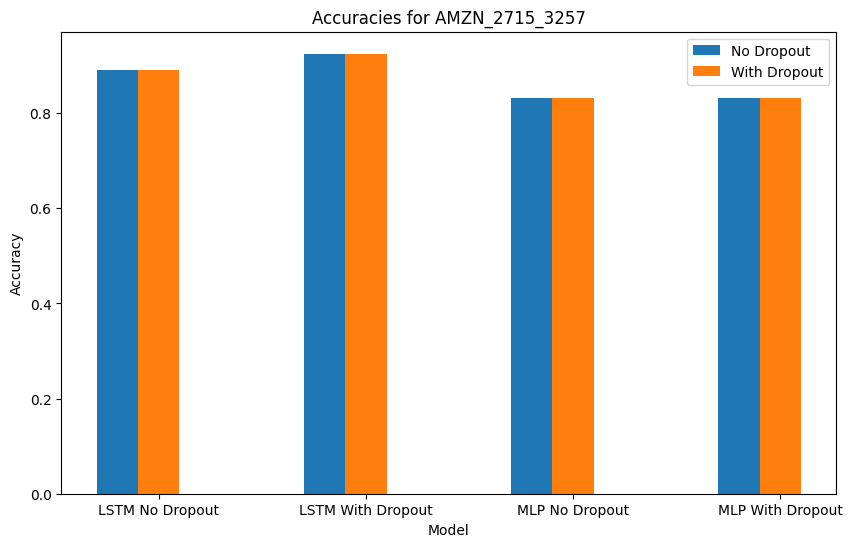


Results for MSFT_547_1089:
Accuracy LSTM without Dropout: 0.9062
Accuracy LSTM with Dropout: 0.9043
Accuracy MLP without Dropout: 0.7952
Accuracy MLP with Dropout: 0.7288


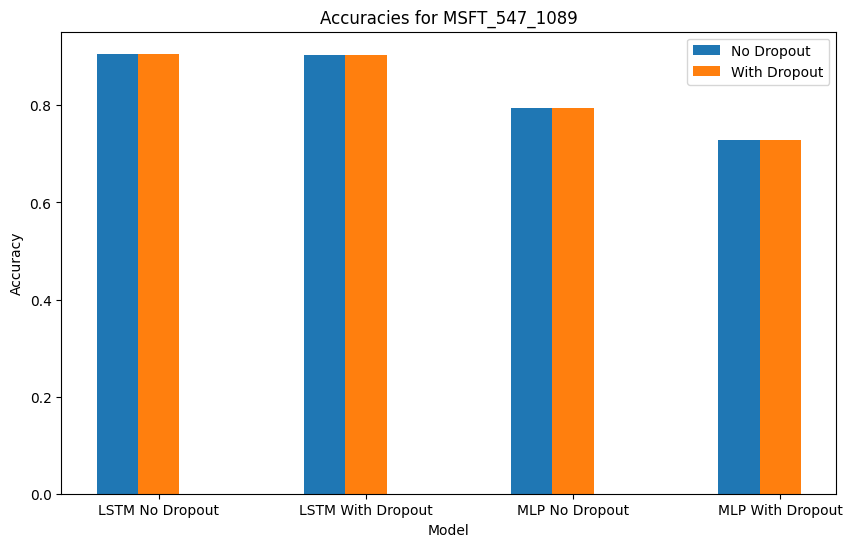


Results for MSFT_1089_1631:
Accuracy LSTM without Dropout: 0.8649
Accuracy LSTM with Dropout: 0.9024
Accuracy MLP without Dropout: 0.8007
Accuracy MLP with Dropout: 0.7841


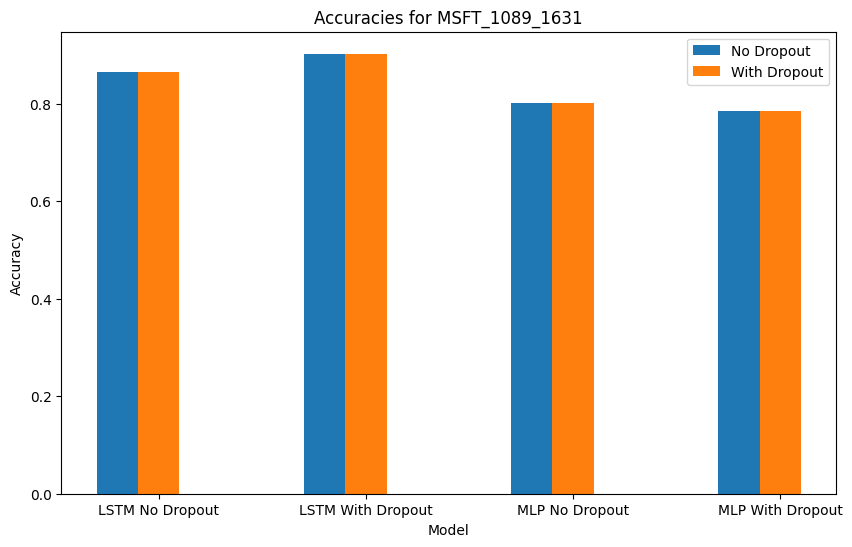


Results for MSFT_1631_2173:
Accuracy LSTM without Dropout: 0.8874
Accuracy LSTM with Dropout: 0.9250
Accuracy MLP without Dropout: 0.7897
Accuracy MLP with Dropout: 0.8155


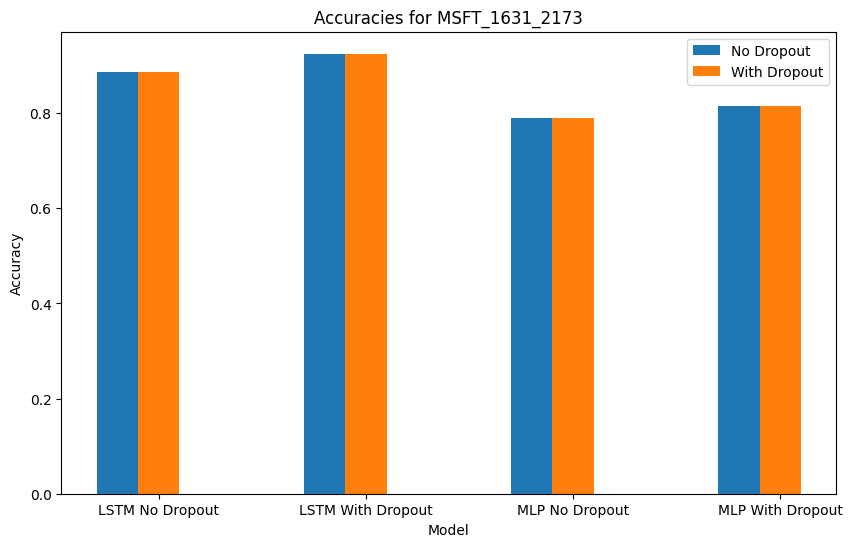


Results for MSFT_2173_2715:
Accuracy LSTM without Dropout: 0.7711
Accuracy LSTM with Dropout: 0.7842
Accuracy MLP without Dropout: 0.7970
Accuracy MLP with Dropout: 0.8395


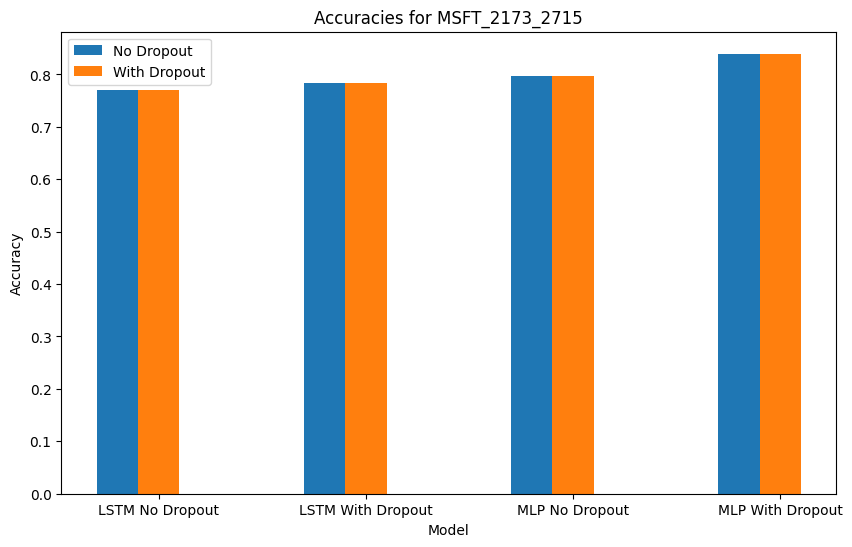


Results for MSFT_2715_3257:
Accuracy LSTM without Dropout: 0.8593
Accuracy LSTM with Dropout: 0.8949
Accuracy MLP without Dropout: 0.7675
Accuracy MLP with Dropout: 0.8469


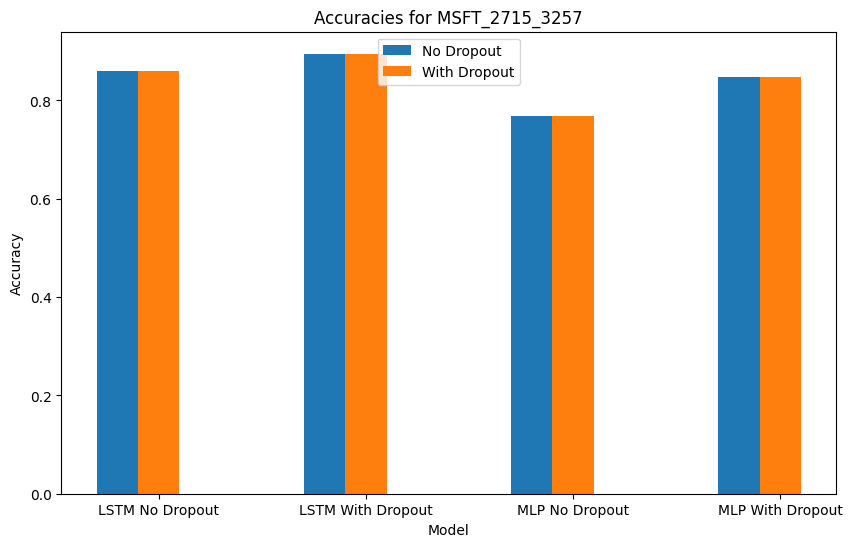


Results for GOOGL_547_1089:
Accuracy LSTM without Dropout: 0.8818
Accuracy LSTM with Dropout: 0.8874
Accuracy MLP without Dropout: 0.7122
Accuracy MLP with Dropout: 0.7343


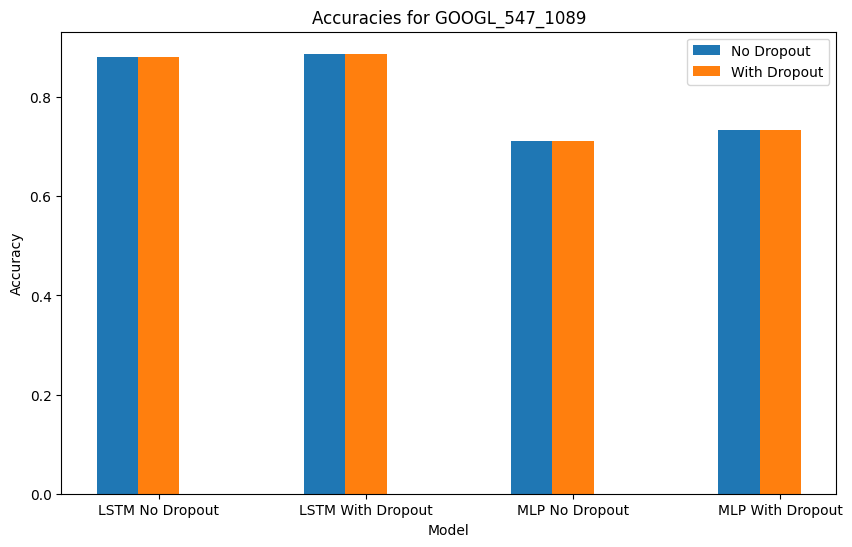


Results for GOOGL_1089_1631:
Accuracy LSTM without Dropout: 0.8743
Accuracy LSTM with Dropout: 0.9062
Accuracy MLP without Dropout: 0.7915
Accuracy MLP with Dropout: 0.7915


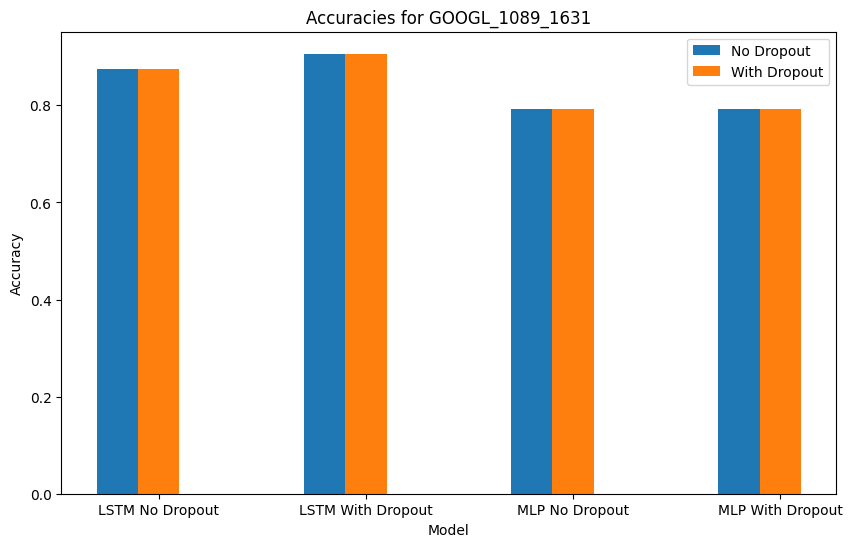


Results for GOOGL_1631_2173:
Accuracy LSTM without Dropout: 0.8931
Accuracy LSTM with Dropout: 0.8856
Accuracy MLP without Dropout: 0.8192
Accuracy MLP with Dropout: 0.8155


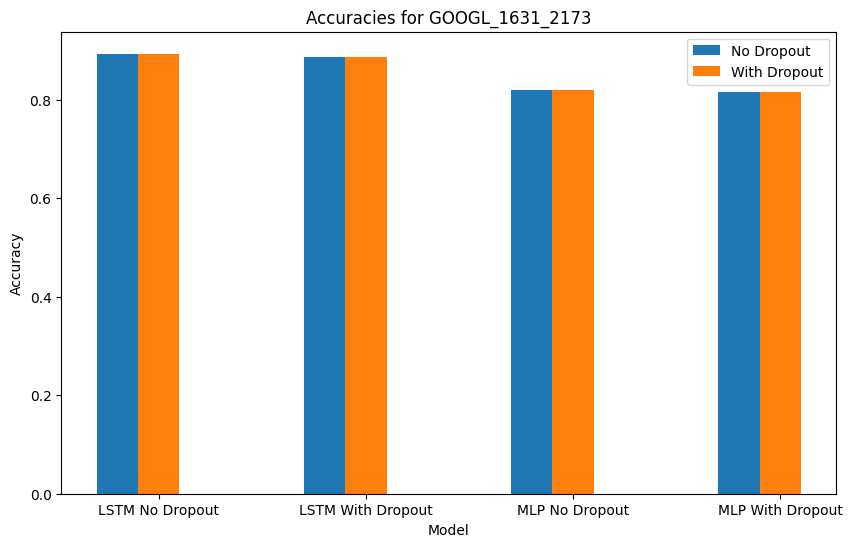


Results for GOOGL_2173_2715:
Accuracy LSTM without Dropout: 0.8762
Accuracy LSTM with Dropout: 0.9043
Accuracy MLP without Dropout: 0.8081
Accuracy MLP with Dropout: 0.8063


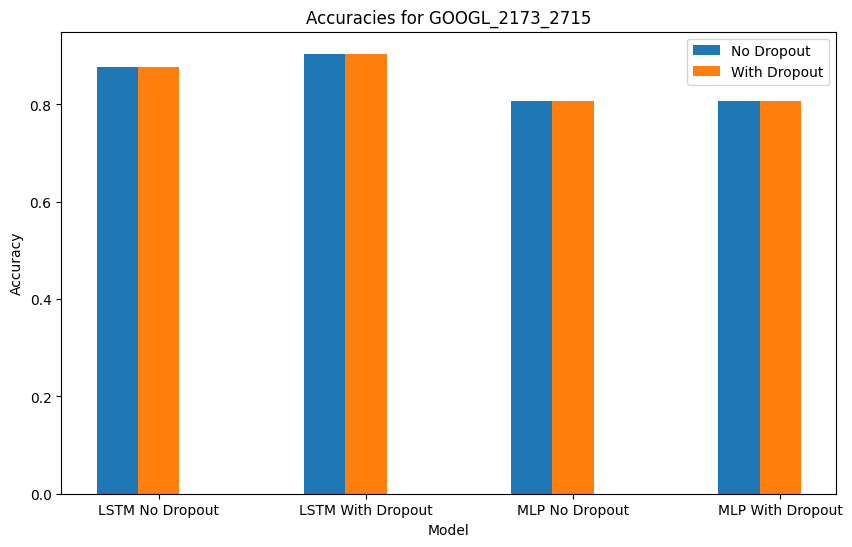


Results for GOOGL_2715_3257:
Accuracy LSTM without Dropout: 0.8724
Accuracy LSTM with Dropout: 0.8837
Accuracy MLP without Dropout: 0.8044
Accuracy MLP with Dropout: 0.8229


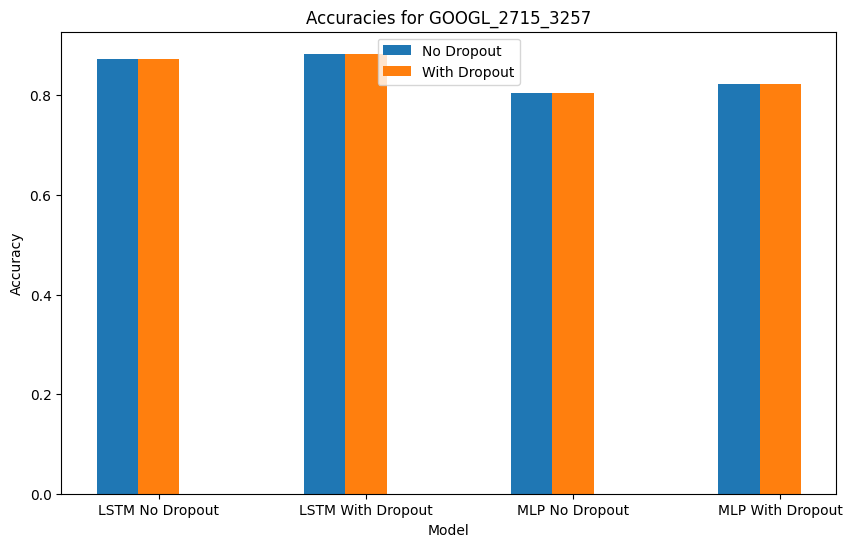


Results for GOOGL_1_548:
Accuracy LSTM without Dropout: 0.8780
Accuracy LSTM with Dropout: 0.8874
Accuracy MLP without Dropout: 0.7934
Accuracy MLP with Dropout: 0.8247


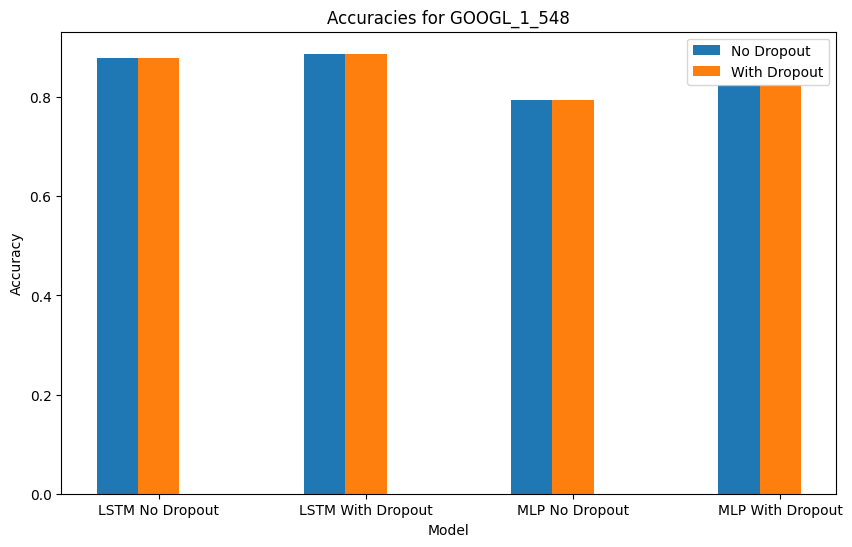


Results for GOOGL_1_1090:
Accuracy LSTM without Dropout: 0.8687
Accuracy LSTM with Dropout: 0.9006
Accuracy MLP without Dropout: 0.8044
Accuracy MLP with Dropout: 0.8339


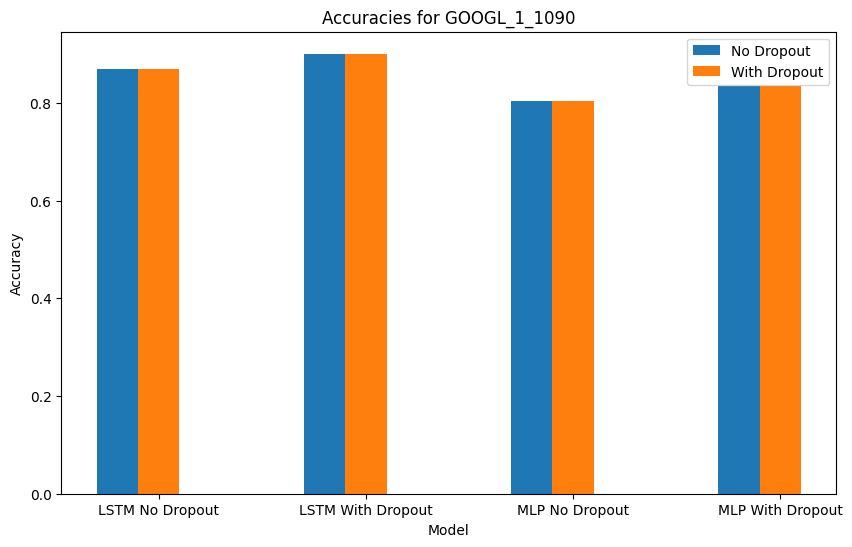


Results for GOOGL_1_1632:
Accuracy LSTM without Dropout: 0.8856
Accuracy LSTM with Dropout: 0.8931
Accuracy MLP without Dropout: 0.8303
Accuracy MLP with Dropout: 0.8376


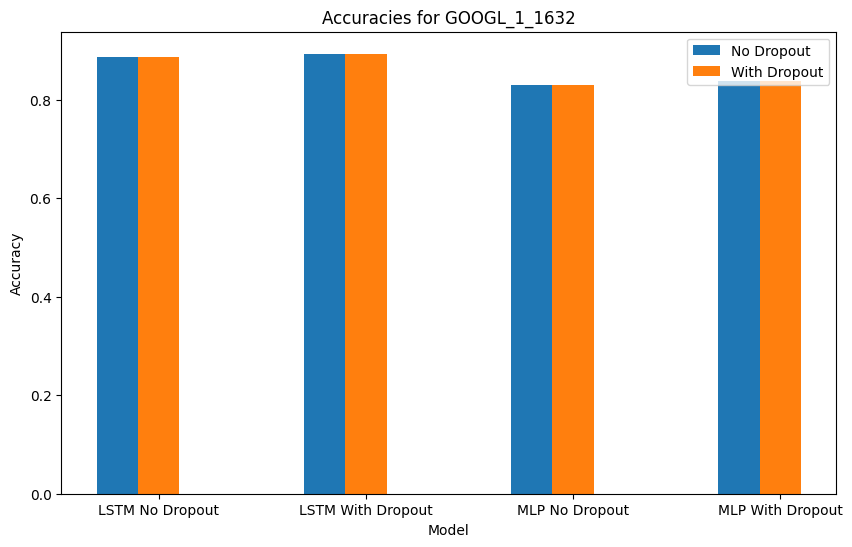


Results for GOOGL_1_2174:
Accuracy LSTM without Dropout: 0.8649
Accuracy LSTM with Dropout: 0.9156
Accuracy MLP without Dropout: 0.8044
Accuracy MLP with Dropout: 0.8229


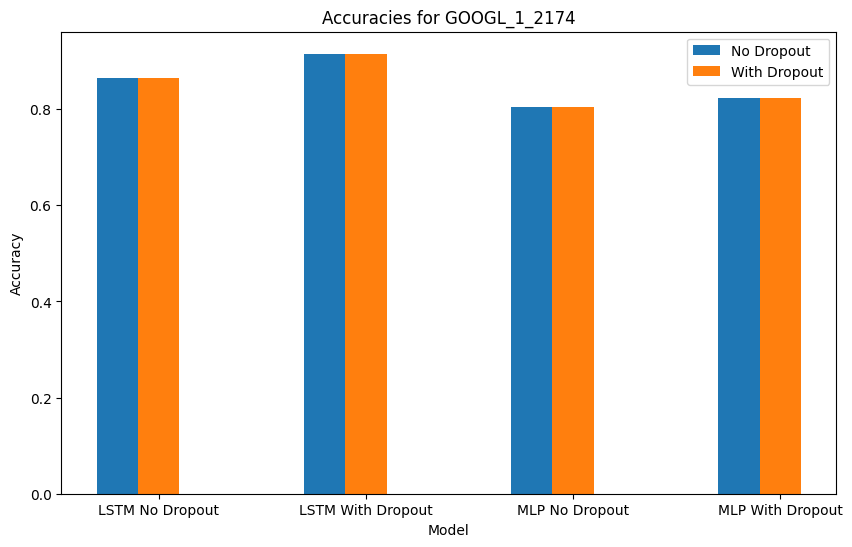


Results for GOOGL_1_2716:
Accuracy LSTM without Dropout: 0.8255
Accuracy LSTM with Dropout: 0.9024
Accuracy MLP without Dropout: 0.8321
Accuracy MLP with Dropout: 0.8358


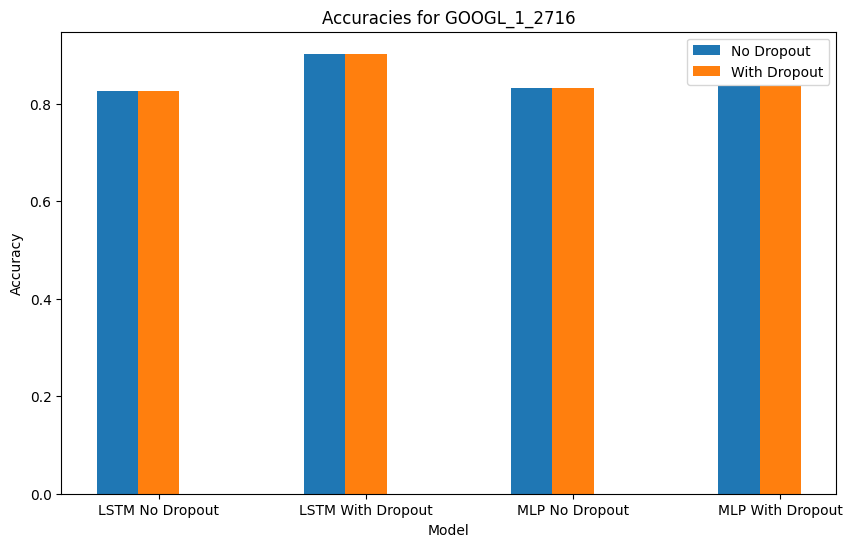

In [ ]:
# Visualization
for key, value in results.items():
    print(f'\nResults for {key}:')
    print(f'Accuracy LSTM without Dropout: {value["accuracy_lstm_no_dropout"]:.4f}')
    print(f'Accuracy LSTM with Dropout: {value["accuracy_lstm_dropout"]:.4f}')
    print(f'Accuracy MLP without Dropout: {value["accuracy_mlp_no_dropout"]:.4f}')
    print(f'Accuracy MLP with Dropout: {value["accuracy_mlp_dropout"]:.4f}')

    # Plot accuracies with a grouped bar chart
    models = ['LSTM No Dropout', 'LSTM With Dropout', 'MLP No Dropout', 'MLP With Dropout']
    accuracies = [value['accuracy_lstm_no_dropout'], value['accuracy_lstm_dropout'], value['accuracy_mlp_no_dropout'], value['accuracy_mlp_dropout']]

    bar_width = 0.2
    index = np.arange(len(models))

    plt.figure(figsize=(10, 6))

    plt.bar(index - bar_width, accuracies, bar_width, label='No Dropout')
    plt.bar(index, accuracies, bar_width, label='With Dropout')

    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracies for {key}')
    plt.xticks(index, models)
    plt.legend()
    plt.show()


17/17 [==============================] - 0s 2ms/step
MLP Accuracy for AAPL: 0.8284132841328413


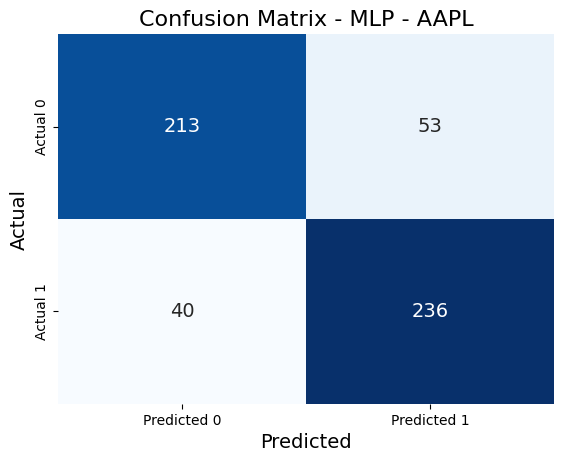

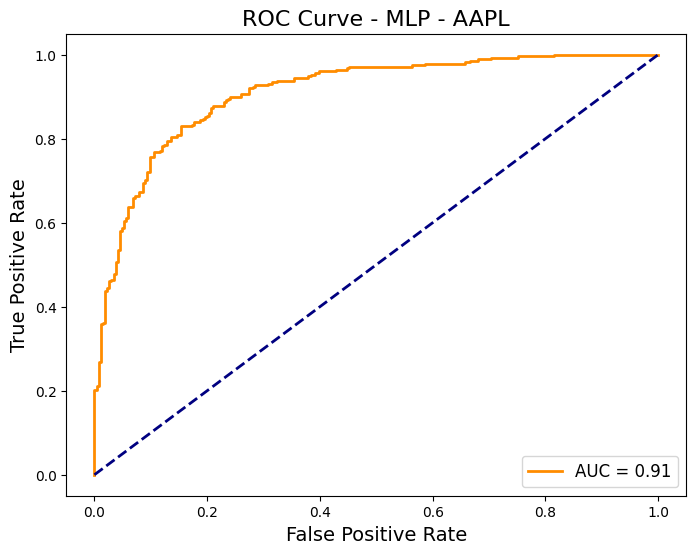

17/17 [==============================] - 0s 5ms/step
MLP Accuracy for META: 0.8284132841328413


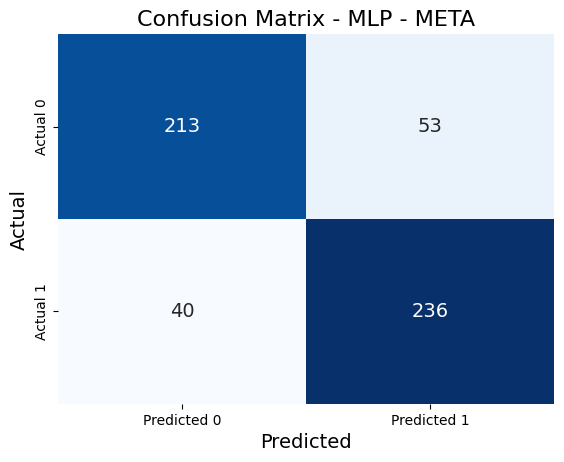

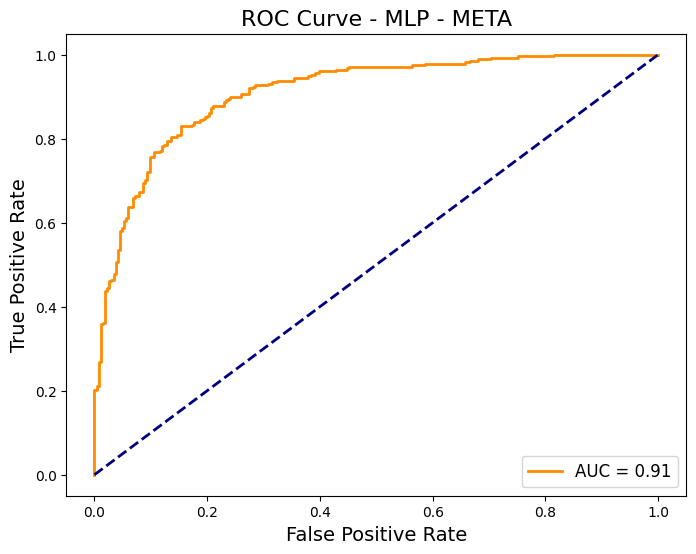

17/17 [==============================] - 0s 6ms/step
MLP Accuracy for AMZN: 0.8284132841328413


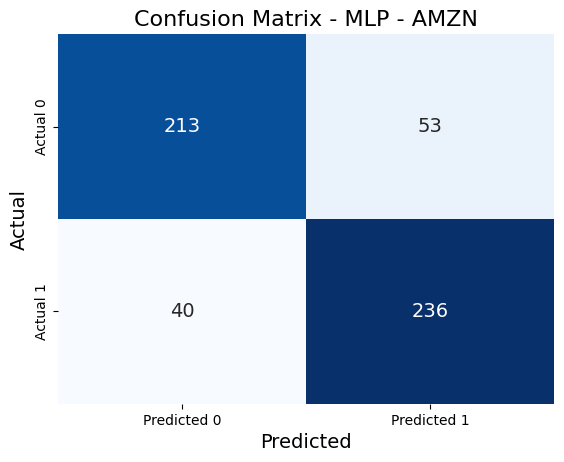

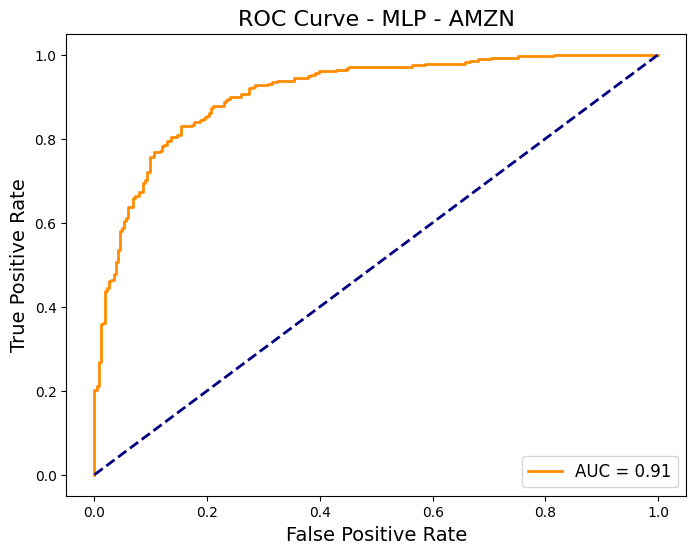

17/17 [==============================] - 0s 4ms/step
MLP Accuracy for MSFT: 0.8284132841328413


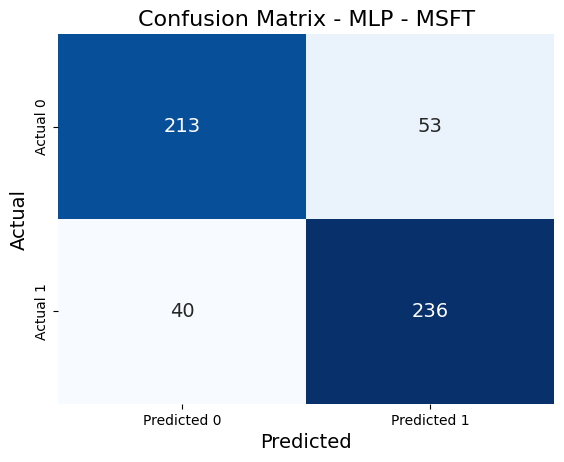

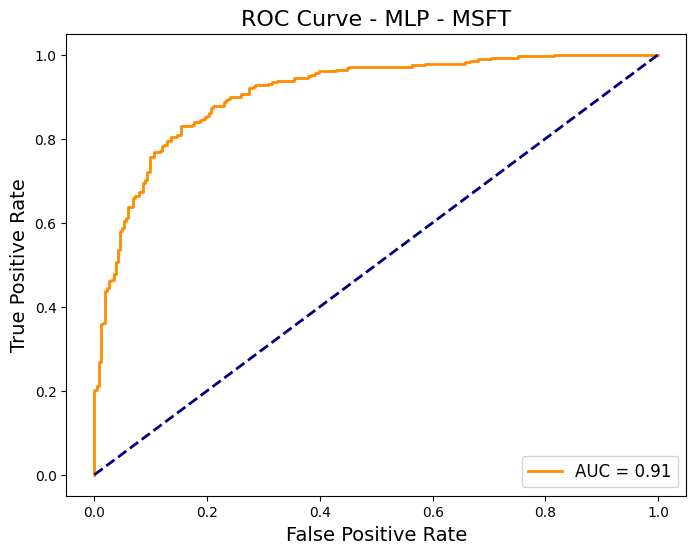

17/17 [==============================] - 0s 3ms/step
MLP Accuracy for GOOGL: 0.8284132841328413


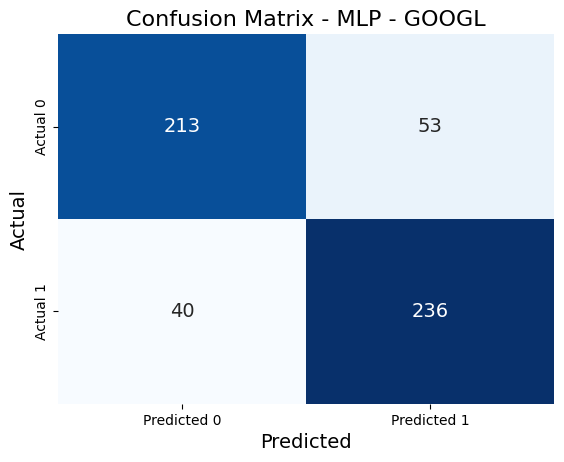

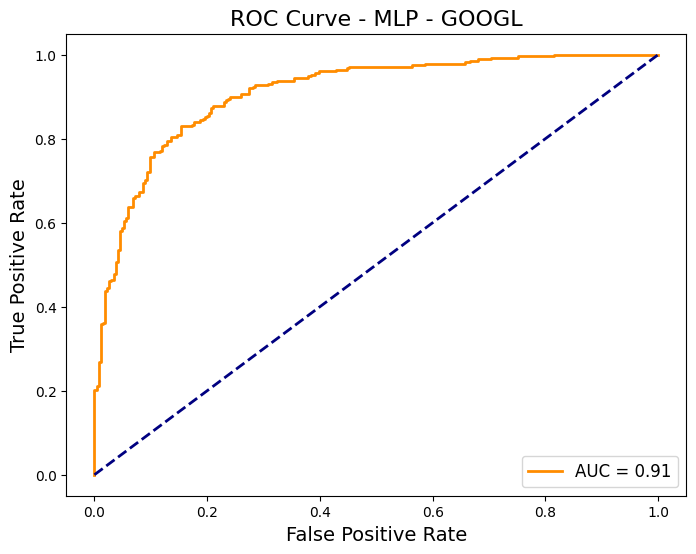

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                annot_kws={'size': 14}, xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(title, fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_prob, title='ROC Curve'):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.show()

for symbol in symbols:

    # Evaluate LSTM accuracy
    # y_prob_lstm = model_lstm.predict(X_test_lstm)
    # y_pred_lstm = (y_prob_lstm > 0.5).astype(int)
    # accuracy_lstm = accuracy_score(y_test_lstm, y_pred_lstm)
    # print(f'LSTM Accuracy for {symbol}: {accuracy_lstm}')

    # # Plot confusion matrix for LSTM
    # plot_confusion_matrix(y_test_lstm, y_pred_lstm, title=f'Confusion Matrix - LSTM - {symbol}')

    # # Plot ROC curve for LSTM
    # plot_roc_curve(y_test_lstm, y_prob_lstm, title=f'ROC Curve - LSTM - {symbol}')

    # Evaluate MLP accuracy
    y_prob_mlp = model_mlp.predict(X_test)
    y_pred_mlp = (y_prob_mlp > 0.5).astype(int)
    accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
    print(f'MLP Accuracy for {symbol}: {accuracy_mlp}')

    # Plot confusion matrix for MLP
    plot_confusion_matrix(y_test, y_pred_mlp, title=f'Confusion Matrix - MLP - {symbol}')

    # Plot ROC curve for MLP
    plot_roc_curve(y_test, y_prob_mlp, title=f'ROC Curve - MLP - {symbol}')


**Avaluating the best Model**

In [ ]:
# Assuming 'history' is the output of the 'fit' method of your model
history = model_mlp.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping_mlp], verbose=0)

# Get the training accuracy
training_accuracy = history.history['accuracy']

# Get the testing accuracy
testing_accuracy = history.history['val_accuracy']

print(f'Training Accuracy: {training_accuracy[-1]}')
print(f'Testing Accuracy: {testing_accuracy[-1]}')


Training Accuracy: 0.8276243209838867
Testing Accuracy: 0.830258309841156


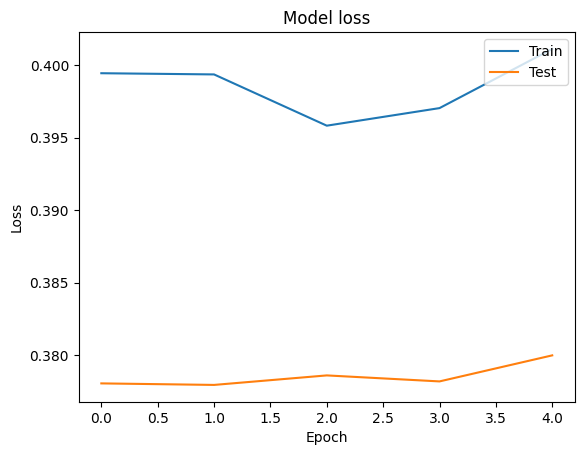

In [ ]:
import matplotlib.pyplot as plt

history = model_mlp.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping_mlp], verbose=0)

# Plotting the learning curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Assuming 'y_test' are the true labels and 'y_pred' are the predicted labels
y_pred = (model_mlp.predict(X_test) > 0.7).astype(int)

print(classification_report(y_test, y_pred))


17/17 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.75      0.92      0.83       266
           1       0.91      0.70      0.79       276

    accuracy                           0.81       542
   macro avg       0.83      0.81      0.81       542
weighted avg       0.83      0.81      0.81       542



17/17 [==============================] - 0s 1ms/step


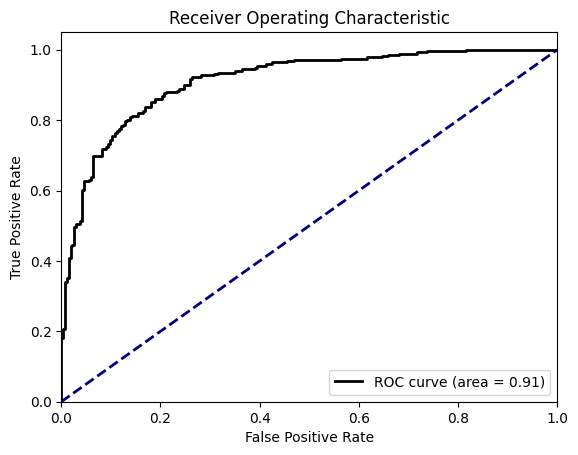

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'y_test' are the true labels and 'y_pred_proba' are the predicted probabilities
y_pred_proba = model_mlp.predict(X_test)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='black', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


**2.Portfolio Allocation**

*To recheck the chord_Producing wild results*

In [ ]:
# Function to perform backtesting and portfolio allocation
def backtest_and_allocate(model, features, target, stock_symbol):
    y_pred = (model.predict(features) > 0.5).astype(int)

    # Assuming your model predicts trend direction (1 for buy, 0 for sell)
    signals = pd.Series(y_pred.squeeze(), index=target.index, name='Signal')

    # Calculate daily returns based on predicted signals
    daily_returns = target * signals.shift(1)

    # Assume initial capital of $1,000,000
    initial_capital = 1000000
    capital = initial_capital

    # Portfolio value over time
    portfolio_value = [capital]

    # Portfolio allocation
    allocation = 1  # 100% allocation to the predicted signal

    for i in range(1, len(daily_returns)):
        capital *= (1 + daily_returns.iloc[i] * allocation)

        # Append the new portfolio value
        portfolio_value.append(capital)

    # Create a DataFrame to store portfolio values
    portfolio_df = pd.DataFrame(portfolio_value, index=daily_returns.index, columns=[stock_symbol])

    # Print final portfolio value
    print(f"Final portfolio value for {stock_symbol}: {portfolio_df.iloc[-1][stock_symbol]}")

    return portfolio_df

# Time series split with purging and embargoing
tscv = TimeSeriesSplit(n_splits=5)

for symbol in symbols:
    # Split the data using time series split
    for train_index, test_index in tscv.split(features_scaled):
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        # Build and train LSTM model with dropout and early stopping
        lstm_input_shape = (X_train.shape[1], X_train.shape[2])
        model_lstm = build_lstm_model_with_dropout_and_early_stopping(lstm_input_shape, dropout_rate=0.2)

        # Use EarlyStopping callback for LSTM
        early_stopping_lstm = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model_lstm.fit(X_train, y_train, epochs=50, batch_size=32,
                       validation_data=(X_test, y_test), callbacks=[early_stopping_lstm],verbose=0)

        # Perform backtesting and portfolio allocation for LSTM
        portfolio_lstm = backtest_and_allocate(model_lstm, X_test, y_test, symbol)

        # Repeat the same process for MLP or other models

        # Use EarlyStoppingfor MLP:
        # mlp_input_shape = (X_train.shape[1],)
        # model_mlp = build_mlp_model_with_dropout_and_early_stopping(mlp_input_shape, dropout_rate=0.2)
        # early_stopping_mlp = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        # model_mlp.fit(X_train, y_train, epochs=50, batch_size=32,
        #               validation_data=(X_test, y_test), callbacks=[early_stopping_mlp],verbose=0)
        # portfolio_mlp = backtest_and_allocate(model_mlp, X_test, y_test, symbol)


17/17 [==============================] - 1s 5ms/step
Final portfolio value for AAPL: 6.73998666678766e+72
17/17 [==============================] - 0s 2ms/step
Final portfolio value for AAPL: 2.1062458333711437e+71
17/17 [==============================] - 0s 2ms/step
Final portfolio value for AAPL: 4.3135914667441024e+74
17/17 [==============================] - 0s 2ms/step
Final portfolio value for AAPL: 8.424983333484575e+71
17/17 [==============================] - 0s 2ms/step
Final portfolio value for AAPL: 2.695994666715064e+73
17/17 [==============================] - 0s 2ms/step
Final portfolio value for META: 5.391989333430128e+73
17/17 [==============================] - 0s 2ms/step
Final portfolio value for META: 1.725436586697641e+75
17/17 [==============================] - 0s 2ms/step
Final portfolio value for META: 5.391989333430128e+73
17/17 [==============================] - 0s 2ms/step
Final portfolio value for META: 2.1567957333720512e+74
17/17 [============================

In [ ]:
def backtest_and_allocate(model, features, target, stock_symbol):
    y_pred = (model.predict(features) > 0.8).astype(int)
    signals = pd.Series(y_pred.squeeze(), index=target.index, name='Signal')
    daily_returns = target * signals.shift(1)
    initial_capital = 1
    capital = initial_capital
    portfolio_value = [capital]
    allocation = 0.01  # Allocate 10% of capital to each trade
    transaction_cost = 0.001  # 0.1% transaction cost

    for i in range(1, len(daily_returns)):
        trade_return = daily_returns.iloc[i] * allocation
        capital *= (1 + trade_return - transaction_cost)
        portfolio_value.append(capital)

    portfolio_df = pd.DataFrame(portfolio_value, index=daily_returns.index, columns=[stock_symbol])
    print(f"Final portfolio value for {stock_symbol}: {portfolio_df.iloc[-1][stock_symbol]}")
    return portfolio_df

# Split the data using time series split
for train_index, test_index in tscv.split(features_scaled):
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    mlp_input_shape = (X_train.shape[1],)
    model_mlp = build_mlp_model_with_dropout_and_early_stopping(mlp_input_shape, dropout_rate=0.2)
    early_stopping_mlp = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model_mlp.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping_mlp], verbose=0)
    portfolio_mlp = backtest_and_allocate(model_mlp, X_test, y_test, symbol)


17/17 [==============================] - 0s 1ms/step
Final portfolio value for GOOGL: 1.4263961279276502
17/17 [==============================] - 0s 2ms/step
Final portfolio value for GOOGL: 1.2911698345661007
17/17 [==============================] - 0s 1ms/step
Final portfolio value for GOOGL: 1.2657035992880725
17/17 [==============================] - 0s 2ms/step
Final portfolio value for GOOGL: 1.35709972092034
17/17 [==============================] - 0s 1ms/step
Final portfolio value for GOOGL: 1.240739644284785
